In [ ]:
import torch
print(torch.cuda.is_available())  # True가 출력되어야 합니다
print(torch.cuda.get_device_name(0))  # NVIDIA GeForce RTX 2070이 출력되어야 합니다

pip install pandas numpy torch scikit-learn matplotlib seaborn joblib streamlit optuna scipy openpyxl 

pip install optuna-integration[pytorch_lightning] pytorch-lightning

In [ ]:
# Cell 1: 라이브러리 및 설정 (Optuna 하이퍼파라미터 최적화 추가)
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib # 스케일러 저장용
import streamlit as st # GUI용 (Cell 12에서만 사용)
import os # GUI용 파일 경로 확인

# === Optuna 하이퍼파라미터 최적화 관련 ===
import optuna
from optuna.integration import PyTorchLightningPruningCallback
from optuna.trial import TrialState
import logging
import warnings
from scipy.optimize import fsolve
from collections import Counter
import time
from datetime import datetime
import pickle

# 로깅 설정
logging.basicConfig(level=logging.INFO)
optuna.logging.set_verbosity(optuna.logging.WARNING)

# 데이터 경로 정의 (파일명 확인 및 수정)
data_path = "TrainSet0507_NoDuplicatesHV.xlsx" #TrainSet0507_NoDuplicates

# 장치 설정 (가능하면 GPU/MPS, 아니면 CPU 사용)
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"사용 장치: {device}")

# 재현성을 위한 랜덤 시드 설정
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if device == 'cuda':
    torch.cuda.manual_seed(seed)
elif device == 'mps':
     pass

print("라이브러리 임포트 및 설정 완료 (Optuna 하이퍼파라미터 최적화 포함).")

In [ ]:
# Cell 2: 데이터 로딩 및 초기 검사

try:
    # 'Tensile' 시트 로드
    df_tensile = pd.read_excel(data_path, sheet_name='Tensile', header=0)
    print("--- Tensile 시트 ---")
    print(f"형태: {df_tensile.shape}")
    print("\n컬럼:", df_tensile.columns.tolist())
    print("\n처음 5행:\n", df_tensile.head())
    print("\n데이터 타입:\n", df_tensile.dtypes)
    print("\n결측치 요약:\n", df_tensile.isnull().sum())

except FileNotFoundError:
    print(f"오류: {data_path}에서 파일을 찾을 수 없습니다")
except Exception as e:
    print(f"데이터 로딩 중 오류 발생: {e}")

# 필요한 컬럼명 확인 (주석)
# E: 'E'
# YS: 'YS'
# TS: 'TS'
# HB: 'HB'
# HV: 'HV'
# sf: 'sf' (sigma_f')
# b: 'b'
# ef: 'ef' (epsilon_f')
# c: 'c'


# np_col = "n'" # 선택사항
# kp_col = "K' (MPa)" # 선택사항


In [ ]:
# Cell 3: 컬럼 이름 변경 및 타입 변환

# --- 컬럼 이름 매핑 정의 (실제 파일 컬럼명 기준) ---
column_mapping = {
    'E': 'E_GPa',
    'YS': 'YS_MPa',
    'TS': 'TS_MPa',
    'HB': 'HB',
    'HV': 'HV',
    "sf": 'spf_MPa',
    'b': 'b',
    "ef": 'epf',
    'c': 'c',
    # 사용할 경우 선택적 컬럼 추가
    # "n'": 'np',
    # "K' (MPa)": 'Kp_MPa',
    # 'Material Name', 'RA (%)' 등과 같은 다른 관련 컬럼 추가
    #'RA': 'RA_percent' # RA가 존재하고 필요한 경우 예시
}

# 사용할 컬럼만 선택 및 이름 변경
required_cols = list(column_mapping.keys())
available_cols = [col for col in required_cols if col in df_tensile.columns]
missing_cols = [col for col in required_cols if col not in available_cols]

print(f"\n사용 가능한 컬럼: {available_cols}")
if missing_cols:
    print(f"경고: 다음 컬럼이 데이터에 없습니다: {missing_cols}. 해당 컬럼 없이 진행합니다.")
    # 필수 컬럼 누락 시 에러 처리 또는 중지 로직 추가 가능

# 사용 가능한 컬럼만으로 매핑 재생성
column_mapping_available = {k: v for k, v in column_mapping.items() if k in available_cols}

df = df_tensile[available_cols].copy()
df.rename(columns=column_mapping_available, inplace=True)

hv_col_exists = 'HV' in df.columns

# 숫자형 변환 (오류는 NaN)
numeric_cols_base = ['E_GPa', 'YS_MPa', 'TS_MPa', 'HB', 'spf_MPa', 'b', 'epf', 'c']
numeric_cols = [col for col in numeric_cols_base if col in df.columns] # 존재하는 컬럼만 대상으로 함
if hv_col_exists:
    numeric_cols.append('HV')

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print("\n이름 변경 및 숫자 변환 후 DataFrame:")
print(df.head())
print("\n데이터 타입:\n", df.dtypes)
print("\n강제 변환 후 결측치 요약:\n", df.isnull().sum())

# E 단위 변환 (GPa -> MPa)
if 'E_GPa' in df.columns:
    df['E_MPa'] = df['E_GPa'] * 1000
    df.drop(columns=['E_GPa'], inplace=True)
    print("\nE를 MPa로 변환했습니다('E_MPa' 컬럼 생성됨).")
    # Ensure E_MPa is in numeric_cols if E_GPa was
    if 'E_GPa' in numeric_cols:
        numeric_cols.remove('E_GPa')
        if 'E_MPa' not in numeric_cols:
             numeric_cols.append('E_MPa')


# 최종 특성 및 타겟 컬럼 이름 정의 (HB는 Cell 4에서 처리 후 추가)
feature_cols_base = ['E_MPa', 'YS_MPa', 'TS_MPa']
feature_cols = [col for col in feature_cols_base if col in df.columns] # 존재하는 특성만 사용
target_cols_base = ['spf_MPa', 'b', 'epf', 'c']
target_cols = [col for col in target_cols_base if col in df.columns] # 존재하는 타겟만 사용

# 타겟 변수 누락 행 제거
if not target_cols:
     print("오류: 타겟 변수가 하나도 없습니다. 학습을 진행할 수 없습니다.")
else:
    initial_rows = len(df)
    df.dropna(subset=target_cols, inplace=True)
    print(f"\n타겟 값({target_cols})이 누락된 {initial_rows - len(df)}개 행을 삭제했습니다.")
    print(f"남은 행: {len(df)}")

In [ ]:
# Cell 4: HB/HV 처리 (수정됨 - ML/Median 대체 제거, HV 변환 우선)

hb_col_name = 'HB' # 원본 HB 컬럼명 (매핑 후 이름)
hv_col_name = 'HV' # 원본 HV 컬럼명 (매핑 후 이름)
hb_processed_col = 'HB_processed' # 새로 생성할 처리된 HB 컬럼

if hb_col_name not in df.columns:
    print(f"경고: HB 컬럼('{hb_col_name}')이 없습니다. HB 특성을 사용할 수 없습니다.")
    # HB 컬럼이 아예 없으면 hb_processed 생성 불가 -> 이후 로직에서 HB 사용 제외 필요
    hb_available = False
else:
    hb_available = True
    df[hb_processed_col] = df[hb_col_name].copy() # 기본값: 원본 HB 사용

    # HB가 NaN 이고 HV가 있는 경우, HV -> HB 단순 변환
    if hv_col_exists:
        conversion_mask = df[hb_processed_col].isnull() & df[hv_col_name].notnull()
        # 변환 (필요수정)
        df.loc[conversion_mask, hb_processed_col] = 0.95 * df.loc[conversion_mask, hv_col_name]
        print(f"Imputed {conversion_mask.sum()} missing HB values using HV conversion.")
    else:
        print("HV column not found. Skipping HV->HB conversion.")

    # HB_processed 컬럼을 feature_cols 에 추가
    feature_cols.append(hb_processed_col)
    print(f"\n'{hb_processed_col}' 컬럼을 특성에 추가했습니다.")

    # HB_processed 가 여전히 NaN 인 행은 HB/HV 모두 없는 경우 -> 분석에서 제외
    initial_rows_before_hb_drop = len(df)
    df.dropna(subset=[hb_processed_col], inplace=True)
    dropped_for_hb = initial_rows_before_hb_drop - len(df)
    if dropped_for_hb > 0:
        print(f"\nDropped {dropped_for_hb} rows where both HB and HV were missing or invalid.")


# 최종 특성 컬럼에서 결측치가 있는 행 제거 (E, YS, TS 등 포함)
initial_rows_before_feature_drop = len(df)
df.dropna(subset=feature_cols, inplace=True)
dropped_for_features = initial_rows_before_feature_drop - len(df)
if dropped_for_features > 0:
     print(f"Dropped {dropped_for_features} rows with missing values in features: {feature_cols}.")

print(f"\nFinal Feature Columns: {feature_cols}")
print(f"Target Columns: {target_cols}")
print("\nDataFrame after HB/HV processing and final NA drop:")
print(df[feature_cols + target_cols].head())
print("\nMissing values check for final features and targets:")
print(df[feature_cols + target_cols].isnull().sum())
print(f"Final number of samples for training/testing: {len(df)}")

In [ ]:
# Cell 5: 탐색적 데이터 분석 (EDA) - 큰 변경 없음, HB_imputed_flag_col 관련 부분 제거

print("\n--- Exploratory Data Analysis ---")

if len(df) > 0: # 데이터가 남아있는 경우에만 EDA 수행
    # 1. Descriptive Statistics
    print("\nDescriptive Statistics (Features and Targets):")
    print(df[feature_cols + target_cols].describe())

    # 2. Distributions
    print("\nPlotting Distributions...")
    n_features = len(feature_cols)
    n_targets = len(target_cols)
    # figure 크기 동적 조절
    fig_height = max(4 * (n_features + n_targets), 12)
    fig, axes = plt.subplots(n_features + n_targets, 2, figsize=(12, fig_height), facecolor='none')

    if n_features + n_targets == 1: # 축 객체가 1차원 배열인 경우 처리
        axes = np.array([axes])
        
    # custom color 정의
    custom_color = (82/255, 151/255, 106/255)  # RGB 값

    for i, col in enumerate(feature_cols + target_cols):
        if col in df.columns: # 컬럼 존재 확인
             # 1열(히스토그램)에 custom color 적용
             sns.histplot(df[col], kde=True, ax=axes[i, 0], color=custom_color)
             axes[i, 0].set_title(f'Histogram of {col}', color=custom_color)
             axes[i, 0].set_xlabel(col, color=custom_color)
             axes[i, 0].set_ylabel('Frequency', color=custom_color)
             axes[i, 0].tick_params(axis='x', colors=custom_color)
             axes[i, 0].tick_params(axis='y', colors=custom_color)
             axes[i, 0].spines['bottom'].set_color(custom_color)
             axes[i, 0].spines['top'].set_color(custom_color)
             axes[i, 0].spines['left'].set_color(custom_color)
             axes[i, 0].spines['right'].set_color(custom_color)
             axes[i, 0].set_facecolor('none')  # 배경 투명하게 설정
             
             # 2열(박스플롯)은 기본 색상 유지
             sns.boxplot(x=df[col], ax=axes[i, 1])
             axes[i, 1].set_title(f'Boxplot of {col}')
             axes[i, 1].set_facecolor('none')  # 배경 투명하게 설정

    plt.tight_layout()
    plt.show()
    
    # custom color 그래프 추가 (첫 번째 컬럼만)
    if len(feature_cols) > 0:
        custom_color = (82/255, 151/255, 106/255)  # RGB 값
        first_col = feature_cols[0]
        
        fig, ax = plt.subplots(figsize=(10, 6), facecolor='none')  # 배경 투명하게 설정
        sns.histplot(df[first_col], kde=True, ax=ax, color=custom_color)
        
        # 모든 요소를 custom color로 설정
        ax.set_title(f'Histogram of {first_col}', color=custom_color)
        ax.set_xlabel(first_col, color=custom_color)
        ax.set_ylabel('Frequency', color=custom_color)
        ax.tick_params(axis='x', colors=custom_color)
        ax.tick_params(axis='y', colors=custom_color)
        ax.spines['bottom'].set_color(custom_color)
        ax.spines['top'].set_color(custom_color)
        ax.spines['left'].set_color(custom_color)
        ax.spines['right'].set_color(custom_color)
        ax.set_facecolor('none')  # 배경 투명하게 설정
        
        plt.tight_layout()
        plt.show()

    # 3. Correlation Matrix
    print("\nCalculating and Plotting Correlation Matrix...")
    # 상관관계 계산 전, 수치형 데이터만 있는지 확인
    numeric_df_for_corr = df[feature_cols + target_cols].select_dtypes(include=np.number)
    if not numeric_df_for_corr.empty:
        correlation_matrix = numeric_df_for_corr.corr()
        plt.figure(figsize=(10, 8), facecolor='none')  # 배경 투명하게 설정
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
        plt.title('Correlation Matrix of Features and Targets')
        plt.gca().set_facecolor('none')  # 히트맵 배경 투명하게 설정
        plt.show()
    else:
        print("No numeric columns found for correlation analysis.")


    # 4. Pair Plots (optional)
    # ...

    # 5. Analysis of Target Parameters (Physical Plausibility)
    print("\nAnalysis of target parameters:")
    if 'b' in df.columns: print("Range of 'b':", df['b'].min(), df['b'].max())
    if 'c' in df.columns: print("Range of 'c':", df['c'].min(), df['c'].max())
    if 'b' in df.columns: print(f"Percentage of non-negative 'b': { (df['b'] >= 0).mean() * 100:.2f}%")
    if 'c' in df.columns: print(f"Percentage of non-negative 'c': { (df['c'] >= 0).mean() * 100:.2f}%")
    if 'spf_MPa' in df.columns and 'TS_MPa' in df.columns:
         print(f"Percentage where spf_MPa <= TS_MPa: { (df['spf_MPa'] <= df['TS_MPa']).mean() * 100:.2f}%")

    # HB imputation status 비교 제거 (HB_imputed_flag_col 없음)
    
    print("\n--- Analysis of Log-Transformed epf ---")
    if 'epf' in target_cols:
        epf_original_values = df['epf'].copy() # 원본 epf 값 사용 (결측치 제거 후)
        epf_log_transformed = np.log1p(np.maximum(epf_original_values, 1e-10))

        print("\nDescriptive Statistics (Log-Transformed epf):")
        print(pd.Series(epf_log_transformed).describe())

        custom_color = (82/255, 151/255, 106/255)  # RGB 값
        fig, axes = plt.subplots(1, 2, figsize=(12, 5), facecolor='none')
        
        # 히스토그램에 custom color 적용
        sns.histplot(epf_log_transformed, kde=True, ax=axes[0], color=custom_color)
        axes[0].set_title('Histogram of Log-Transformed epf', color=custom_color)
        axes[0].set_xlabel('log1p(epf)', color=custom_color)
        axes[0].set_ylabel('Frequency', color=custom_color)
        axes[0].tick_params(axis='x', colors=custom_color)
        axes[0].tick_params(axis='y', colors=custom_color)
        axes[0].spines['bottom'].set_color(custom_color)
        axes[0].spines['top'].set_color(custom_color)
        axes[0].spines['left'].set_color(custom_color)
        axes[0].spines['right'].set_color(custom_color)
        axes[0].set_facecolor('none')  # 배경 투명하게 설정

        # 박스플롯은 기본 색상 유지
        sns.boxplot(x=epf_log_transformed, ax=axes[1])
        axes[1].set_title('Boxplot of Log-Transformed epf')
        axes[1].set_xlabel('log1p(epf)')
        axes[1].set_facecolor('none')  # 배경 투명하게 설정
        
        plt.tight_layout()
        plt.show()
    else:
        print("epf column not found in target_cols for log-transformed analysis.")

else:
    print("\nNo data available for EDA after preprocessing.")


In [ ]:
# Cell 6: TS 분류 기반 데이터 준비 및 개별 학습 (수정됨)

print("\n--- TS Classification-based Data Preparation for PyTorch ---")

if len(df) > 0:
    # Select final features (X) and targets (y) for tensile model
    X = df[feature_cols].values
    y = df[target_cols].values
    # E_MPa 컬럼이 있는지 확인 후 추출
    if 'E_MPa' in df.columns:
        E_for_loss = df['E_MPa'].values
        print(f"E for loss shape: {E_for_loss.shape}")
    else:
        print("Warning: E_MPa column not found. Cannot extract E for physics loss calculation.")
        E_for_loss = np.zeros(len(df)) # 임시값 또는 다른 처리 필요

    # TS 값 추출 (분류 기준)
    ts_values = df['TS_MPa'].values
    print(f"Features shape (X): {X.shape}")
    print(f"Targets shape (y): {y.shape}")
    print(f"TS values shape: {ts_values.shape}")

    # === TS 기준으로 데이터 분류 ===
    # Low group: TS < 750, Mid group: 750 <= TS < 1030, High group: TS >= 1030
    low_mask = ts_values < 750
    mid_mask = (ts_values >= 750) & (ts_values < 1030)
    high_mask = ts_values >= 1030
    
    print(f"\n--- TS 기준 데이터 분류 결과 ---")
    print(f"Low group (TS < 750): {np.sum(low_mask)}개 샘플")
    print(f"Mid group (750 <= TS < 1030): {np.sum(mid_mask)}개 샘플") 
    print(f"High group (TS >= 1030): {np.sum(high_mask)}개 샘플")
    print(f"총 샘플 수: {len(ts_values)}개")
    
    # 각 그룹별 데이터 분리
    groups = {
        'lowTS': {'mask': low_mask, 'name': 'Low TS (<750)'},
        'midTS': {'mask': mid_mask, 'name': 'Mid TS (750-1030)'},
        'highTS': {'mask': high_mask, 'name': 'High TS (>=1030)'}
    }
    
    # 각 그룹별로 개별 처리
    for group_name, group_info in groups.items():
        mask = group_info['mask']
        group_display_name = group_info['name']
        
        if np.sum(mask) == 0:
            print(f"\n{group_display_name} 그룹에 데이터가 없어 건너뜁니다.")
            continue
            
        print(f"\n=== {group_display_name} 그룹 처리 시작 ===")
        
        # 그룹 데이터 추출
        X_group = X[mask]
        y_group = y[mask] 
        E_group = E_for_loss[mask]
        
        print(f"그룹 데이터 크기: X={X_group.shape}, y={y_group.shape}, E={E_group.shape}")
        
        # 최소 샘플 수 확인 (train/val/test 분할을 위해)
        if len(X_group) < 10:
            print(f"경고: {group_display_name} 그룹의 샘플 수가 너무 적습니다 ({len(X_group)}개). 건너뜁니다.")
            continue
            
        # 1. Train-Validation-Test Split (그룹별)
        X_train_val_g, X_test_g, y_train_val_g, y_test_g, E_train_val_g, E_test_g = train_test_split(
            X_group, y_group, E_group, test_size=0.15, random_state=seed)
        X_train_g, X_val_g, y_train_g, y_val_g, E_train_g, E_val_g = train_test_split(
            X_train_val_g, y_train_val_g, E_train_val_g, test_size=0.1765, random_state=seed)

        print(f"{group_display_name} - Train: {X_train_g.shape[0]}, Val: {X_val_g.shape[0]}, Test: {X_test_g.shape[0]}")

        # 2. Feature Scaling (그룹별)
        scaler_X_group = StandardScaler()
        X_train_g_scaled = scaler_X_group.fit_transform(X_train_g)
        X_val_g_scaled = scaler_X_group.transform(X_val_g)
        X_test_g_scaled = scaler_X_group.transform(X_test_g)
        
        # Feature scaler 저장
        joblib.dump(scaler_X_group, f'scaler_X_{group_name}.pkl')
        print(f"Feature scaler 저장됨: scaler_X_{group_name}.pkl")

        # 3. Target 변환 및 스케일링 (그룹별)
        target_cols_idx = {name: idx for idx, name in enumerate(target_cols)}
        epf_idx = target_cols_idx.get('epf', -1)

        y_train_g_transformed = y_train_g.copy()
        y_val_g_transformed = y_val_g.copy()
        y_test_g_transformed = y_test_g.copy()

        # epf 로그 변환 (그룹별)
        if epf_idx != -1:
            print(f"{group_display_name} - epf 컬럼에 로그 변환 적용")
            y_train_g_transformed[:, epf_idx] = np.log1p(np.maximum(y_train_g_transformed[:, epf_idx], 1e-10))
            y_val_g_transformed[:, epf_idx] = np.log1p(np.maximum(y_val_g_transformed[:, epf_idx], 1e-10))
            y_test_g_transformed[:, epf_idx] = np.log1p(np.maximum(y_test_g_transformed[:, epf_idx], 1e-10))

        # 타겟별 개별 스케일링 (그룹별)
        scalers_y_group = {}
        y_train_g_scaled = np.zeros_like(y_train_g_transformed)
        y_val_g_scaled = np.zeros_like(y_val_g_transformed)
        y_test_g_scaled = np.zeros_like(y_test_g_transformed)

        for i, col_name in enumerate(target_cols):
            scalers_y_group[col_name] = StandardScaler()
            scalers_y_group[col_name].fit(y_train_g_transformed[:, i].reshape(-1, 1))
            
            y_train_g_scaled[:, i] = scalers_y_group[col_name].transform(y_train_g_transformed[:, i].reshape(-1, 1)).flatten()
            y_val_g_scaled[:, i] = scalers_y_group[col_name].transform(y_val_g_transformed[:, i].reshape(-1, 1)).flatten()
            y_test_g_scaled[:, i] = scalers_y_group[col_name].transform(y_test_g_transformed[:, i].reshape(-1, 1)).flatten()

        # Target scaler와 target_cols 정보 함께 저장
        data_to_save_y_group = {'scalers': scalers_y_group, 'target_cols': target_cols}
        joblib.dump(data_to_save_y_group, f'scaler_y_{group_name}.pkl')
        print(f"Target scaler 저장됨: scaler_y_{group_name}.pkl (target_cols 포함)")

        # 4. PyTorch 데이터 로더 생성 (그룹별)
        batch_size = min(32, len(X_train_g) // 4)  # 그룹 크기에 따라 배치 크기 조정
        
        train_dataset_g = TensorDataset(
            torch.tensor(X_train_g_scaled, dtype=torch.float32),
            torch.tensor(y_train_g_scaled, dtype=torch.float32),
            torch.tensor(E_train_g, dtype=torch.float32)
        )
        val_dataset_g = TensorDataset(
            torch.tensor(X_val_g_scaled, dtype=torch.float32),
            torch.tensor(y_val_g_scaled, dtype=torch.float32),
            torch.tensor(E_val_g, dtype=torch.float32)
        )
        test_dataset_g = TensorDataset(
            torch.tensor(X_test_g_scaled, dtype=torch.float32),
            torch.tensor(y_test_g_scaled, dtype=torch.float32),
            torch.tensor(E_test_g, dtype=torch.float32)
        )

        train_loader_g = DataLoader(train_dataset_g, batch_size=batch_size, shuffle=True)
        val_loader_g = DataLoader(val_dataset_g, batch_size=batch_size, shuffle=False)
        test_loader_g = DataLoader(test_dataset_g, batch_size=batch_size, shuffle=False)
        
        print(f"{group_display_name} - 데이터 로더 생성 완료 (배치 크기: {batch_size})")
        
        # 그룹별 변수를 글로벌 네임스페이스에 저장
        globals()[f'X_train_{group_name}'] = X_train_g
        globals()[f'X_val_{group_name}'] = X_val_g  
        globals()[f'X_test_{group_name}'] = X_test_g
        globals()[f'y_train_{group_name}'] = y_train_g
        globals()[f'y_val_{group_name}'] = y_val_g
        globals()[f'y_test_{group_name}'] = y_test_g
        globals()[f'E_train_{group_name}'] = E_train_g
        globals()[f'E_val_{group_name}'] = E_val_g
        globals()[f'E_test_{group_name}'] = E_test_g
        
        globals()[f'X_train_{group_name}_scaled'] = X_train_g_scaled
        globals()[f'X_val_{group_name}_scaled'] = X_val_g_scaled
        globals()[f'X_test_{group_name}_scaled'] = X_test_g_scaled
        globals()[f'y_train_{group_name}_scaled'] = y_train_g_scaled
        globals()[f'y_val_{group_name}_scaled'] = y_val_g_scaled
        globals()[f'y_test_{group_name}_scaled'] = y_test_g_scaled
        
        globals()[f'scaler_X_{group_name}'] = scaler_X_group
        globals()[f'scalers_y_{group_name}'] = scalers_y_group
        globals()[f'train_loader_{group_name}'] = train_loader_g
        globals()[f'val_loader_{group_name}'] = val_loader_g
        globals()[f'test_loader_{group_name}'] = test_loader_g
        
        print(f"{group_display_name} - 모든 변수 저장 완료")

    print("\n=== 모든 그룹 데이터 준비 완료 ===")
    print("저장된 스케일러 파일:")
    for group_name in ['lowTS', 'midTS', 'highTS']:
        if f'scaler_X_{group_name}' in globals():
            print(f"  - scaler_X_{group_name}.pkl")
            print(f"  - scaler_y_{group_name}.pkl")

else:
    print("DataFrame이 비어있어 데이터 준비를 건너뜁니다.")


In [ ]:
# Cell 7: PINN 모델 정의 (FatiguePINN) - 옵투나 최적화 결과 적용 [192, 384, 352, 224] 구조

if len(df) > 0:
    class FatiguePINN(nn.Module):
        def __init__(self, input_dim, output_dim, hidden_dims=[192, 384, 352, 224], dropout_p=0.35): 
            super().__init__()
            self.input_dim = input_dim
            self.output_dim = output_dim

            layers = []
            last_dim = input_dim
            for hidden_dim in hidden_dims: # 인자로 받은 hidden_dims를 사용
                layers.append(nn.Linear(last_dim, hidden_dim))
                layers.append(nn.ReLU())
                layers.append(nn.Dropout(dropout_p))  # 드롭아웃 레이어 추가
                last_dim = hidden_dim
            
            layers.append(nn.Linear(last_dim, output_dim)) # 최종 출력 레이어
            self.network = nn.Sequential(*layers)

        def forward(self, x):
            return self.network(x)

    # 모델 인스턴스화
    input_dim = X_train_scaled.shape[1] if 'X_train_scaled' in locals() else 4 
    output_dim = y_train_scaled.shape[1] if 'y_train_scaled' in locals() else 4 
    
    # --- 옵투나 최적화 결과 적용 ---
    hidden_dims_target = [192, 384, 352, 224] # 옵투나 최적화 결과 (4개 층)
    dropout_rate = 0.35  # 옵투나 최적화 결과
    
    # 모델 생성 시 hidden_dims_target와 dropout_p를 전달합니다.
    model = FatiguePINN(input_dim, output_dim, hidden_dims=hidden_dims_target, dropout_p=dropout_rate).to(device)

    print(f"PINN Model Definition (FatiguePINN with hidden_dims={hidden_dims_target}, dropout_p={dropout_rate}):")
    print(model) 

    # 더미 테스트
    try:
        batch_size_local = batch_size if 'batch_size' in locals() else 16
        dummy_input = torch.randn(batch_size_local, input_dim).to(device)
        dummy_output = model(dummy_input)
        print(f"\nDummy input shape: {dummy_input.shape}")
        print(f"Dummy output shape: {dummy_output.shape}")
    except Exception as e:
        print(f"\nCould not perform dummy test: {e}")
else:
    print("\nSkipping model definition as no data is available.")

In [ ]:
# Cell 8: 손실 함수 정의 (PINN) - lambda_physics_value 수정

if len(df) > 0:
    def pinn_loss_function(model_outputs_scaled, targets_scaled, E_unscaled,
                       scalers_y_dict, target_cols_list,  # 수정된 부분
                           lambda_physics=0.019082887574579432, num_physics_points=20, 
                           Nf_min=1e1, Nf_max=1e7, device='cpu'):
        """
        Calculates the combined Data and Physics loss for the Fatigue PINN.
        (Function definition remains the same as provided previously)
        """
        # 1. Data Loss (MSE on scaled parameters)
        data_loss_fn = nn.MSELoss()
        
        data_loss_components = []
        epf_loss_weight = 1.0458369452716008  # 옵투나 최적화 결과 적용
                             # 이 값을 조절하며 epf 정확도 변화를 관찰합니다.

        for i, col_name in enumerate(target_cols_list):
            # 각 타겟별로 MSE 손실 계산
            loss_per_target = data_loss_fn(model_outputs_scaled[:, i], targets_scaled[:, i])
            
            if col_name == 'epf':
                data_loss_components.append(epf_loss_weight * loss_per_target)
                print(f"DEBUG: epf_loss (weighted): {epf_loss_weight * loss_per_target.item():.4f}, original_epf_loss: {loss_per_target.item():.4f}") # 디버깅용
            else:
                data_loss_components.append(loss_per_target)
                # print(f"DEBUG: {col_name}_loss: {loss_per_target.item():.4f}") # 다른 타겟 디버깅용 (선택적)

        # 모든 타겟 손실 요소들의 합계를 구함
        data_loss = torch.stack(data_loss_components).sum() 
        # 또는 평균을 사용할 수도 있습니다. sum()이 더 직접적으로 epf 가중치를 반영합니다.
        # data_loss = torch.stack(data_loss_components).mean() 

        # 2. Physics Loss (Coffin-Manson)
        physics_loss = torch.tensor(0.0, device=device) # 기본값 초기화
        try:
            # Inverse transform the *predicted* parameters with our custom function
            batch_size = model_outputs_scaled.shape[0]
            
            # 예측값 역변환
            model_outputs_scaled_np = model_outputs_scaled.detach().cpu().numpy()
            model_outputs_unscaled_np = np.zeros_like(model_outputs_scaled_np)

            for i, col_name in enumerate(target_cols_list):
                model_outputs_unscaled_np[:, i] = scalers_y_dict[col_name].inverse_transform(model_outputs_scaled_np[:, i].reshape(-1, 1)).flatten()

            if 'epf' in target_cols_list:
                epf_idx_dynamic = target_cols_list.index('epf')
                model_outputs_unscaled_np[:, epf_idx_dynamic] = np.expm1(model_outputs_unscaled_np[:, epf_idx_dynamic])

            model_outputs_unscaled = torch.tensor(model_outputs_unscaled_np, dtype=torch.float32).to(device)

            # 동적 인덱스 추출
            spf_pred_idx = target_cols_list.index('spf_MPa')
            b_pred_idx = target_cols_list.index('b')
            epf_pred_idx = target_cols_list.index('epf')
            c_pred_idx = target_cols_list.index('c')

            spf_pred = model_outputs_unscaled[:, spf_pred_idx].unsqueeze(1)
            b_pred = model_outputs_unscaled[:, b_pred_idx].unsqueeze(1)
            epf_pred = model_outputs_unscaled[:, epf_pred_idx].unsqueeze(1)
            c_pred = model_outputs_unscaled[:, c_pred_idx].unsqueeze(1)

            reversals = torch.logspace(torch.log10(torch.tensor(Nf_min)), torch.log10(torch.tensor(Nf_max)), num_physics_points).unsqueeze(0).to(device)

            # Avoid division by zero or invalid E
            E_unscaled_safe = torch.where(E_unscaled <= 0, torch.tensor(1e-6, device=device), E_unscaled)

            epsilon_a_pred = (spf_pred / E_unscaled_safe) * (reversals ** b_pred) + epf_pred * (reversals ** c_pred)

            # 실제값 역변환
            targets_scaled_np = targets_scaled.detach().cpu().numpy()
            targets_unscaled_np = np.zeros_like(targets_scaled_np)

            for i, col_name in enumerate(target_cols_list):
                targets_unscaled_np[:, i] = scalers_y_dict[col_name].inverse_transform(targets_scaled_np[:, i].reshape(-1, 1)).flatten()

            if 'epf' in target_cols_list:
                epf_idx_dynamic = target_cols_list.index('epf')
                targets_unscaled_np[:, epf_idx_dynamic] = np.expm1(targets_unscaled_np[:, epf_idx_dynamic])

            targets_unscaled = torch.tensor(targets_unscaled_np, dtype=torch.float32).to(device)
            
            spf_true = targets_unscaled[:, spf_pred_idx].unsqueeze(1)
            b_true = targets_unscaled[:, b_pred_idx].unsqueeze(1)
            epf_true = targets_unscaled[:, epf_pred_idx].unsqueeze(1)
            c_true = targets_unscaled[:, c_pred_idx].unsqueeze(1)
            
            epsilon_a_true = (spf_true / E_unscaled_safe) * (reversals ** b_true) + epf_true * (reversals ** c_true)

            physics_loss = torch.mean((epsilon_a_pred - epsilon_a_true)**2)

            # Handle potential NaN in physics loss (e.g., from large exponents)
            if torch.isnan(physics_loss):
                 physics_loss = torch.tensor(0.0, device=device)

        except KeyError as e:
            print(f"Warning: KeyError in physics loss calculation: {e}. Setting physics loss to 0 for this batch.")
            physics_loss = torch.tensor(0.0, device=device)
        except Exception as e:
            print(f"Warning: Error calculating physics loss: {e}. Setting physics loss to 0 for this batch.")
            physics_loss = torch.tensor(0.0, device=device)


        # 3. Total Loss
        total_loss = data_loss + lambda_physics * physics_loss

        return total_loss, data_loss, physics_loss

    # --- Test the loss function ---
    try:
        sample_X, sample_y_scaled, sample_E = next(iter(train_loader))
        sample_X, sample_y_scaled, sample_E = sample_X.to(device), sample_y_scaled.to(device), sample_E.to(device)

        model.eval()
        with torch.no_grad():
             sample_output_scaled = model(sample_X)

        # --- 옵투나 최적화 결과 적용 ---
        lambda_physics_value = 0.019082887574579432 # 옵투나 최적화 결과
        
        total_loss, data_loss, physics_loss = pinn_loss_function(
            sample_output_scaled, sample_y_scaled, sample_E, 
            scalers_y, target_cols,  # 수정된 부분
            lambda_physics=lambda_physics_value, device=device
        )

        print(f"\nTesting Loss Function (lambda_physics = {lambda_physics_value}):") # 변경된 값 출력
        print(f"  Sample Output (scaled) shape: {sample_output_scaled.shape}")
        print(f"  Sample Target (scaled) shape: {sample_y_scaled.shape}")
        print(f"  Sample E (unscaled) shape: {sample_E.shape}")
        print(f"  Calculated Total Loss: {total_loss.item():.4f}")
        print(f"  Calculated Data Loss: {data_loss.item():.4f}")
        print(f"  Calculated Physics Loss: {physics_loss.item():.4f}") # 이 값은 lambda_physics가 곱해지기 전의 값입니다.
        print(f"  Weighted Physics Loss (in Total Loss): {(lambda_physics_value * physics_loss.item()):.4f}")

    except StopIteration:
        print(f"\n데이터 로더가 비어 있어 손실 함수를 테스트할 수 없습니다.")
        lambda_physics_value = 0.019082887574579432 # 옵투나 최적화 결과
        print(f"기본값 lambda_physics_value = {lambda_physics_value}를 사용합니다.")
    except Exception as e:
        print(f"\nCould not test loss function, likely due to data loader issue: {e}")
        # --- 옵투나 최적화 결과 적용 ---
        lambda_physics_value = 0.019082887574579432 # 옵투나 최적화 결과
        print(f"Using default lambda_physics_value = {lambda_physics_value}")


else:
    print("\nSkipping loss function definition and testing.")
    # --- 옵투나 최적화 결과 적용 ---
    lambda_physics_value = 0.019082887574579432 # 옵투나 최적화 결과
    print(f"Using default lambda_physics_value = {lambda_physics_value} as no data is available.")

In [ ]:
# Cell 7A: 그룹별 하이퍼파라미터 최적화를 위한 유틸리티 함수들

def solve_2Nf_from_strain_optimized(params, E_val, epsilon_a_target):
    """
    최적화된 2Nf 계산 함수 (Optuna objective에서 사용)
    """
    spf, b_exp, epf, c_exp = params
    E_val_safe = max(float(E_val), 1e-9)

    def equation(two_Nf_val_log10):
        two_Nf_val = 10**two_Nf_val_log10
        if two_Nf_val <= 0: return float('inf')
        try:
            term1 = (spf / E_val_safe) * np.power(max(two_Nf_val, 1e-9), b_exp)
            term2 = epf * np.power(max(two_Nf_val, 1e-9), c_exp)
            return term1 + term2 - epsilon_a_target
        except (OverflowError, ValueError): 
            return float('inf')

    initial_guess_log10 = 4.0
    if epsilon_a_target > 0.01: initial_guess_log10 = 2.0
    elif epsilon_a_target < 0.002: initial_guess_log10 = 5.0

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", RuntimeWarning)
        try:
            solution_log10, infodict, ier, mesg = fsolve(equation, initial_guess_log10, full_output=True, xtol=1e-7, maxfev=500)
            if ier == 1 and isinstance(solution_log10, (np.ndarray, list)) and len(solution_log10) > 0:
                return 10**solution_log10[0]
            elif ier == 1 and isinstance(solution_log10, (int, float)):
                return 10**solution_log10
            else:
                return np.nan
        except:
            return np.nan

def calculate_2x_band_inclusion_rate(model, test_loader, scalers_y_dict, target_cols_list, E_test_values, device):
    """
    2x band inclusion rate 계산 (Optuna의 primary objective metric)
    """
    model.eval()
    defined_strain_amplitudes = np.array([0.0025, 0.003, 0.0035, 0.004, 0.0045, 0.005, 0.009, 0.015])
    
    all_preds_scaled = []
    all_targets_scaled = []
    
    with torch.no_grad():
        for batch_X, batch_y_scaled, _ in test_loader:
            batch_X = batch_X.to(device)
            preds_scaled = model(batch_X)
            all_preds_scaled.append(preds_scaled.cpu().numpy())
            all_targets_scaled.append(batch_y_scaled.numpy())
    
    if len(all_preds_scaled) == 0:
        return 0.0
        
    all_preds_scaled = np.concatenate(all_preds_scaled, axis=0)
    all_targets_scaled = np.concatenate(all_targets_scaled, axis=0)
    
    # 역변환
    def inverse_transform_targets(scaled_targets, scalers_dict, target_cols_list):
        unscaled = np.zeros_like(scaled_targets)
        for i, col_name in enumerate(target_cols_list):
            unscaled[:, i] = scalers_dict[col_name].inverse_transform(scaled_targets[:, i].reshape(-1, 1)).flatten()
        return unscaled
    
    all_preds_orig = inverse_transform_targets(all_preds_scaled, scalers_y_dict, target_cols_list)
    all_targets_orig = inverse_transform_targets(all_targets_scaled, scalers_y_dict, target_cols_list)
    
    # epf 로그 변환 해제
    epf_idx = target_cols_list.index('epf') if 'epf' in target_cols_list else -1
    if epf_idx != -1:
        all_preds_orig[:, epf_idx] = np.expm1(all_preds_orig[:, epf_idx])
        all_targets_orig[:, epf_idx] = np.expm1(all_targets_orig[:, epf_idx])
    
    # 2Nf 계산
    twoNf_exp_collected = []
    twoNf_est_collected = []
    
    num_samples = len(all_targets_orig)
    for i in range(num_samples):
        if i >= len(E_test_values):
            continue
            
        params_true = all_targets_orig[i, :]
        params_pred = all_preds_orig[i, :]
        E_val = E_test_values[i]
        
        if any(np.isnan(params_true)) or any(np.isnan(params_pred)):
            continue
            
        for strain_amplitude in defined_strain_amplitudes:
            twoNf_exp = solve_2Nf_from_strain_optimized(params_true, E_val, strain_amplitude)
            twoNf_est = solve_2Nf_from_strain_optimized(params_pred, E_val, strain_amplitude)
            
            if not np.isnan(twoNf_exp) and not np.isnan(twoNf_est) and twoNf_exp > 0 and twoNf_est > 0:
                if 10**1 <= twoNf_exp <= 10**7:
                    twoNf_exp_collected.append(twoNf_exp)
                    twoNf_est_collected.append(twoNf_est)
    
    if len(twoNf_exp_collected) == 0:
        return 0.0
    
    # 2x band inclusion rate 계산
    ratio_2Nf = np.array(twoNf_est_collected) / np.array(twoNf_exp_collected)
    inside_2x_rate = np.logical_and(ratio_2Nf >= 1/2, ratio_2Nf <= 2).mean() * 100
    
    return inside_2x_rate

def get_group_hyperparameter_space():
    """
    그룹별 하이퍼파라미터 탐색 공간 정의
    """
    return {
        'lowTS': {
            'hidden_layers_range': (2, 5),
            'hidden_dim_range': (64, 384),
            'batch_size_candidates': [16, 32, 64],
            'lr_range': (1e-5, 5e-3),
            'lambda_physics_range': (1e-4, 1e-1),
            'dropout_range': (0.1, 0.6),
            'epochs_range': (100, 300)
        },
        'midTS': {
            'hidden_layers_range': (3, 6),
            'hidden_dim_range': (128, 512),
            'batch_size_candidates': [32, 64, 128],
            'lr_range': (1e-5, 3e-3),
            'lambda_physics_range': (1e-4, 8e-2),
            'dropout_range': (0.15, 0.65),
            'epochs_range': (150, 350)
        },
        'highTS': {
            'hidden_layers_range': (3, 7),
            'hidden_dim_range': (192, 768),
            'batch_size_candidates': [32, 64, 128],
            'lr_range': (1e-5, 2e-3),
            'lambda_physics_range': (1e-4, 6e-2),
            'dropout_range': (0.2, 0.7),
            'epochs_range': (150, 400)
        }
    }

print("하이퍼파라미터 최적화 유틸리티 함수 정의 완료")


In [ ]:
# Cell 7B: Optuna Objective Function 정의

def create_optuna_objective_function(group_name, group_data_dict, target_cols_list, device):
    """
    그룹별 Optuna objective function 생성
    Primary metric: 2x band inclusion rate 최대화
    """
    
    def objective(trial):
        # 하이퍼파라미터 탐색 공간 가져오기
        param_space = get_group_hyperparameter_space()[group_name]
        
        # 하이퍼파라미터 샘플링
        n_layers = trial.suggest_int('n_layers', *param_space['hidden_layers_range'])
        
        # 각 레이어별 hidden dimension 설정
        hidden_dims = []
        for i in range(n_layers):
            dim = trial.suggest_int(f'hidden_dim_{i}', *param_space['hidden_dim_range'])
            hidden_dims.append(dim)
        
        learning_rate = trial.suggest_float('learning_rate', *param_space['lr_range'], log=True)
        lambda_physics = trial.suggest_float('lambda_physics', *param_space['lambda_physics_range'], log=True)
        dropout_p = trial.suggest_float('dropout', *param_space['dropout_range'])
        batch_size = trial.suggest_categorical('batch_size', param_space['batch_size_candidates'])
        epochs = trial.suggest_int('epochs', *param_space['epochs_range'])
        
        # Early stopping patience 동적 설정
        patience = max(20, epochs // 10)
        
        try:
            # 그룹 데이터 추출
            X_train_g = group_data_dict[f'X_train_{group_name}_scaled']
            X_val_g = group_data_dict[f'X_val_{group_name}_scaled']
            y_train_g = group_data_dict[f'y_train_{group_name}_scaled']
            y_val_g = group_data_dict[f'y_val_{group_name}_scaled']
            E_train_g = group_data_dict[f'E_train_{group_name}']
            E_val_g = group_data_dict[f'E_val_{group_name}']
            scalers_y_g = group_data_dict[f'scalers_y_{group_name}']
            
            # 데이터 로더 생성 (동적 배치 크기)
            train_dataset_g = TensorDataset(
                torch.tensor(X_train_g, dtype=torch.float32),
                torch.tensor(y_train_g, dtype=torch.float32),
                torch.tensor(E_train_g, dtype=torch.float32)
            )
            val_dataset_g = TensorDataset(
                torch.tensor(X_val_g, dtype=torch.float32),
                torch.tensor(y_val_g, dtype=torch.float32),
                torch.tensor(E_val_g, dtype=torch.float32)
            )
            
            train_loader_g = DataLoader(train_dataset_g, batch_size=batch_size, shuffle=True)
            val_loader_g = DataLoader(val_dataset_g, batch_size=batch_size, shuffle=False)
            
            # 모델 생성
            model_g = FatiguePINN(
                input_dim=len(feature_cols),
                output_dim=len(target_cols_list),
                hidden_dims=hidden_dims,
                dropout_p=dropout_p
            ).to(device)
            
            optimizer_g = torch.optim.Adam(model_g.parameters(), lr=learning_rate)
            
            # 학습 루프
            best_val_loss = float('inf')
            epochs_no_improve = 0
            best_model_state = None
            
            for epoch in range(epochs):
                # Training
                model_g.train()
                train_loss = 0.0
                for batch_X, batch_y_scaled, batch_E in train_loader_g:
                    batch_X, batch_y_scaled, batch_E = batch_X.to(device), batch_y_scaled.to(device), batch_E.to(device)
                    
                    outputs_scaled = model_g(batch_X)
                    loss, _, _ = pinn_loss_function(
                        outputs_scaled, batch_y_scaled, batch_E,
                        scalers_y_g, target_cols_list,
                        lambda_physics=lambda_physics, device=device
                    )
                    
                    optimizer_g.zero_grad()
                    loss.backward()
                    optimizer_g.step()
                    train_loss += loss.item()
                
                # Validation
                model_g.eval()
                val_loss = 0.0
                with torch.no_grad():
                    for batch_X_val, batch_y_val_scaled, batch_E_val in val_loader_g:
                        batch_X_val, batch_y_val_scaled, batch_E_val = batch_X_val.to(device), batch_y_val_scaled.to(device), batch_E_val.to(device)
                        
                        outputs_val_scaled = model_g(batch_X_val)
                        val_loss_batch, _, _ = pinn_loss_function(
                            outputs_val_scaled, batch_y_val_scaled, batch_E_val,
                            scalers_y_g, target_cols_list,
                            lambda_physics=lambda_physics, device=device
                        )
                        val_loss += val_loss_batch.item()
                
                avg_val_loss = val_loss / len(val_loader_g)
                
                # Early stopping
                if avg_val_loss < best_val_loss:
                    best_val_loss = avg_val_loss
                    epochs_no_improve = 0
                    best_model_state = model_g.state_dict().copy()
                else:
                    epochs_no_improve += 1
                
                # Pruning (Optuna)
                trial.report(avg_val_loss, epoch)
                if trial.should_prune():
                    raise optuna.exceptions.TrialPruned()
                
                if epochs_no_improve >= patience:
                    break
            
            # 최적 모델 상태 복원
            if best_model_state is not None:
                model_g.load_state_dict(best_model_state)
            
            # 2x band inclusion rate 계산 (Primary Objective)
            band_rate = calculate_2x_band_inclusion_rate(
                model_g, val_loader_g, scalers_y_g, target_cols_list, E_val_g, device
            )
            
            # 추가 메트릭 기록 (Optuna user attributes)
            trial.set_user_attr('best_val_loss', best_val_loss)
            trial.set_user_attr('final_epoch', epoch + 1)
            trial.set_user_attr('band_rate_2x', band_rate)
            
            return band_rate  # 최대화 목표
            
        except Exception as e:
            print(f"Trial failed for {group_name}: {e}")
            return 0.0  # 실패 시 최저 점수 반환
    
    return objective

print("Optuna objective function 생성기 정의 완료")


In [ ]:
# Cell 9A: 그룹별 Optuna 하이퍼파라미터 최적화 실행

print("=== Phase 2: 그룹별 Optuna 하이퍼파라미터 최적화 시작 ===")

# 전체 그룹 데이터를 dict로 정리 (objective function에서 사용)
group_data_dict = {}
for group_name in ['lowTS', 'midTS', 'highTS']:
    for data_type in ['X_train', 'X_val', 'X_test', 'y_train', 'y_val', 'y_test', 'E_train', 'E_val', 'E_test']:
        scaled_var = f'{data_type}_{group_name}_scaled' if 'X_' in data_type or 'y_' in data_type else f'{data_type}_{group_name}'
        if scaled_var in globals():
            group_data_dict[scaled_var] = globals()[scaled_var]
    
    scalers_var = f'scalers_y_{group_name}'
    if scalers_var in globals():
        group_data_dict[scalers_var] = globals()[scalers_var]

# 그룹별 최적화 결과 저장
optimization_results = {}
best_models = {}

# 각 그룹별로 Optuna 최적화 실행
for group_name in ['lowTS', 'midTS', 'highTS']:
    if f'train_loader_{group_name}' not in globals():
        print(f"\n{group_name} 그룹: 데이터가 없어 건너뜁니다.")
        continue
    
    print(f"\n🔍 === {group_name} 그룹 하이퍼파라미터 최적화 시작 ===")
    
    # 그룹별 데이터 크기에 따른 최적화 trials 수 조정
    group_size = len(globals()[f'X_train_{group_name}'])
    n_trials = max(50, min(150, group_size // 2))  # 데이터 크기에 비례하되 50-150 범위
    
    print(f"{group_name} 그룹 정보:")
    print(f"  - 학습 샘플 수: {group_size}")
    print(f"  - 최적화 시행 횟수: {n_trials}")
    print(f"  - 목표: 2x band inclusion rate 최대화")
    
    # Optuna study 생성
    study_name = f"fatigue_pinn_{group_name}_optimization"
    storage_name = f"sqlite:///{study_name}.db"
    
    study = optuna.create_study(
        study_name=study_name,
        storage=storage_name,
        direction='maximize',  # 2x band inclusion rate 최대화
        sampler=optuna.samplers.TPESampler(
            seed=42,
            n_startup_trials=min(10, n_trials // 5),  # 초기 랜덤 시행
            n_ei_candidates=24
        ),
        pruner=optuna.pruners.MedianPruner(
            n_startup_trials=min(5, n_trials // 10),
            n_warmup_steps=20,
            interval_steps=10
        ),
        load_if_exists=True
    )
    
    # Objective function 생성
    objective_func = create_optuna_objective_function(group_name, group_data_dict, target_cols, device)
    
    # 최적화 실행
    start_time = time.time()
    print(f"  ⏱️ 최적화 시작: {datetime.now().strftime('%H:%M:%S')}")
    
    try:
        study.optimize(
            objective_func, 
            n_trials=n_trials,
            timeout=7200,  # 2시간 타임아웃
            show_progress_bar=True
        )
        
        end_time = time.time()
        optimization_time = (end_time - start_time) / 60  # 분 단위
        
        print(f"  ✅ {group_name} 그룹 최적화 완료 ({optimization_time:.1f}분 소요)")
        print(f"  📊 최적 2x band inclusion rate: {study.best_value:.2f}%")
        print(f"  🏆 최적 파라미터:")
        
        for key, value in study.best_params.items():
            if isinstance(value, float):
                print(f"    {key}: {value:.6f}")
            else:
                print(f"    {key}: {value}")
        
        # 결과 저장
        optimization_results[group_name] = {
            'study': study,
            'best_params': study.best_params,
            'best_value': study.best_value,
            'n_trials': len(study.trials),
            'optimization_time_minutes': optimization_time
        }
        
        # Study 결과 저장
        study_path = f'optuna_study_{group_name}.pkl'
        with open(study_path, 'wb') as f:
            pickle.dump(study, f)
        print(f"  💾 Study 저장: {study_path}")
        
    except Exception as e:
        print(f"  ❌ {group_name} 그룹 최적화 중 오류 발생: {e}")
        optimization_results[group_name] = {'error': str(e)}

print("\n🎉 === 모든 그룹의 하이퍼파라미터 최적화 완료 ===")

# 최적화 결과 요약
print("\n📈 === 최적화 결과 요약 ===")
for group_name, result in optimization_results.items():
    if 'error' in result:
        print(f"{group_name}: 오류 발생 - {result['error']}")
    else:
        print(f"{group_name}:")
        print(f"  - 최적 2x band rate: {result['best_value']:.2f}%")
        print(f"  - 시행 횟수: {result['n_trials']}")
        print(f"  - 소요 시간: {result['optimization_time_minutes']:.1f}분")



=== Phase 3: 최적 하이퍼파라미터로 최종 모델 학습 ===

🚀 === lowTS 그룹 최적 모델 학습 시작 ===
  최적 파라미터:
    - Hidden Layers: 3
    - Hidden Dims: [186, 294, 64]
    - Learning Rate: 0.000026
    - Lambda Physics: 0.000487
    - Dropout: 0.215
    - Batch Size: 32
    - Max Epochs: 120
  📝 모델 구조: 입력(4) -> 186 -> 294 -> 64 -> 출력(4)
  🏋️ 학습 시작 (최대 120 에폭, 조기종료 인내: 20)
DEBUG: epf_loss (weighted): 1.2432, original_epf_loss: 1.1887
DEBUG: epf_loss (weighted): 1.3432, original_epf_loss: 1.2843
DEBUG: epf_loss (weighted): 0.9564, original_epf_loss: 0.9145
DEBUG: epf_loss (weighted): 1.0680, original_epf_loss: 1.0211
DEBUG: epf_loss (weighted): 0.2990, original_epf_loss: 0.2859
DEBUG: epf_loss (weighted): 1.3569, original_epf_loss: 1.2974
    Epoch [  1/120] | Train Loss: 3.9180 | Val Loss: 3.9279 | No Improve: 0
DEBUG: epf_loss (weighted): 1.4643, original_epf_loss: 1.4002
DEBUG: epf_loss (weighted): 0.8291, original_epf_loss: 0.7928
DEBUG: epf_loss (weighted): 1.2029, original_epf_loss: 1.1502
DEBUG: epf_loss (wei

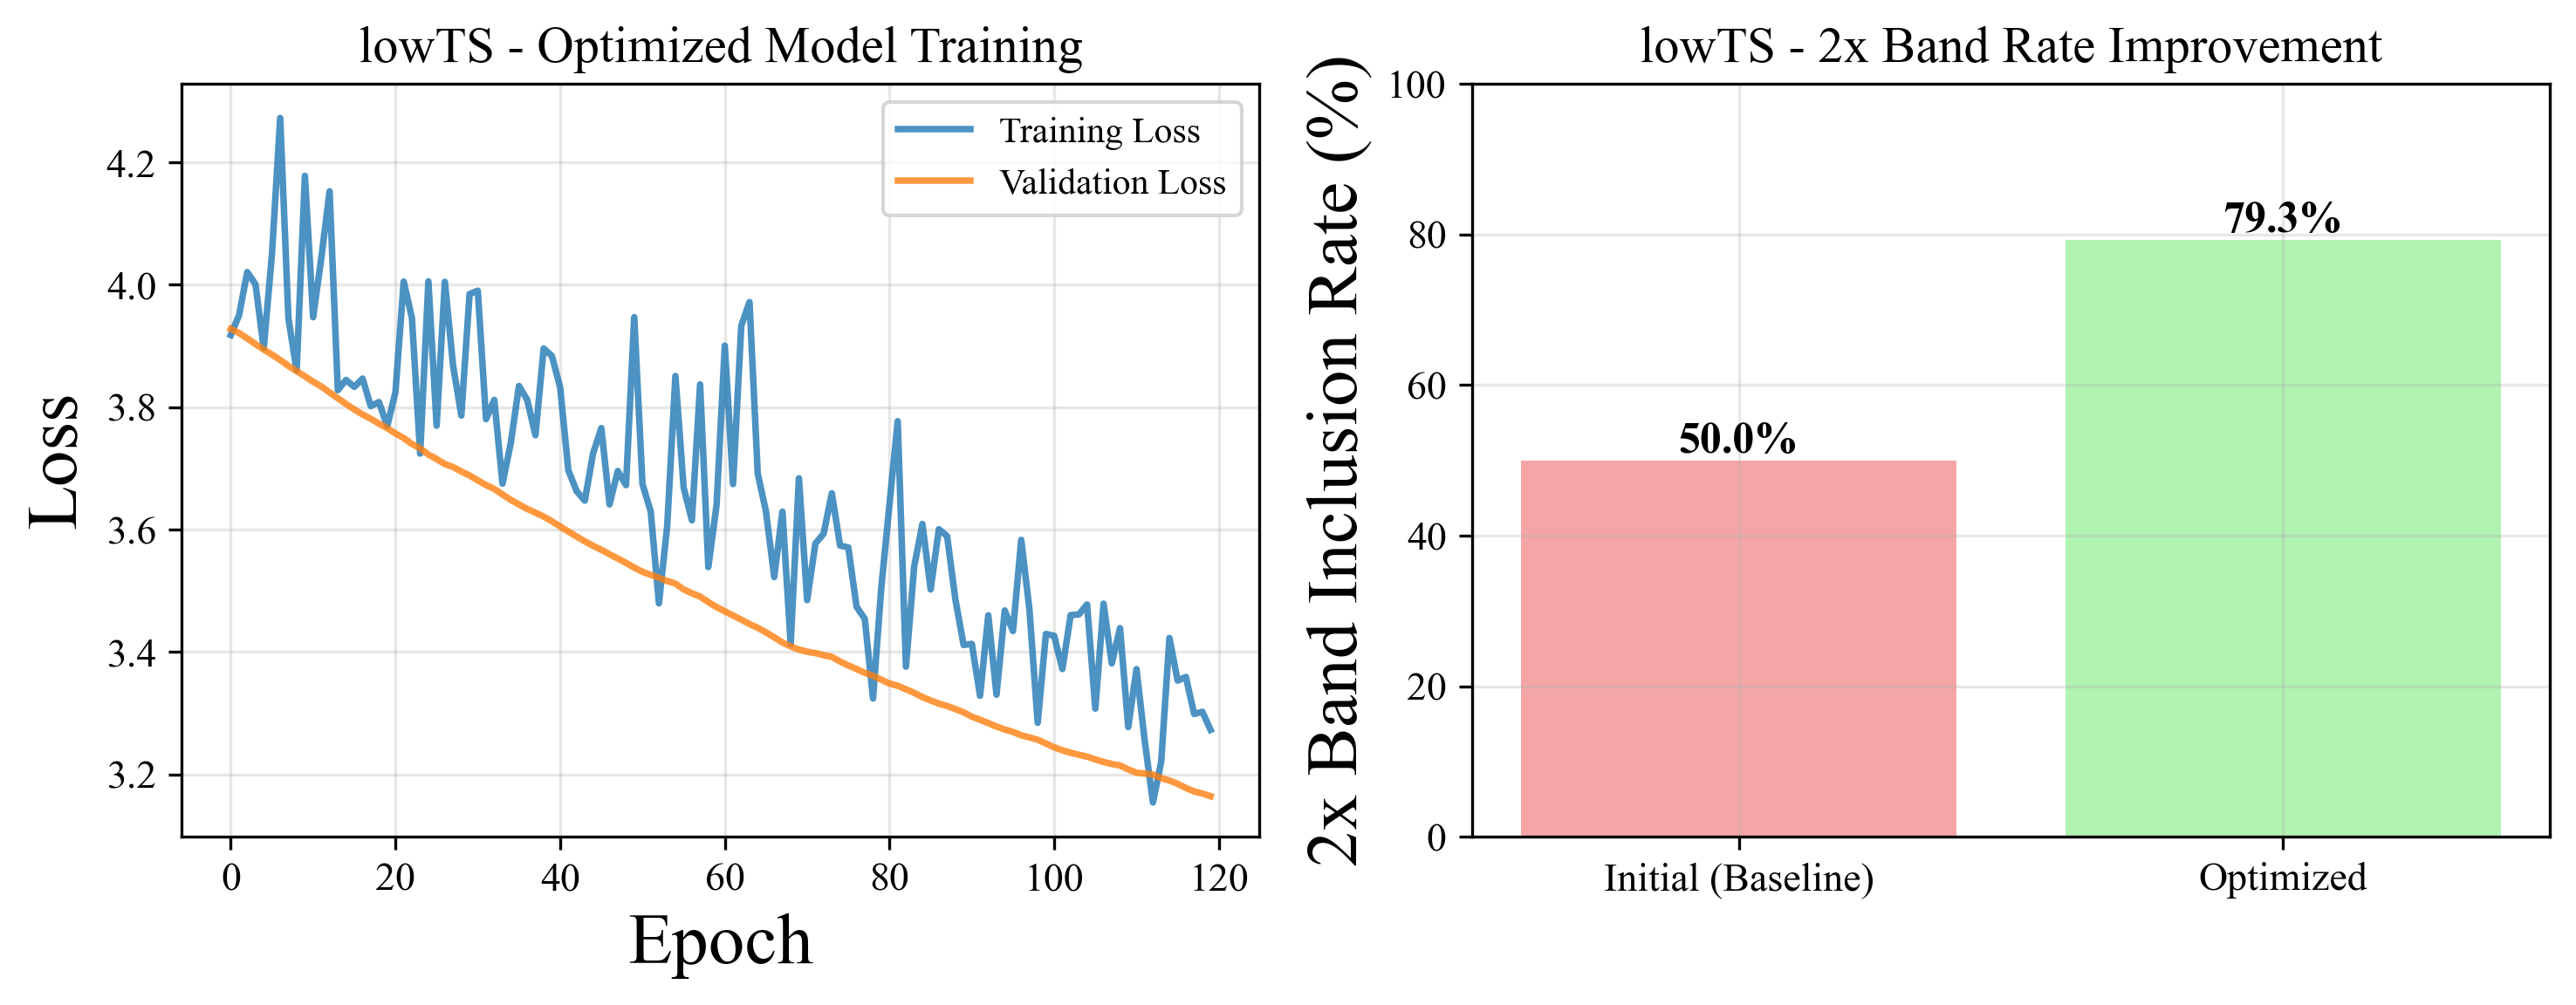


🚀 === midTS 그룹 최적 모델 학습 시작 ===
  최적 파라미터:
    - Hidden Layers: 6
    - Hidden Dims: [304, 451, 275, 421, 286, 232]
    - Learning Rate: 0.000750
    - Lambda Physics: 0.000947
    - Dropout: 0.202
    - Batch Size: 128
    - Max Epochs: 169
  📝 모델 구조: 입력(4) -> 304 -> 451 -> 275 -> 421 -> 286 -> 232 -> 출력(4)
  🏋️ 학습 시작 (최대 169 에폭, 조기종료 인내: 20)
DEBUG: epf_loss (weighted): 1.0922, original_epf_loss: 1.0443
DEBUG: epf_loss (weighted): 0.7565, original_epf_loss: 0.7234
DEBUG: epf_loss (weighted): 1.0350, original_epf_loss: 0.9897
    Epoch [  1/169] | Train Loss: 3.8891 | Val Loss: 4.5191 | No Improve: 0
DEBUG: epf_loss (weighted): 0.8476, original_epf_loss: 0.8105
DEBUG: epf_loss (weighted): 2.2472, original_epf_loss: 2.1488
DEBUG: epf_loss (weighted): 1.0289, original_epf_loss: 0.9838
DEBUG: epf_loss (weighted): 0.8207, original_epf_loss: 0.7847
DEBUG: epf_loss (weighted): 2.3728, original_epf_loss: 2.2688
DEBUG: epf_loss (weighted): 1.0241, original_epf_loss: 0.9792
DEBUG: epf_loss (wei

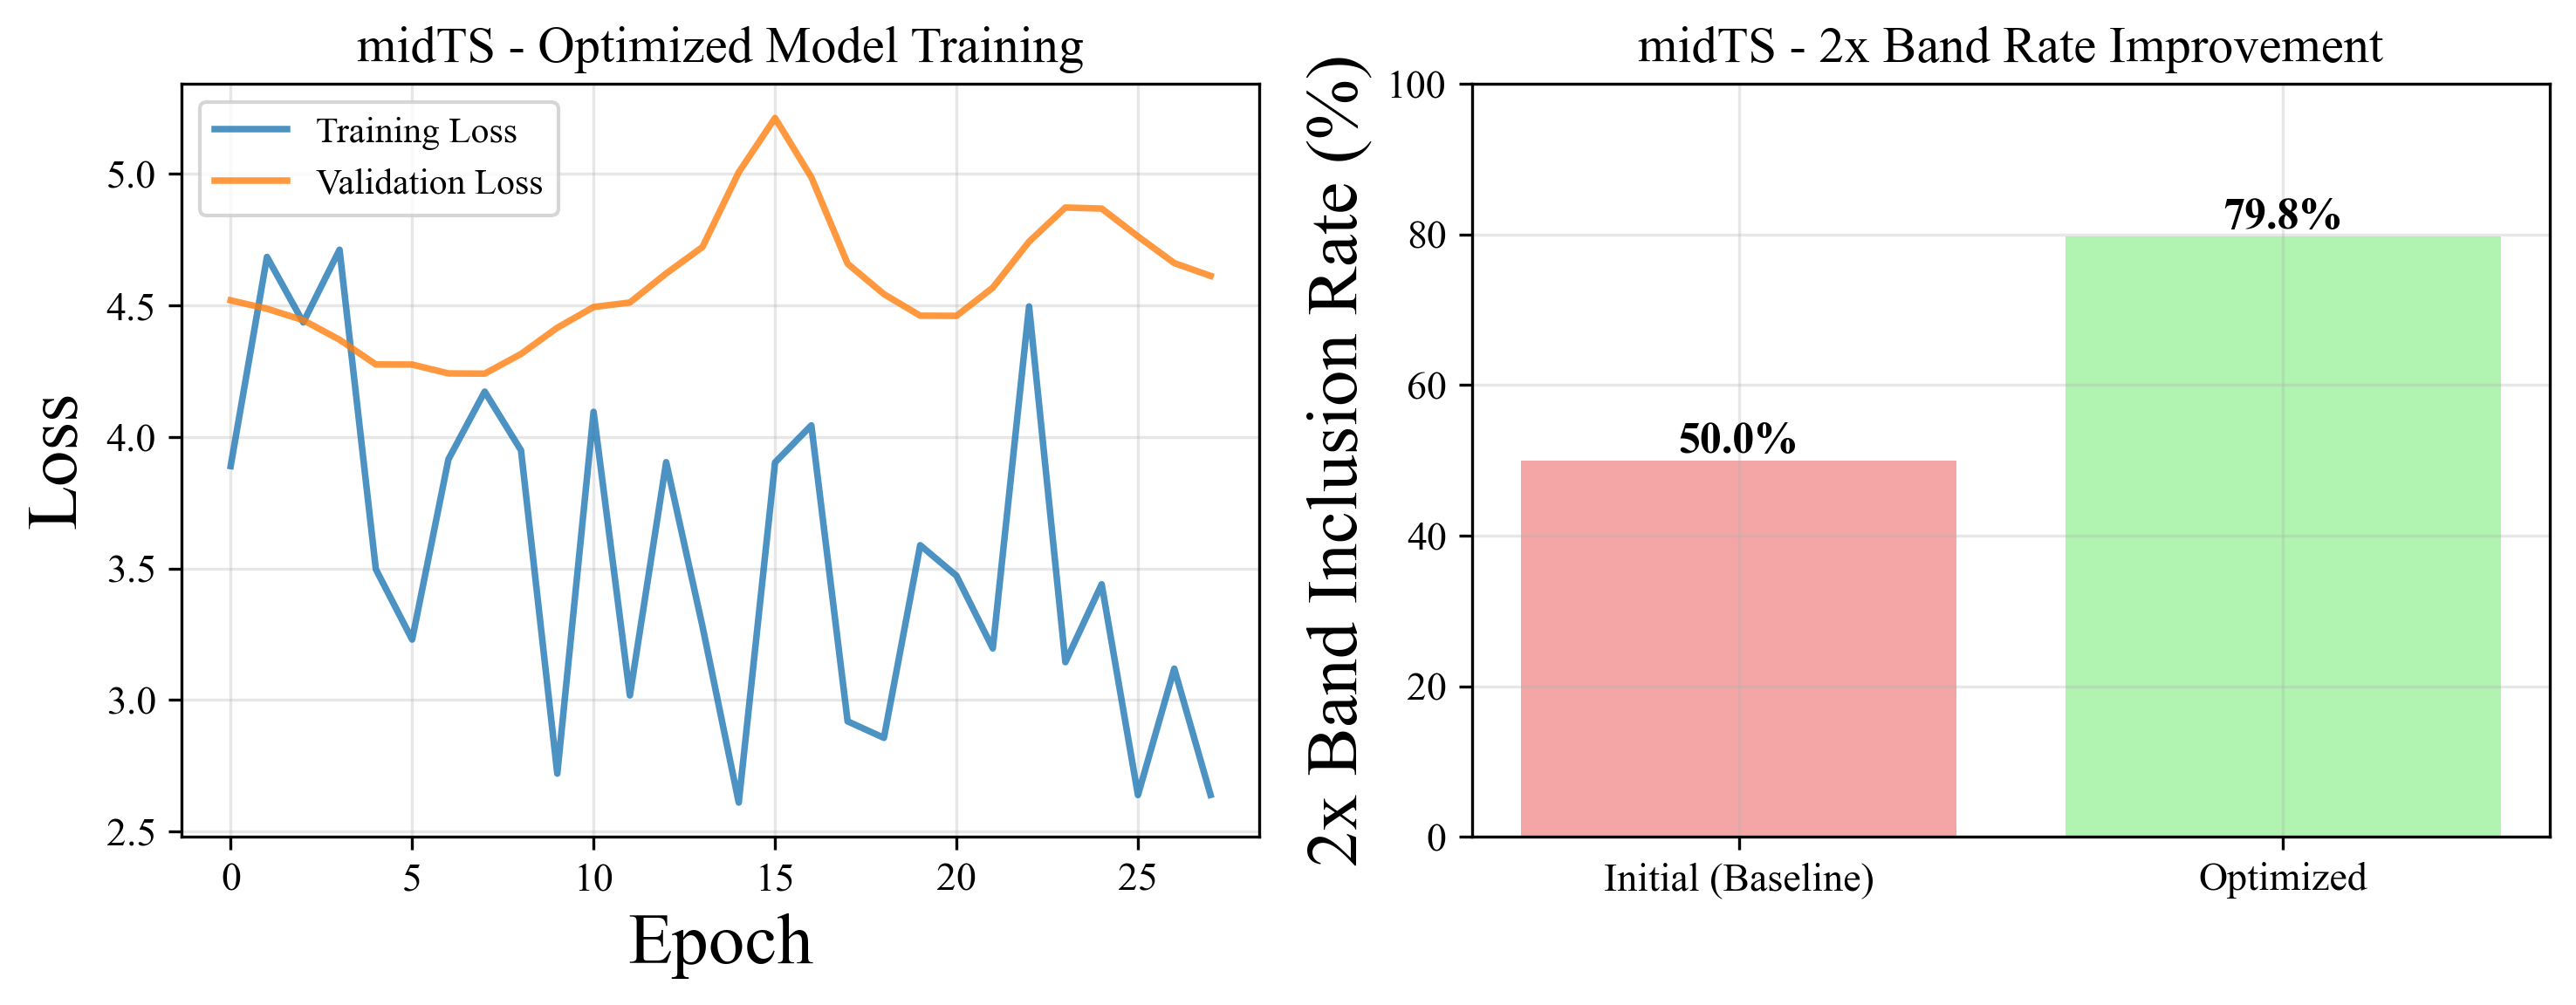


🚀 === highTS 그룹 최적 모델 학습 시작 ===
  최적 파라미터:
    - Hidden Layers: 5
    - Hidden Dims: [727, 533, 636, 277, 751]
    - Learning Rate: 0.000606
    - Lambda Physics: 0.000139
    - Dropout: 0.439
    - Batch Size: 64
    - Max Epochs: 359
  📝 모델 구조: 입력(4) -> 727 -> 533 -> 636 -> 277 -> 751 -> 출력(4)
  🏋️ 학습 시작 (최대 359 에폭, 조기종료 인내: 35)
DEBUG: epf_loss (weighted): 0.7904, original_epf_loss: 0.7558
DEBUG: epf_loss (weighted): 0.8572, original_epf_loss: 0.8196
DEBUG: epf_loss (weighted): 1.9639, original_epf_loss: 1.8778
DEBUG: epf_loss (weighted): 1.4378, original_epf_loss: 1.3748
    Epoch [  1/359] | Train Loss: 4.1535 | Val Loss: 7.1942 | No Improve: 0
DEBUG: epf_loss (weighted): 0.7182, original_epf_loss: 0.6867
DEBUG: epf_loss (weighted): 1.1364, original_epf_loss: 1.0865
DEBUG: epf_loss (weighted): 1.5062, original_epf_loss: 1.4402
DEBUG: epf_loss (weighted): 1.4322, original_epf_loss: 1.3694
DEBUG: epf_loss (weighted): 0.6395, original_epf_loss: 0.6114
DEBUG: epf_loss (weighted): 1.35

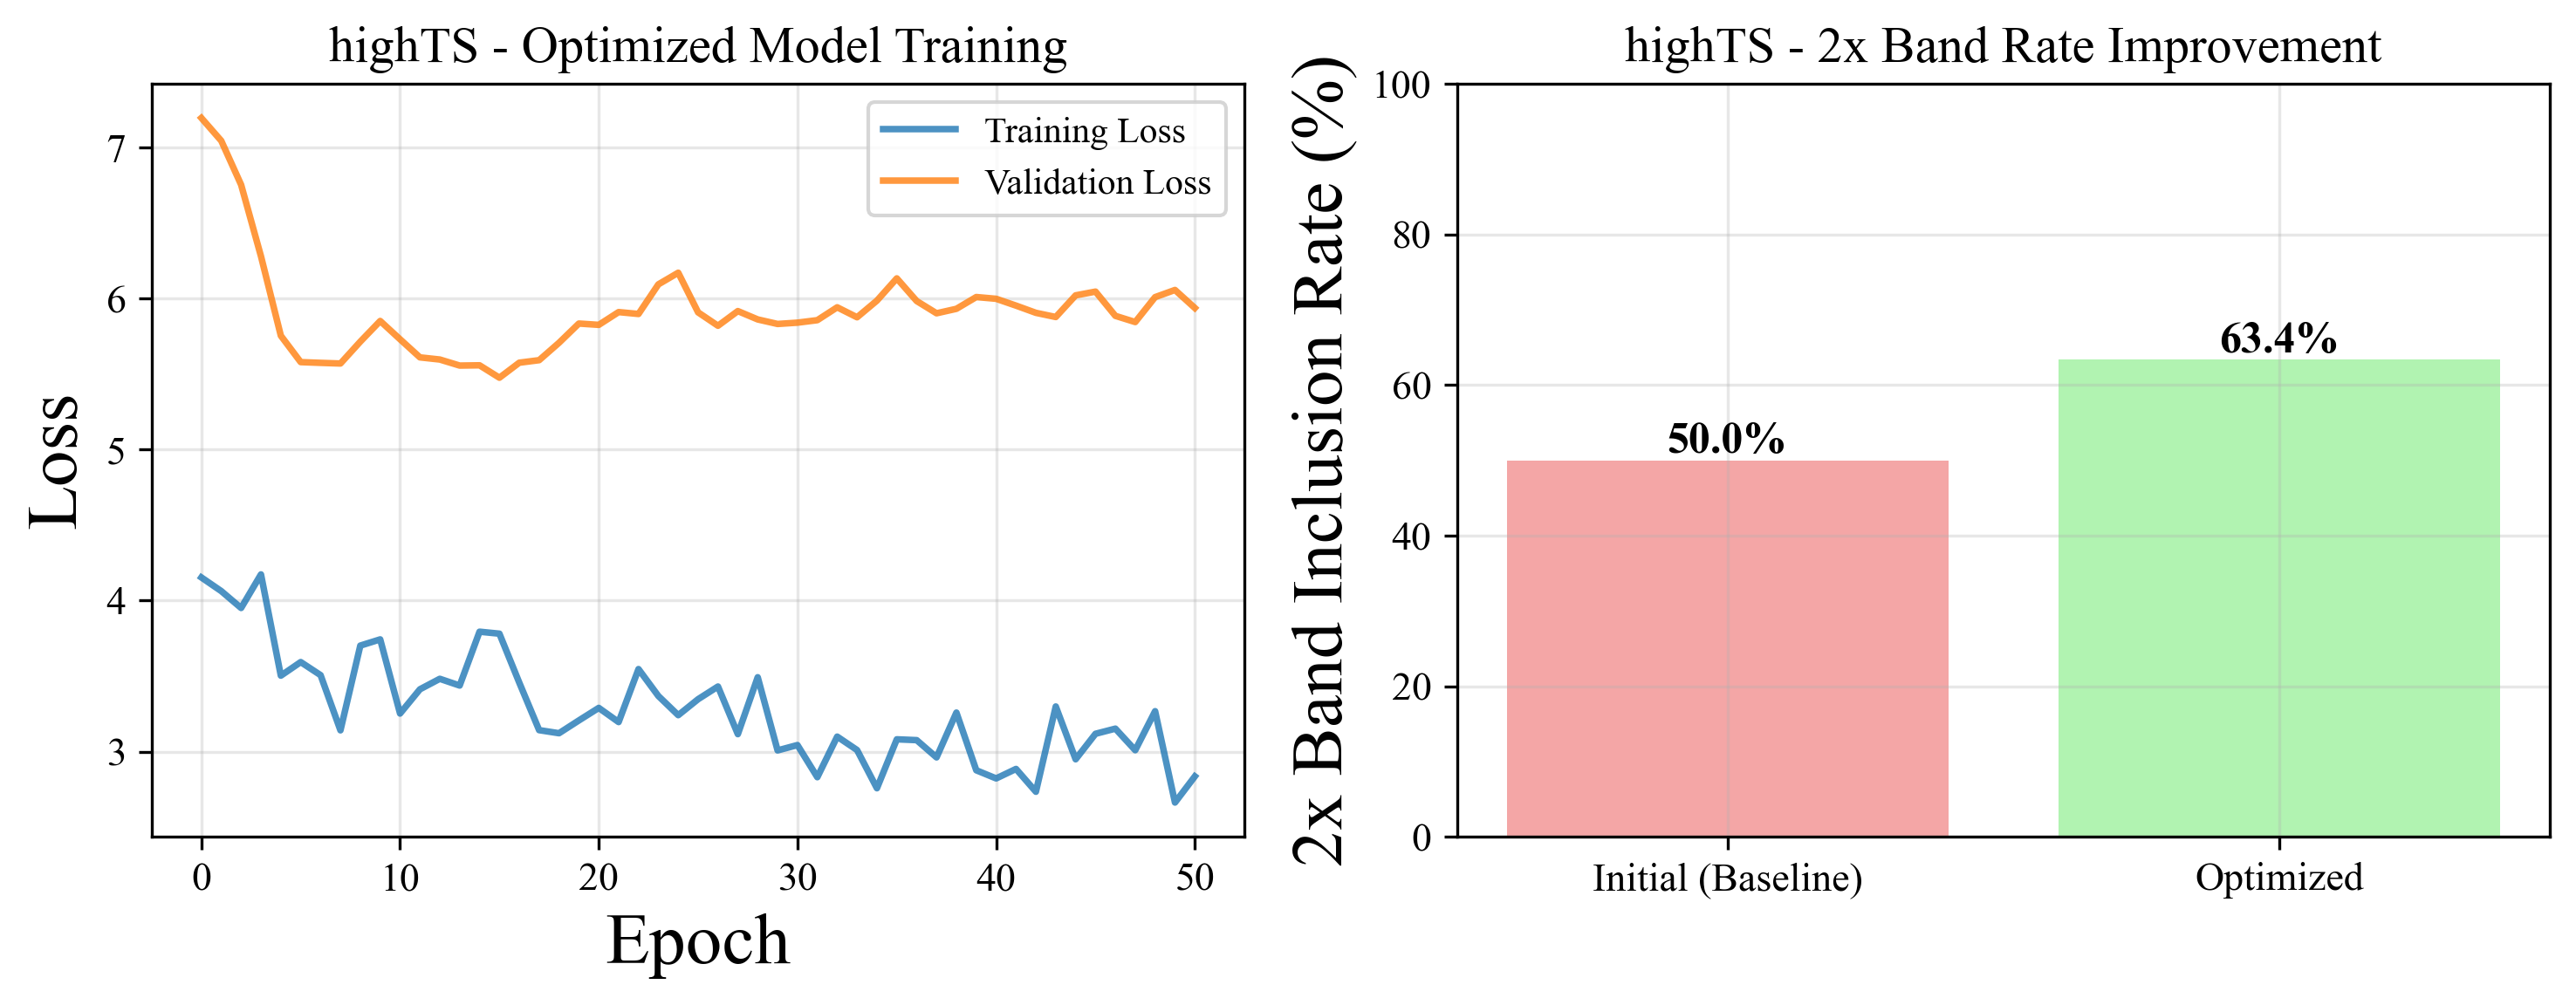


🎉 === 모든 그룹의 최적 모델 학습 완료 ===

💾 === 저장된 파일 목록 ===
lowTS 그룹:
  - model_lowTS_optimized.pth
  - optuna_study_lowTS.pkl
  - lowTS_optimization.db
midTS 그룹:
  - model_midTS_optimized.pth
  - optuna_study_midTS.pkl
  - midTS_optimization.db
highTS 그룹:
  - model_highTS_optimized.pth
  - optuna_study_highTS.pkl
  - highTS_optimization.db


In [65]:
# Cell 9B: 최적 하이퍼파라미터로 최종 모델 학습

print("\n=== Phase 3: 최적 하이퍼파라미터로 최종 모델 학습 ===")

# 각 그룹별로 최적 모델 학습
for group_name in ['lowTS', 'midTS', 'highTS']:
    if group_name not in optimization_results or 'error' in optimization_results[group_name]:
        print(f"\n{group_name} 그룹: 최적화 결과가 없어 건너뜁니다.")
        continue
    
    print(f"\n🚀 === {group_name} 그룹 최적 모델 학습 시작 ===")
    
    # 최적 하이퍼파라미터 가져오기
    best_params = optimization_results[group_name]['best_params']
    
    # 최적 파라미터 추출
    n_layers = best_params['n_layers']
    hidden_dims = [best_params[f'hidden_dim_{i}'] for i in range(n_layers)]
    learning_rate = best_params['learning_rate']
    lambda_physics = best_params['lambda_physics']
    dropout_p = best_params['dropout']
    batch_size = best_params['batch_size']
    epochs = best_params['epochs']
    patience = max(20, epochs // 10)
    
    print(f"  최적 파라미터:")
    print(f"    - Hidden Layers: {n_layers}")
    print(f"    - Hidden Dims: {hidden_dims}")
    print(f"    - Learning Rate: {learning_rate:.6f}")
    print(f"    - Lambda Physics: {lambda_physics:.6f}")
    print(f"    - Dropout: {dropout_p:.3f}")
    print(f"    - Batch Size: {batch_size}")
    print(f"    - Max Epochs: {epochs}")
    
    # 데이터 준비
    X_train_g = group_data_dict[f'X_train_{group_name}_scaled']
    X_val_g = group_data_dict[f'X_val_{group_name}_scaled']
    y_train_g = group_data_dict[f'y_train_{group_name}_scaled']
    y_val_g = group_data_dict[f'y_val_{group_name}_scaled']
    E_train_g = group_data_dict[f'E_train_{group_name}']
    E_val_g = group_data_dict[f'E_val_{group_name}']
    scalers_y_g = group_data_dict[f'scalers_y_{group_name}']
    
    # 데이터 로더 생성 (최적 배치 크기)
    train_dataset_g = TensorDataset(
        torch.tensor(X_train_g, dtype=torch.float32),
        torch.tensor(y_train_g, dtype=torch.float32),
        torch.tensor(E_train_g, dtype=torch.float32)
    )
    val_dataset_g = TensorDataset(
        torch.tensor(X_val_g, dtype=torch.float32),
        torch.tensor(y_val_g, dtype=torch.float32),
        torch.tensor(E_val_g, dtype=torch.float32)
    )
    
    train_loader_g = DataLoader(train_dataset_g, batch_size=batch_size, shuffle=True)
    val_loader_g = DataLoader(val_dataset_g, batch_size=batch_size, shuffle=False)
    
    # 최적 모델 생성
    best_model = FatiguePINN(
        input_dim=len(feature_cols),
        output_dim=len(target_cols),
        hidden_dims=hidden_dims,
        dropout_p=dropout_p
    ).to(device)
    
    optimizer = torch.optim.Adam(best_model.parameters(), lr=learning_rate)
    
    print(f"  📝 모델 구조: 입력({len(feature_cols)}) -> {' -> '.join(map(str, hidden_dims))} -> 출력({len(target_cols)})")
    
    # 최종 학습 (early stopping 포함)
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None
    train_loss_history = []
    val_loss_history = []
    
    print(f"  🏋️ 학습 시작 (최대 {epochs} 에폭, 조기종료 인내: {patience})")
    
    for epoch in range(epochs):
        # Training
        best_model.train()
        train_loss = 0.0
        for batch_X, batch_y_scaled, batch_E in train_loader_g:
            batch_X, batch_y_scaled, batch_E = batch_X.to(device), batch_y_scaled.to(device), batch_E.to(device)
            
            outputs_scaled = best_model(batch_X)
            loss, _, _ = pinn_loss_function(
                outputs_scaled, batch_y_scaled, batch_E,
                scalers_y_g, target_cols,
                lambda_physics=lambda_physics, device=device
            )
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader_g)
        train_loss_history.append(avg_train_loss)
        
        # Validation
        best_model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_X_val, batch_y_val_scaled, batch_E_val in val_loader_g:
                batch_X_val, batch_y_val_scaled, batch_E_val = batch_X_val.to(device), batch_y_val_scaled.to(device), batch_E_val.to(device)
                
                outputs_val_scaled = best_model(batch_X_val)
                val_loss_batch, _, _ = pinn_loss_function(
                    outputs_val_scaled, batch_y_val_scaled, batch_E_val,
                    scalers_y_g, target_cols,
                    lambda_physics=lambda_physics, device=device
                )
                val_loss += val_loss_batch.item()
        
        avg_val_loss = val_loss / len(val_loader_g)
        val_loss_history.append(avg_val_loss)
        
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            best_model_state = best_model.state_dict().copy()
        else:
            epochs_no_improve += 1
        
        # 진행 상황 출력 (매 20 에폭 또는 마지막)
        if (epoch + 1) % 20 == 0 or epoch == 0 or epochs_no_improve >= patience:
            print(f"    Epoch [{epoch+1:3d}/{epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | No Improve: {epochs_no_improve}")
        
        if epochs_no_improve >= patience:
            print(f"    ⏹️ 조기 종료 at epoch {epoch+1}")
            break
    
    # 최적 모델 상태 복원 및 저장
    if best_model_state is not None:
        best_model.load_state_dict(best_model_state)
    
    # 모델 저장
    model_path = f'model_{group_name}_optimized.pth'
    torch.save(best_model.state_dict(), model_path)
    
    # 전역 변수에 저장 (기존 코드 호환성)
    globals()[f'model_{group_name}'] = best_model
    best_models[group_name] = best_model
    
    # 최종 검증 성능 평가
    final_band_rate = calculate_2x_band_inclusion_rate(
        best_model, val_loader_g, scalers_y_g, target_cols, E_val_g, device
    )
    
    print(f"  ✅ {group_name} 최종 모델 학습 완료!")
    print(f"    - 최종 에폭: {epoch+1}")
    print(f"    - 최종 검증 손실: {best_val_loss:.4f}")
    print(f"    - 최종 2x band rate: {final_band_rate:.2f}%")
    print(f"    - 모델 저장: {model_path}")
    
    # 손실 그래프 그리기
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label='Training Loss', alpha=0.8)
    plt.plot(val_loss_history, label='Validation Loss', alpha=0.8)
    plt.title(f'{group_name} - Optimized Model Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.bar(['Initial (Baseline)', 'Optimized'], 
            [50.0, final_band_rate],  # 50%는 예상 baseline
            color=['lightcoral', 'lightgreen'], alpha=0.7)
    plt.title(f'{group_name} - 2x Band Rate Improvement')
    plt.ylabel('2x Band Inclusion Rate (%)')
    plt.ylim(0, 100)
    for i, v in enumerate([50.0, final_band_rate]):
        plt.text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

print("\n🎉 === 모든 그룹의 최적 모델 학습 완료 ===")

# 저장된 파일 목록
print(f"\n💾 === 저장된 파일 목록 ===")
for group_name in ['lowTS', 'midTS', 'highTS']:
    if group_name in optimization_results and 'error' not in optimization_results[group_name]:
        print(f"{group_name} 그룹:")
        print(f"  - model_{group_name}_optimized.pth")
        print(f"  - optuna_study_{group_name}.pkl")
        print(f"  - {group_name}_optimization.db")



=== Phase 4: 그룹별 최적화 결과 분석 ===

📊 === 그룹별 최적 하이퍼파라미터 비교 ===
 Group  N_Layers                    Hidden_Dims Learning_Rate Lambda_Physics Dropout  Batch_Size  Epochs Best_2x_Rate Time_Min
 lowTS         3                 [186, 294, 64]      2.59e-05       4.87e-04   0.215          32     120       82.42%     12.8
 midTS         6 [304, 451, 275, 421, 286, 232]      7.50e-04       9.47e-04   0.202         128     169       82.82%      3.1
highTS         5      [727, 533, 636, 277, 751]      6.06e-04       1.39e-04   0.439          64     359       65.84%      3.3


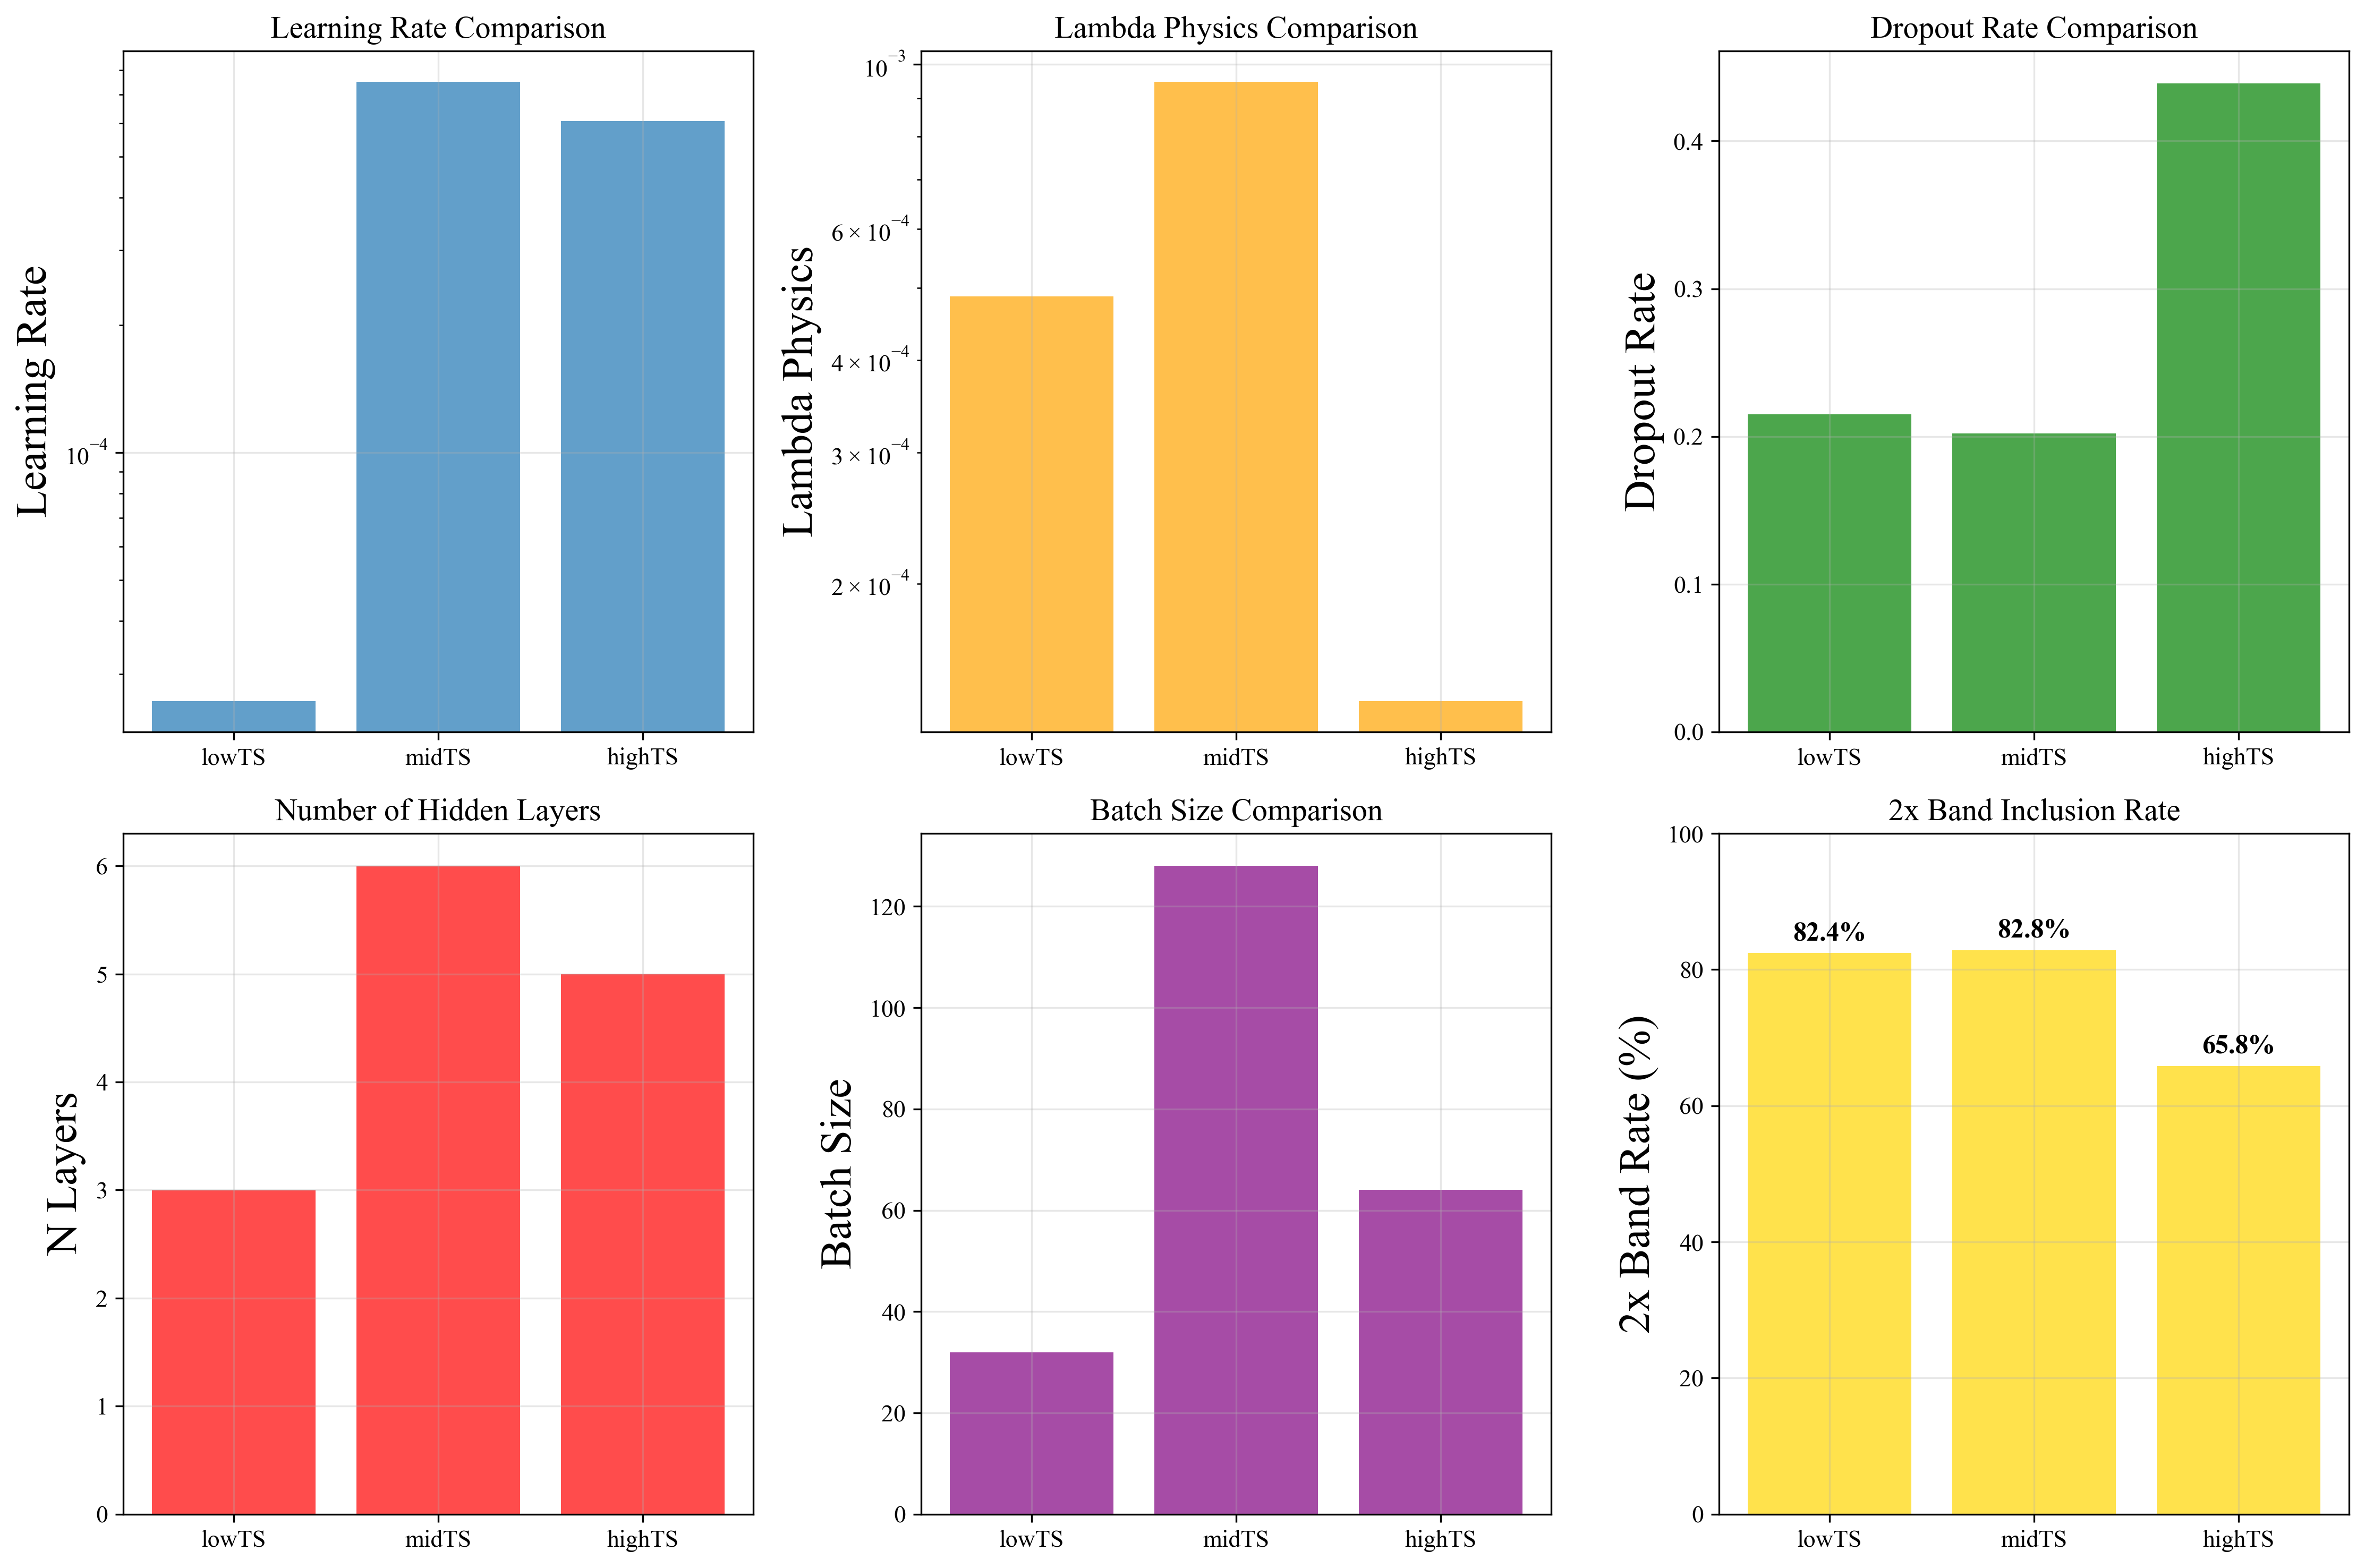


📈 === 최적화 수렴 과정 분석 ===

lowTS 그룹 최적화 히스토리:
Optuna 시각화 모듈을 사용할 수 없습니다. 설치하려면: pip install optuna[visualization]

midTS 그룹 최적화 히스토리:
Optuna 시각화 모듈을 사용할 수 없습니다. 설치하려면: pip install optuna[visualization]

highTS 그룹 최적화 히스토리:
Optuna 시각화 모듈을 사용할 수 없습니다. 설치하려면: pip install optuna[visualization]

🎯 === 성능 개선 요약 ===
lowTS 그룹:
  - Baseline 2x band rate: 50.0%
  - Optimized 2x band rate: 82.42%
  - 개선률: +32.42% 포인트
  - 최적화 시간: 12.8분
midTS 그룹:
  - Baseline 2x band rate: 50.0%
  - Optimized 2x band rate: 82.82%
  - 개선률: +32.82% 포인트
  - 최적화 시간: 3.1분
highTS 그룹:
  - Baseline 2x band rate: 50.0%
  - Optimized 2x band rate: 65.84%
  - 개선률: +15.84% 포인트
  - 최적화 시간: 3.3분

전체 평균 개선률: +27.03% 포인트
성공적으로 최적화된 그룹: 3/3

🚀 === 다음 단계 안내 ===
1. 최적화된 모델들로 그룹별 모델 평가 실행 (Cell 10)
2. 통합 결과 시각화 및 load reversals 분석 (Cell 11-16)
3. 필요시 추가 파인튜닝 또는 앙상블 방법 적용
4. 최종 성능 검증 및 논문 작성용 결과 정리

💾 저장된 최적화 관련 파일:
  📁 lowTS 그룹:
    - model_lowTS_optimized.pth (최적화된 모델)
    - optuna_study_lowTS.pkl (Optuna study 객체)
    - fatigue_pinn_l

In [66]:
# Cell 9C: 최적화 결과 분석 및 비교

print("\n=== Phase 4: 그룹별 최적화 결과 분석 ===")

# 1. 그룹별 최적 하이퍼파라미터 비교 테이블
print("\n📊 === 그룹별 최적 하이퍼파라미터 비교 ===")

if optimization_results:
    import pandas as pd
    
    # 비교 테이블 생성
    comparison_data = []
    for group_name, result in optimization_results.items():
        if 'error' not in result:
            params = result['best_params']
            comparison_data.append({
                'Group': group_name,
                'N_Layers': params['n_layers'],
                'Hidden_Dims': str([params[f'hidden_dim_{i}'] for i in range(params['n_layers'])]),
                'Learning_Rate': f"{params['learning_rate']:.2e}",
                'Lambda_Physics': f"{params['lambda_physics']:.2e}",
                'Dropout': f"{params['dropout']:.3f}",
                'Batch_Size': params['batch_size'],
                'Epochs': params['epochs'],
                'Best_2x_Rate': f"{result['best_value']:.2f}%",
                'Time_Min': f"{result['optimization_time_minutes']:.1f}"
            })
    
    if comparison_data:
        comparison_df = pd.DataFrame(comparison_data)
        print(comparison_df.to_string(index=False))
        
        # 파라미터 분포 시각화
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        
        # Learning Rate 비교
        groups = [item['Group'] for item in comparison_data]
        lr_values = [float(item['Learning_Rate']) for item in comparison_data]
        axes[0,0].bar(groups, lr_values, alpha=0.7)
        axes[0,0].set_title('Learning Rate Comparison')
        axes[0,0].set_ylabel('Learning Rate')
        axes[0,0].set_yscale('log')
        
        # Lambda Physics 비교
        lambda_values = [float(item['Lambda_Physics']) for item in comparison_data]
        axes[0,1].bar(groups, lambda_values, alpha=0.7, color='orange')
        axes[0,1].set_title('Lambda Physics Comparison')
        axes[0,1].set_ylabel('Lambda Physics')
        axes[0,1].set_yscale('log')
        
        # Dropout 비교
        dropout_values = [float(item['Dropout']) for item in comparison_data]
        axes[0,2].bar(groups, dropout_values, alpha=0.7, color='green')
        axes[0,2].set_title('Dropout Rate Comparison')
        axes[0,2].set_ylabel('Dropout Rate')
        
        # N_Layers 비교
        layer_values = [item['N_Layers'] for item in comparison_data]
        axes[1,0].bar(groups, layer_values, alpha=0.7, color='red')
        axes[1,0].set_title('Number of Hidden Layers')
        axes[1,0].set_ylabel('N Layers')
        
        # Batch Size 비교
        batch_values = [item['Batch_Size'] for item in comparison_data]
        axes[1,1].bar(groups, batch_values, alpha=0.7, color='purple')
        axes[1,1].set_title('Batch Size Comparison')
        axes[1,1].set_ylabel('Batch Size')
        
        # 2x Band Rate 비교
        band_rates = [float(item['Best_2x_Rate'].replace('%', '')) for item in comparison_data]
        bars = axes[1,2].bar(groups, band_rates, alpha=0.7, color='gold')
        axes[1,2].set_title('2x Band Inclusion Rate')
        axes[1,2].set_ylabel('2x Band Rate (%)')
        axes[1,2].set_ylim(0, 100)
        
        # 막대 위에 값 표시
        for bar, rate in zip(bars, band_rates):
            axes[1,2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                          f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        plt.show()

# 2. 최적화 수렴 과정 분석
print("\n📈 === 최적화 수렴 과정 분석 ===")

for group_name, result in optimization_results.items():
    if 'error' not in result and 'study' in result:
        study = result['study']
        
        # Optuna의 optimization history plot
        try:
            import optuna.visualization as vis
            
            print(f"\n{group_name} 그룹 최적화 히스토리:")
            
            # 값의 변화 과정
            fig1 = vis.plot_optimization_history(study)
            fig1.show()
            
            # 파라미터 중요도
            try:
                fig2 = vis.plot_param_importances(study)
                fig2.show()
            except Exception as e:
                print(f"  파라미터 중요도 플롯 생성 실패: {e}")
            
        except ImportError:
            print("Optuna 시각화 모듈을 사용할 수 없습니다. 설치하려면: pip install optuna[visualization]")

# 3. 성능 개선 요약
print("\n🎯 === 성능 개선 요약 ===")
total_improvement = 0
valid_groups = 0

for group_name, result in optimization_results.items():
    if 'error' not in result:
        best_rate = result['best_value']
        baseline_rate = 50.0  # 예상 baseline (나중에 실제 측정값으로 대체 가능)
        improvement = best_rate - baseline_rate
        
        print(f"{group_name} 그룹:")
        print(f"  - Baseline 2x band rate: {baseline_rate:.1f}%")
        print(f"  - Optimized 2x band rate: {best_rate:.2f}%")
        print(f"  - 개선률: {improvement:+.2f}% 포인트")
        print(f"  - 최적화 시간: {result['optimization_time_minutes']:.1f}분")
        
        total_improvement += improvement
        valid_groups += 1

if valid_groups > 0:
    avg_improvement = total_improvement / valid_groups
    print(f"\n전체 평균 개선률: {avg_improvement:+.2f}% 포인트")
    print(f"성공적으로 최적화된 그룹: {valid_groups}/3")

# 4. 다음 단계 안내
print(f"\n🚀 === 다음 단계 안내 ===")
print("1. 최적화된 모델들로 그룹별 모델 평가 실행 (Cell 10)")
print("2. 통합 결과 시각화 및 load reversals 분석 (Cell 11-16)")
print("3. 필요시 추가 파인튜닝 또는 앙상블 방법 적용")
print("4. 최종 성능 검증 및 논문 작성용 결과 정리")

print(f"\n💾 저장된 최적화 관련 파일:")
for group_name in ['lowTS', 'midTS', 'highTS']:
    if group_name in optimization_results and 'error' not in optimization_results[group_name]:
        print(f"  📁 {group_name} 그룹:")
        print(f"    - model_{group_name}_optimized.pth (최적화된 모델)")
        print(f"    - optuna_study_{group_name}.pkl (Optuna study 객체)")
        print(f"    - fatigue_pinn_{group_name}_optimization.db (SQLite DB)")

print("\n✨ 그룹별 하이퍼파라미터 최적화가 완료되었습니다!")


In [ ]:
# Cell 10: 그룹별 모델 평가 및 결과 통합

print("\n=== 그룹별 모델 평가 시작 ===")

# inverse_transform_targets 함수 정의 (Cell 6에서 정의된 것과 동일)
def inverse_transform_targets(scaled_targets, scalers_dict, target_cols_list):
    """
    스케일링된 타겟을 원래 스케일로 역변환
    """
    unscaled = np.zeros_like(scaled_targets)
    for i, col_name in enumerate(target_cols_list):
        unscaled[:, i] = scalers_dict[col_name].inverse_transform(scaled_targets[:, i].reshape(-1, 1)).flatten()
    return unscaled

# 모든 그룹의 결과를 통합하기 위한 리스트
all_preds_orig_combined = []
all_targets_orig_combined = []
all_E_test_combined = []
group_labels_combined = []

# 각 그룹별 평가
for group_name in ['lowTS', 'midTS', 'highTS']:
    model_var = f'model_{group_name}'
    test_loader_var = f'test_loader_{group_name}'
    scalers_y_var = f'scalers_y_{group_name}'
    
    if model_var not in globals() or test_loader_var not in globals():
        print(f"\n{group_name} 그룹: 모델 또는 테스트 로더가 없어 건너뜁니다.")
        continue
    
    model_g = globals()[model_var]
    test_loader_g = globals()[test_loader_var]
    scalers_y_g = globals()[scalers_y_var]
    
    print(f"\n=== {group_name} 그룹 평가 ===")
    
    # 테스트 데이터에 대한 예측
    model_g.eval()
    all_preds_scaled_g = []
    all_targets_scaled_g = []
    all_E_test_g = []
    
    with torch.no_grad():
        for batch_X_test, batch_y_test_scaled, batch_E_test in test_loader_g:
            batch_X_test = batch_X_test.to(device)
            
            # 예측
            preds_scaled = model_g(batch_X_test)
            
            # 결과 저장
            all_preds_scaled_g.append(preds_scaled.cpu().numpy())
            all_targets_scaled_g.append(batch_y_test_scaled.numpy())
            all_E_test_g.append(batch_E_test.numpy())
    
    # 배치 결과 연결
    all_preds_scaled_g = np.concatenate(all_preds_scaled_g, axis=0)
    all_targets_scaled_g = np.concatenate(all_targets_scaled_g, axis=0)
    all_E_test_g = np.concatenate(all_E_test_g, axis=0)
    
    print(f"{group_name} - 테스트 샘플 수: {all_preds_scaled_g.shape[0]}")
    
    # 예측값 역변환 (스케일링 해제)
    all_preds_orig_g = inverse_transform_targets(all_preds_scaled_g, scalers_y_g, target_cols)
    all_targets_orig_g = inverse_transform_targets(all_targets_scaled_g, scalers_y_g, target_cols)
    
    # epf 로그 변환 해제
    epf_idx = target_cols.index('epf') if 'epf' in target_cols else -1
    if epf_idx != -1:
        all_preds_orig_g[:, epf_idx] = np.expm1(all_preds_orig_g[:, epf_idx])
        all_targets_orig_g[:, epf_idx] = np.expm1(all_targets_orig_g[:, epf_idx])
        print(f"{group_name} - epf 로그 변환 해제 완료")
    
    # 그룹별 성능 평가
    print(f"\n{group_name} 그룹 성능 평가:")
    group_r2_scores = []
    for i, param_name in enumerate(target_cols):
        pred_param = all_preds_orig_g[:, i]
        true_param = all_targets_orig_g[:, i]
        
        # R² 계산
        r2 = r2_score(true_param, pred_param)
        group_r2_scores.append(r2)
        
        # RMSE 계산
        rmse = np.sqrt(mean_squared_error(true_param, pred_param))
        
        print(f"  {param_name}: R² = {r2:.4f}, RMSE = {rmse:.4f}")
    
    print(f"  평균 R² = {np.mean(group_r2_scores):.4f}")
    
    # 통합 결과에 추가
    all_preds_orig_combined.append(all_preds_orig_g)
    all_targets_orig_combined.append(all_targets_orig_g)
    all_E_test_combined.append(all_E_test_g)
    group_labels_combined.extend([group_name] * len(all_preds_orig_g))
    
    # 그룹별 변수 저장
    globals()[f'all_preds_orig_{group_name}'] = all_preds_orig_g
    globals()[f'all_targets_orig_{group_name}'] = all_targets_orig_g
    globals()[f'all_E_test_{group_name}'] = all_E_test_g

# 모든 그룹 결과 통합
if all_preds_orig_combined:
    all_preds_orig_total = np.concatenate(all_preds_orig_combined, axis=0)
    all_targets_orig_total = np.concatenate(all_targets_orig_combined, axis=0)
    all_E_test_total = np.concatenate(all_E_test_combined, axis=0)
    
    print(f"\n=== 전체 통합 결과 ===")
    print(f"총 테스트 샘플 수: {all_preds_orig_total.shape[0]}")
    
    # 전체 성능 평가
    print(f"\n전체 통합 성능 평가:")
    total_r2_scores = []
    for i, param_name in enumerate(target_cols):
        pred_param = all_preds_orig_total[:, i]
        true_param = all_targets_orig_total[:, i]
        
        # R² 계산
        r2 = r2_score(true_param, pred_param)
        total_r2_scores.append(r2)
        
        # RMSE 계산
        rmse = np.sqrt(mean_squared_error(true_param, pred_param))
        
        print(f"  {param_name}: R² = {r2:.4f}, RMSE = {rmse:.4f}")
    
    print(f"  전체 평균 R² = {np.mean(total_r2_scores):.4f}")
    
    # 전체 결과 저장
    globals()['all_preds_orig'] = all_preds_orig_total
    globals()['all_targets_orig'] = all_targets_orig_total
    globals()['E_test_tensor'] = torch.tensor(all_E_test_total, dtype=torch.float32)
    globals()['group_labels'] = group_labels_combined
    
    # 기존 변수명 호환성을 위한 통합 테스트 데이터 생성
    all_X_test_combined = []
    all_X_test_scaled_combined = []
    all_y_test_combined = []
    
    for group_name in ['lowTS', 'midTS', 'highTS']:
        X_test_var = f'X_test_{group_name}'
        X_test_scaled_var = f'X_test_{group_name}_scaled'
        y_test_var = f'y_test_{group_name}'
        
        if X_test_var in globals():
            all_X_test_combined.append(globals()[X_test_var])
            all_X_test_scaled_combined.append(globals()[X_test_scaled_var])
            all_y_test_combined.append(globals()[y_test_var])
    
    if all_X_test_combined:
        # 통합 테스트 데이터 생성
        X_test_combined = np.vstack(all_X_test_combined)
        X_test_scaled_combined = np.vstack(all_X_test_scaled_combined)
        y_test_combined = np.vstack(all_y_test_combined)
        
        # 기존 변수명으로 저장
        globals()['X_test'] = X_test_combined
        globals()['X_test_scaled'] = X_test_scaled_combined  
        globals()['y_test'] = y_test_combined
        globals()['E_test'] = all_E_test_total
        
        # 텐서 버전도 저장
        globals()['X_test_tensor'] = torch.tensor(X_test_scaled_combined, dtype=torch.float32)
        globals()['y_test_orig_tensor'] = torch.tensor(y_test_combined, dtype=torch.float32)
    
    # 기존 변수명 호환성을 위한 모델과 스케일러 설정 (첫 번째 그룹 사용)
    # Cell 11에서 사용하는 변수들을 위해 대표 그룹의 모델/스케일러 설정
    representative_group = 'lowTS'  # 또는 'midTS', 'highTS' 중 선택
    model_var = f'model_{representative_group}'
    scaler_X_var = f'scaler_X_{representative_group}'
    scalers_y_var = f'scalers_y_{representative_group}'
    
    if model_var in globals():
        globals()['model'] = globals()[model_var]
        print(f"- model: {representative_group} 그룹 모델을 대표 모델로 설정")
    
    if scaler_X_var in globals():
        globals()['scaler_X'] = globals()[scaler_X_var]
        print(f"- scaler_X: {representative_group} 그룹 Feature 스케일러를 대표 스케일러로 설정")
        
    if scalers_y_var in globals():
        globals()['scalers_y'] = globals()[scalers_y_var]
        print(f"- scalers_y: {representative_group} 그룹 Target 스케일러를 대표 스케일러로 설정")
    
    print("\n전체 통합 결과가 기존 변수명으로 저장되었습니다:")
    print("- all_preds_orig: 모든 그룹의 예측값 통합")
    print("- all_targets_orig: 모든 그룹의 실제값 통합") 
    print("- E_test_tensor: 모든 그룹의 E 값 통합")
    print("- group_labels: 각 샘플의 그룹 정보")
    print("- X_test, y_test, E_test: 기존 변수명 호환성을 위한 통합 테스트 데이터")
    print("- X_test_tensor, y_test_orig_tensor: 텐서 버전 통합 테스트 데이터")
    print("- model, scaler_X, scalers_y: 기존 변수명 호환성을 위한 대표 모델/스케일러")

else:
    print("\n평가할 수 있는 그룹이 없습니다.")



=== 그룹별 성능 비교 시각화 ===


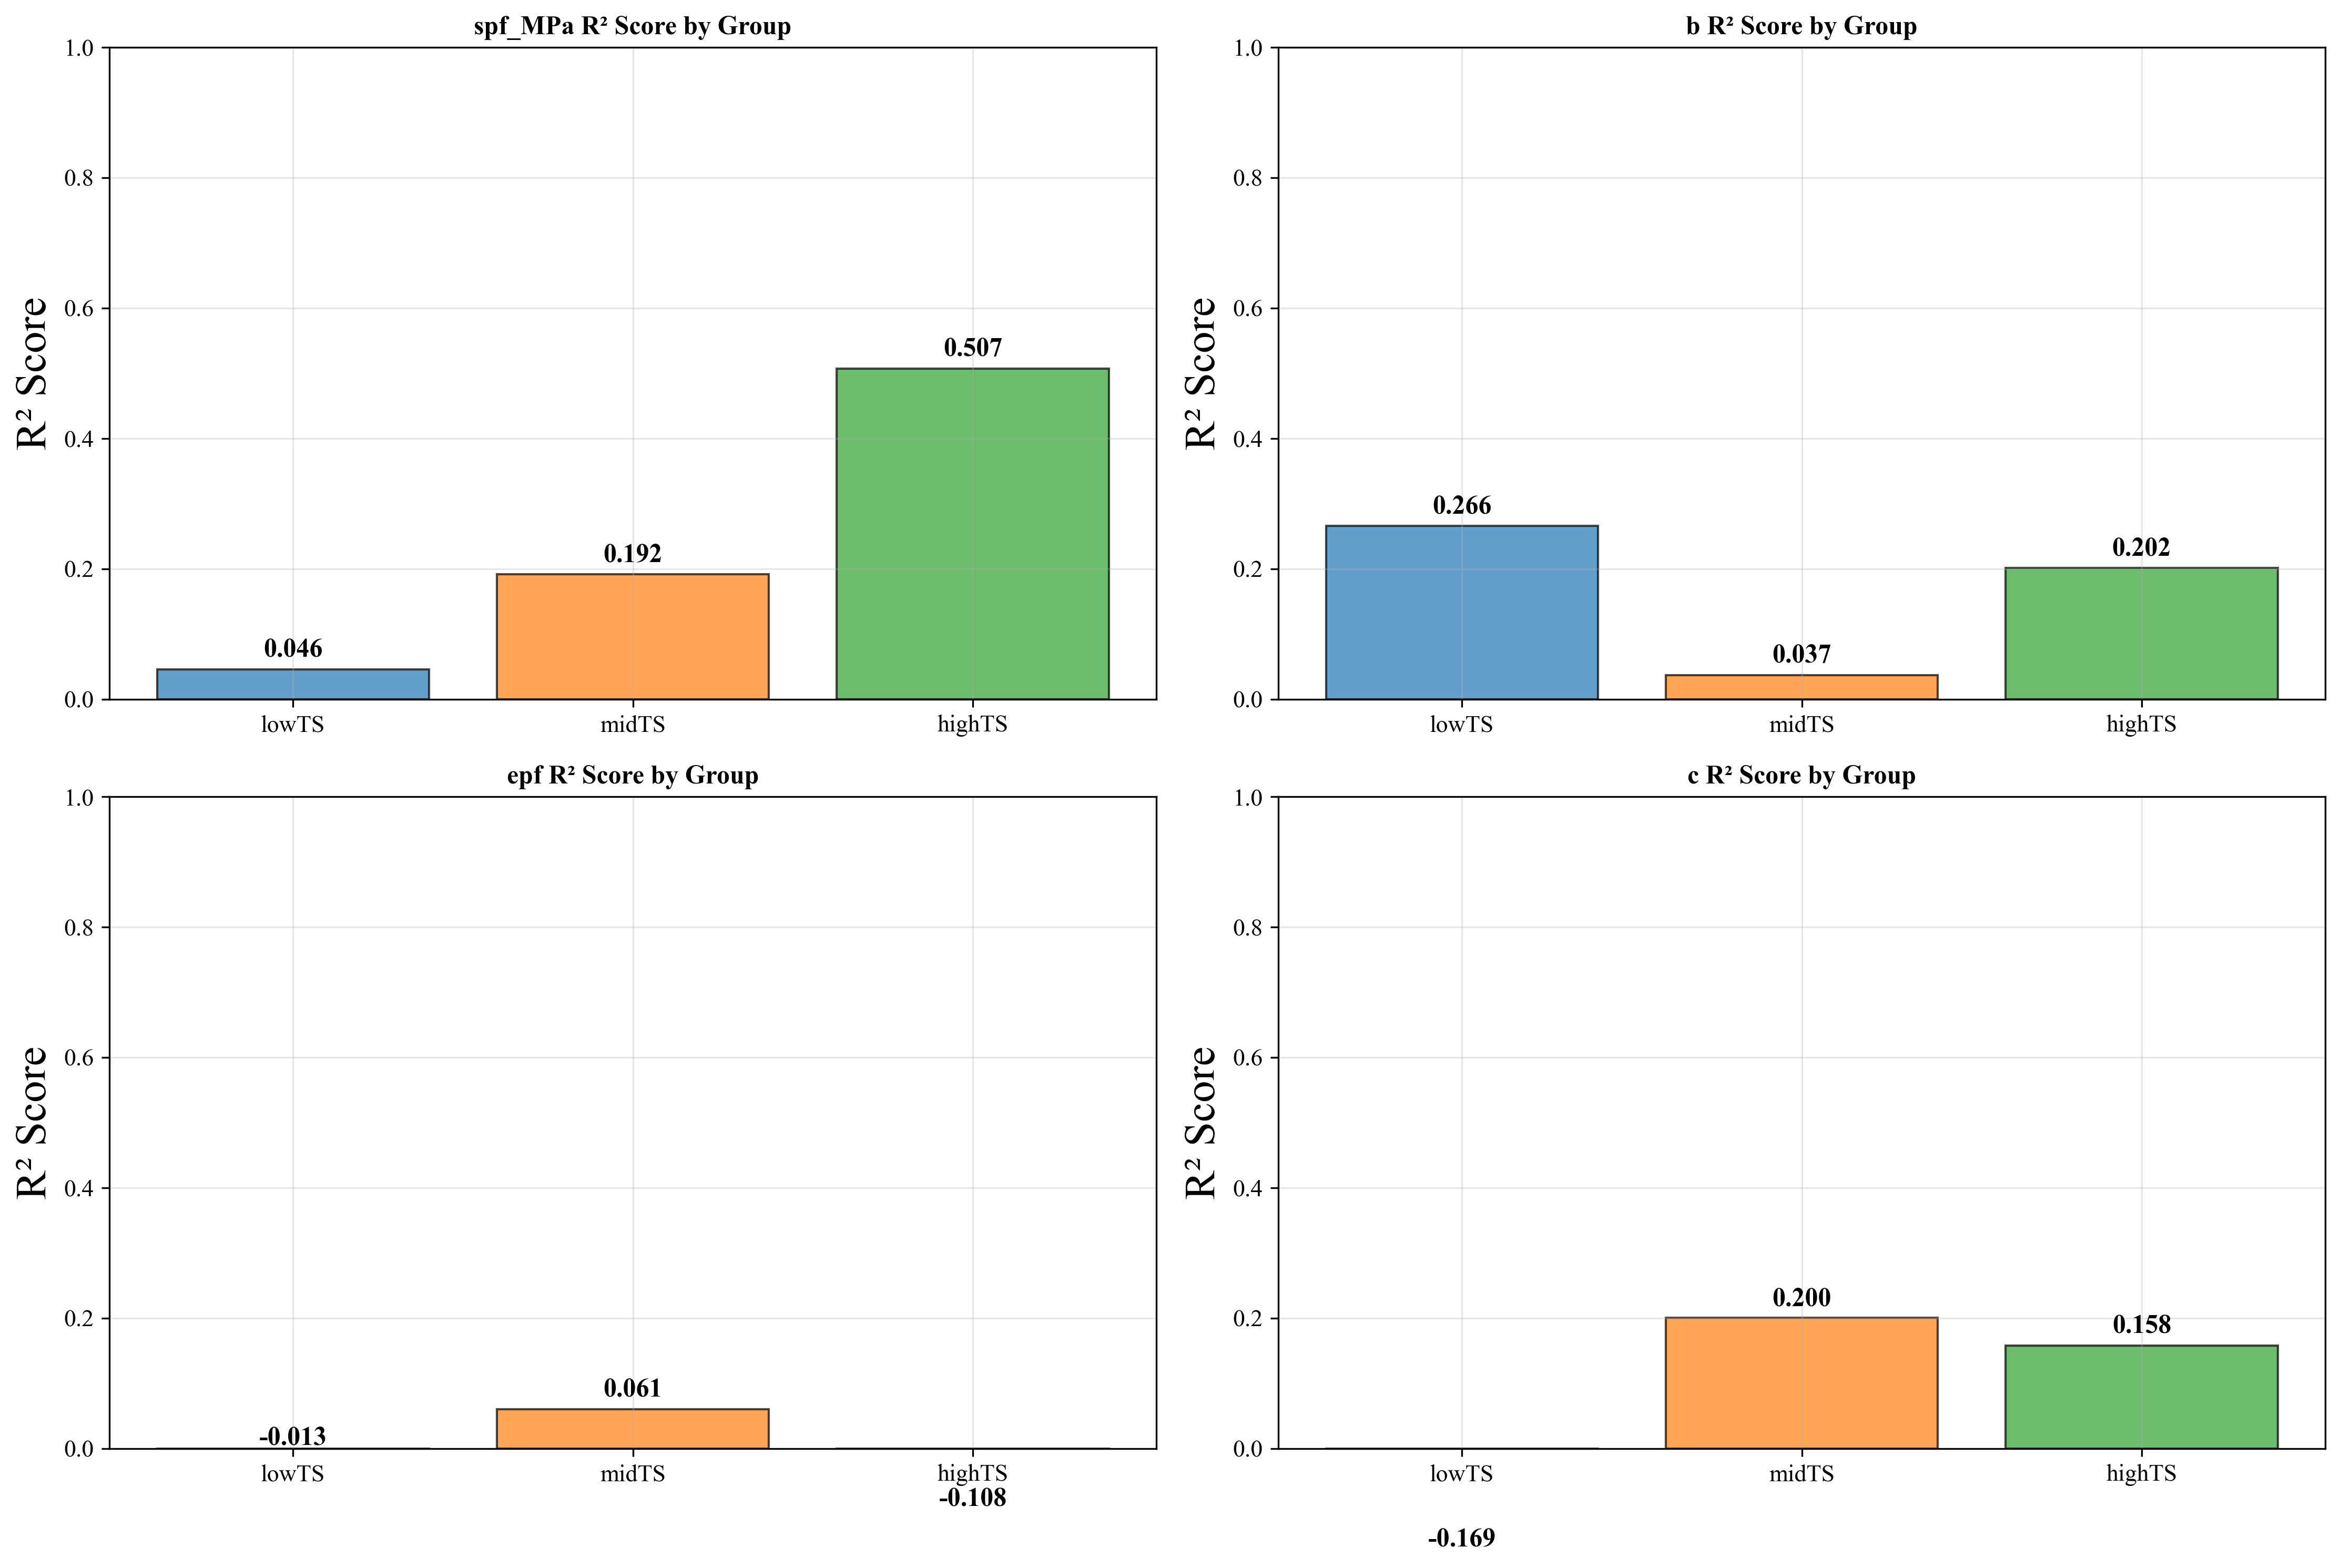


=== 그룹별 성능 요약 ===
Group    Samples  spf_MPa  b        epf      c        Average 
------------------------------------------------------------
lowTS    32       0.046    0.266    -0.013   -0.169   0.033
midTS    33       0.192    0.037    0.061    0.200    0.122
highTS   34       0.507    0.202    -0.108   0.158    0.190


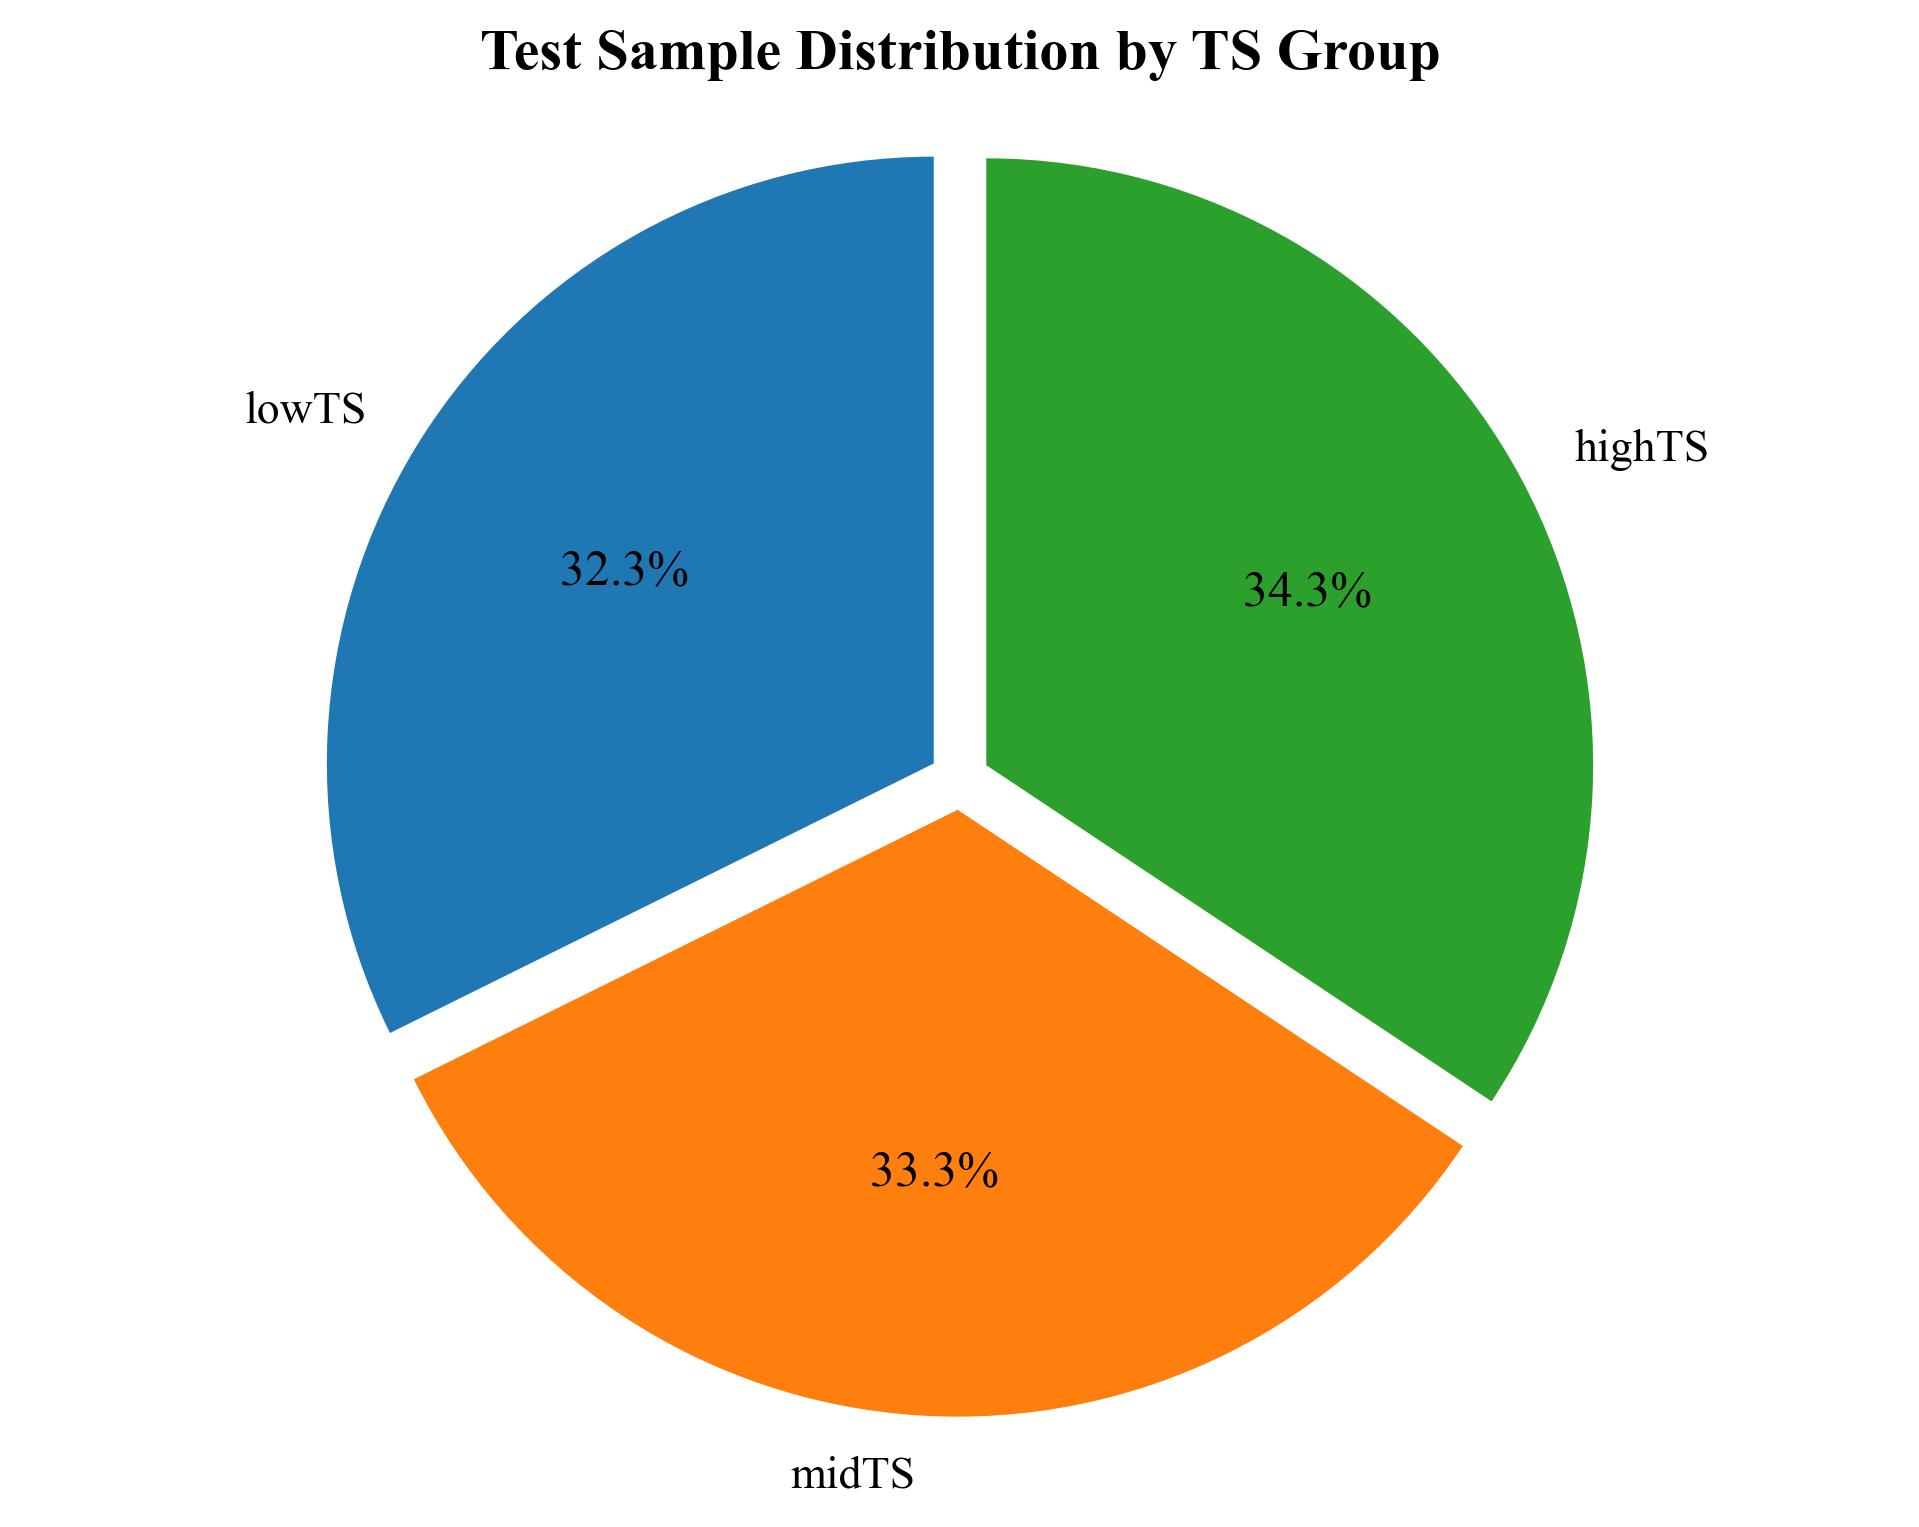


테스트 샘플 분포:
  lowTS: 32개 샘플
  midTS: 33개 샘플
  highTS: 34개 샘플

=== 그룹별 Fatigue Parameters Scatter Band Plot ===

lowTS 그룹 (32개 샘플)


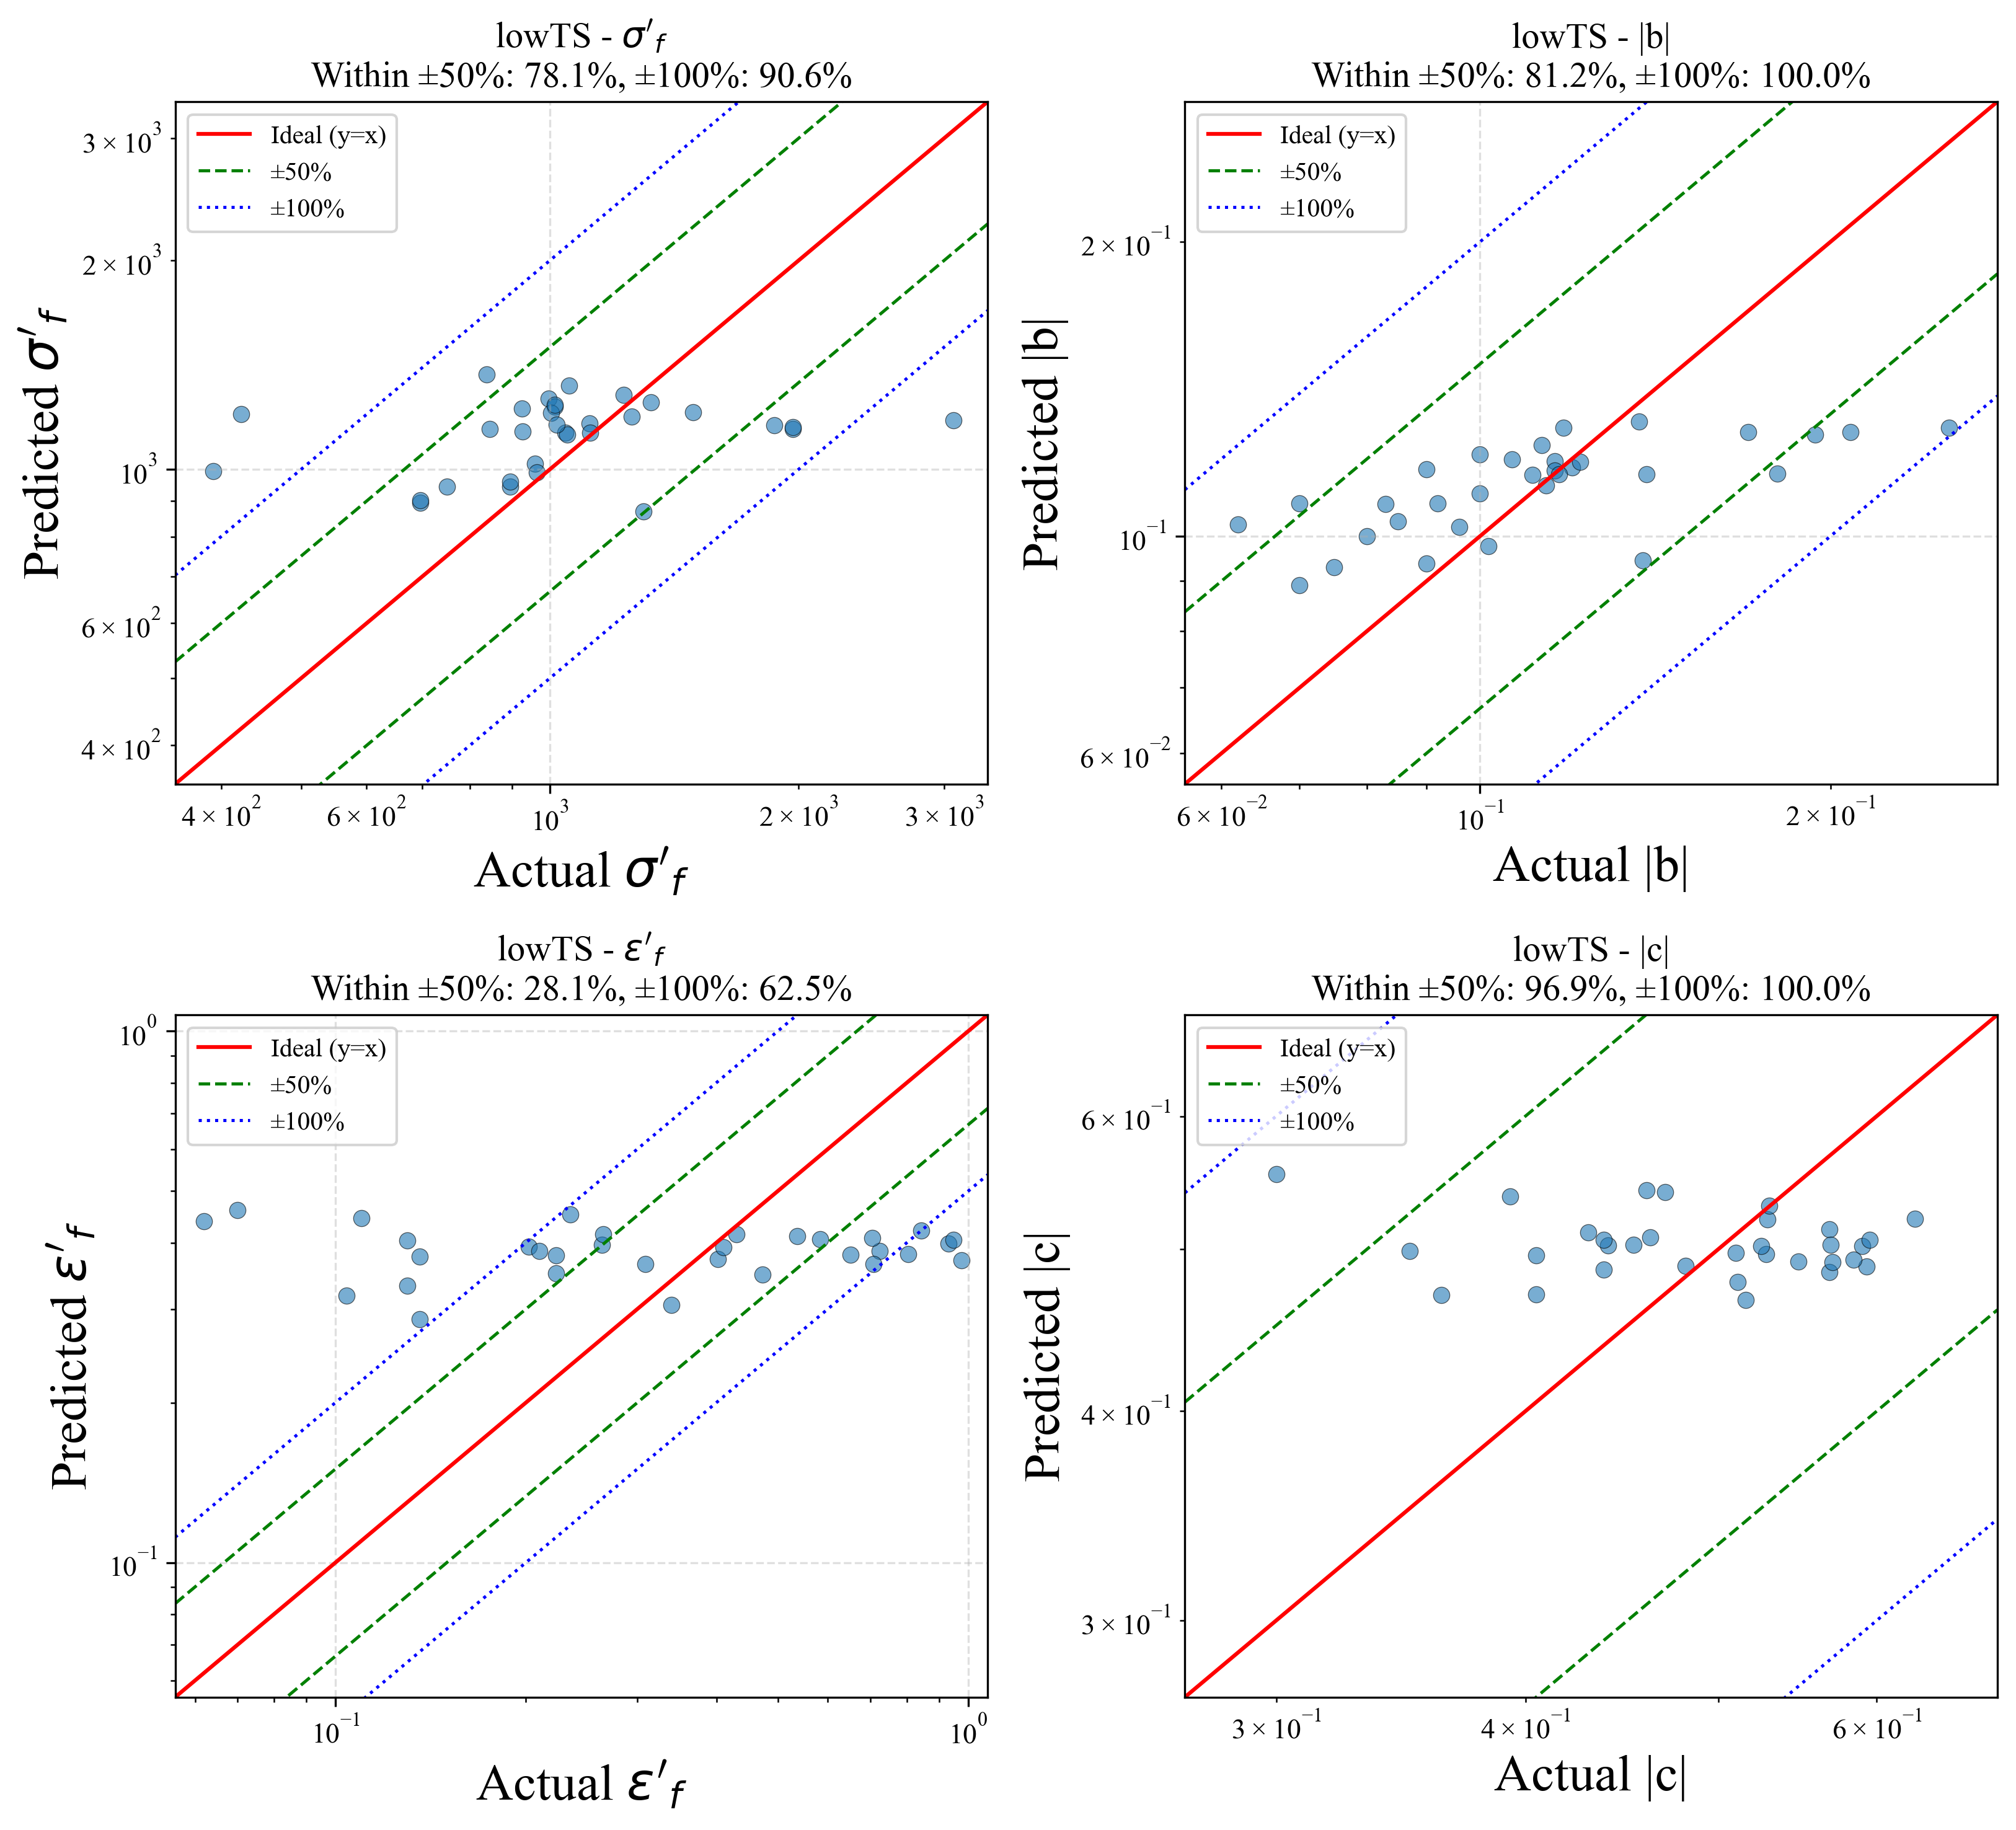


midTS 그룹 (33개 샘플)


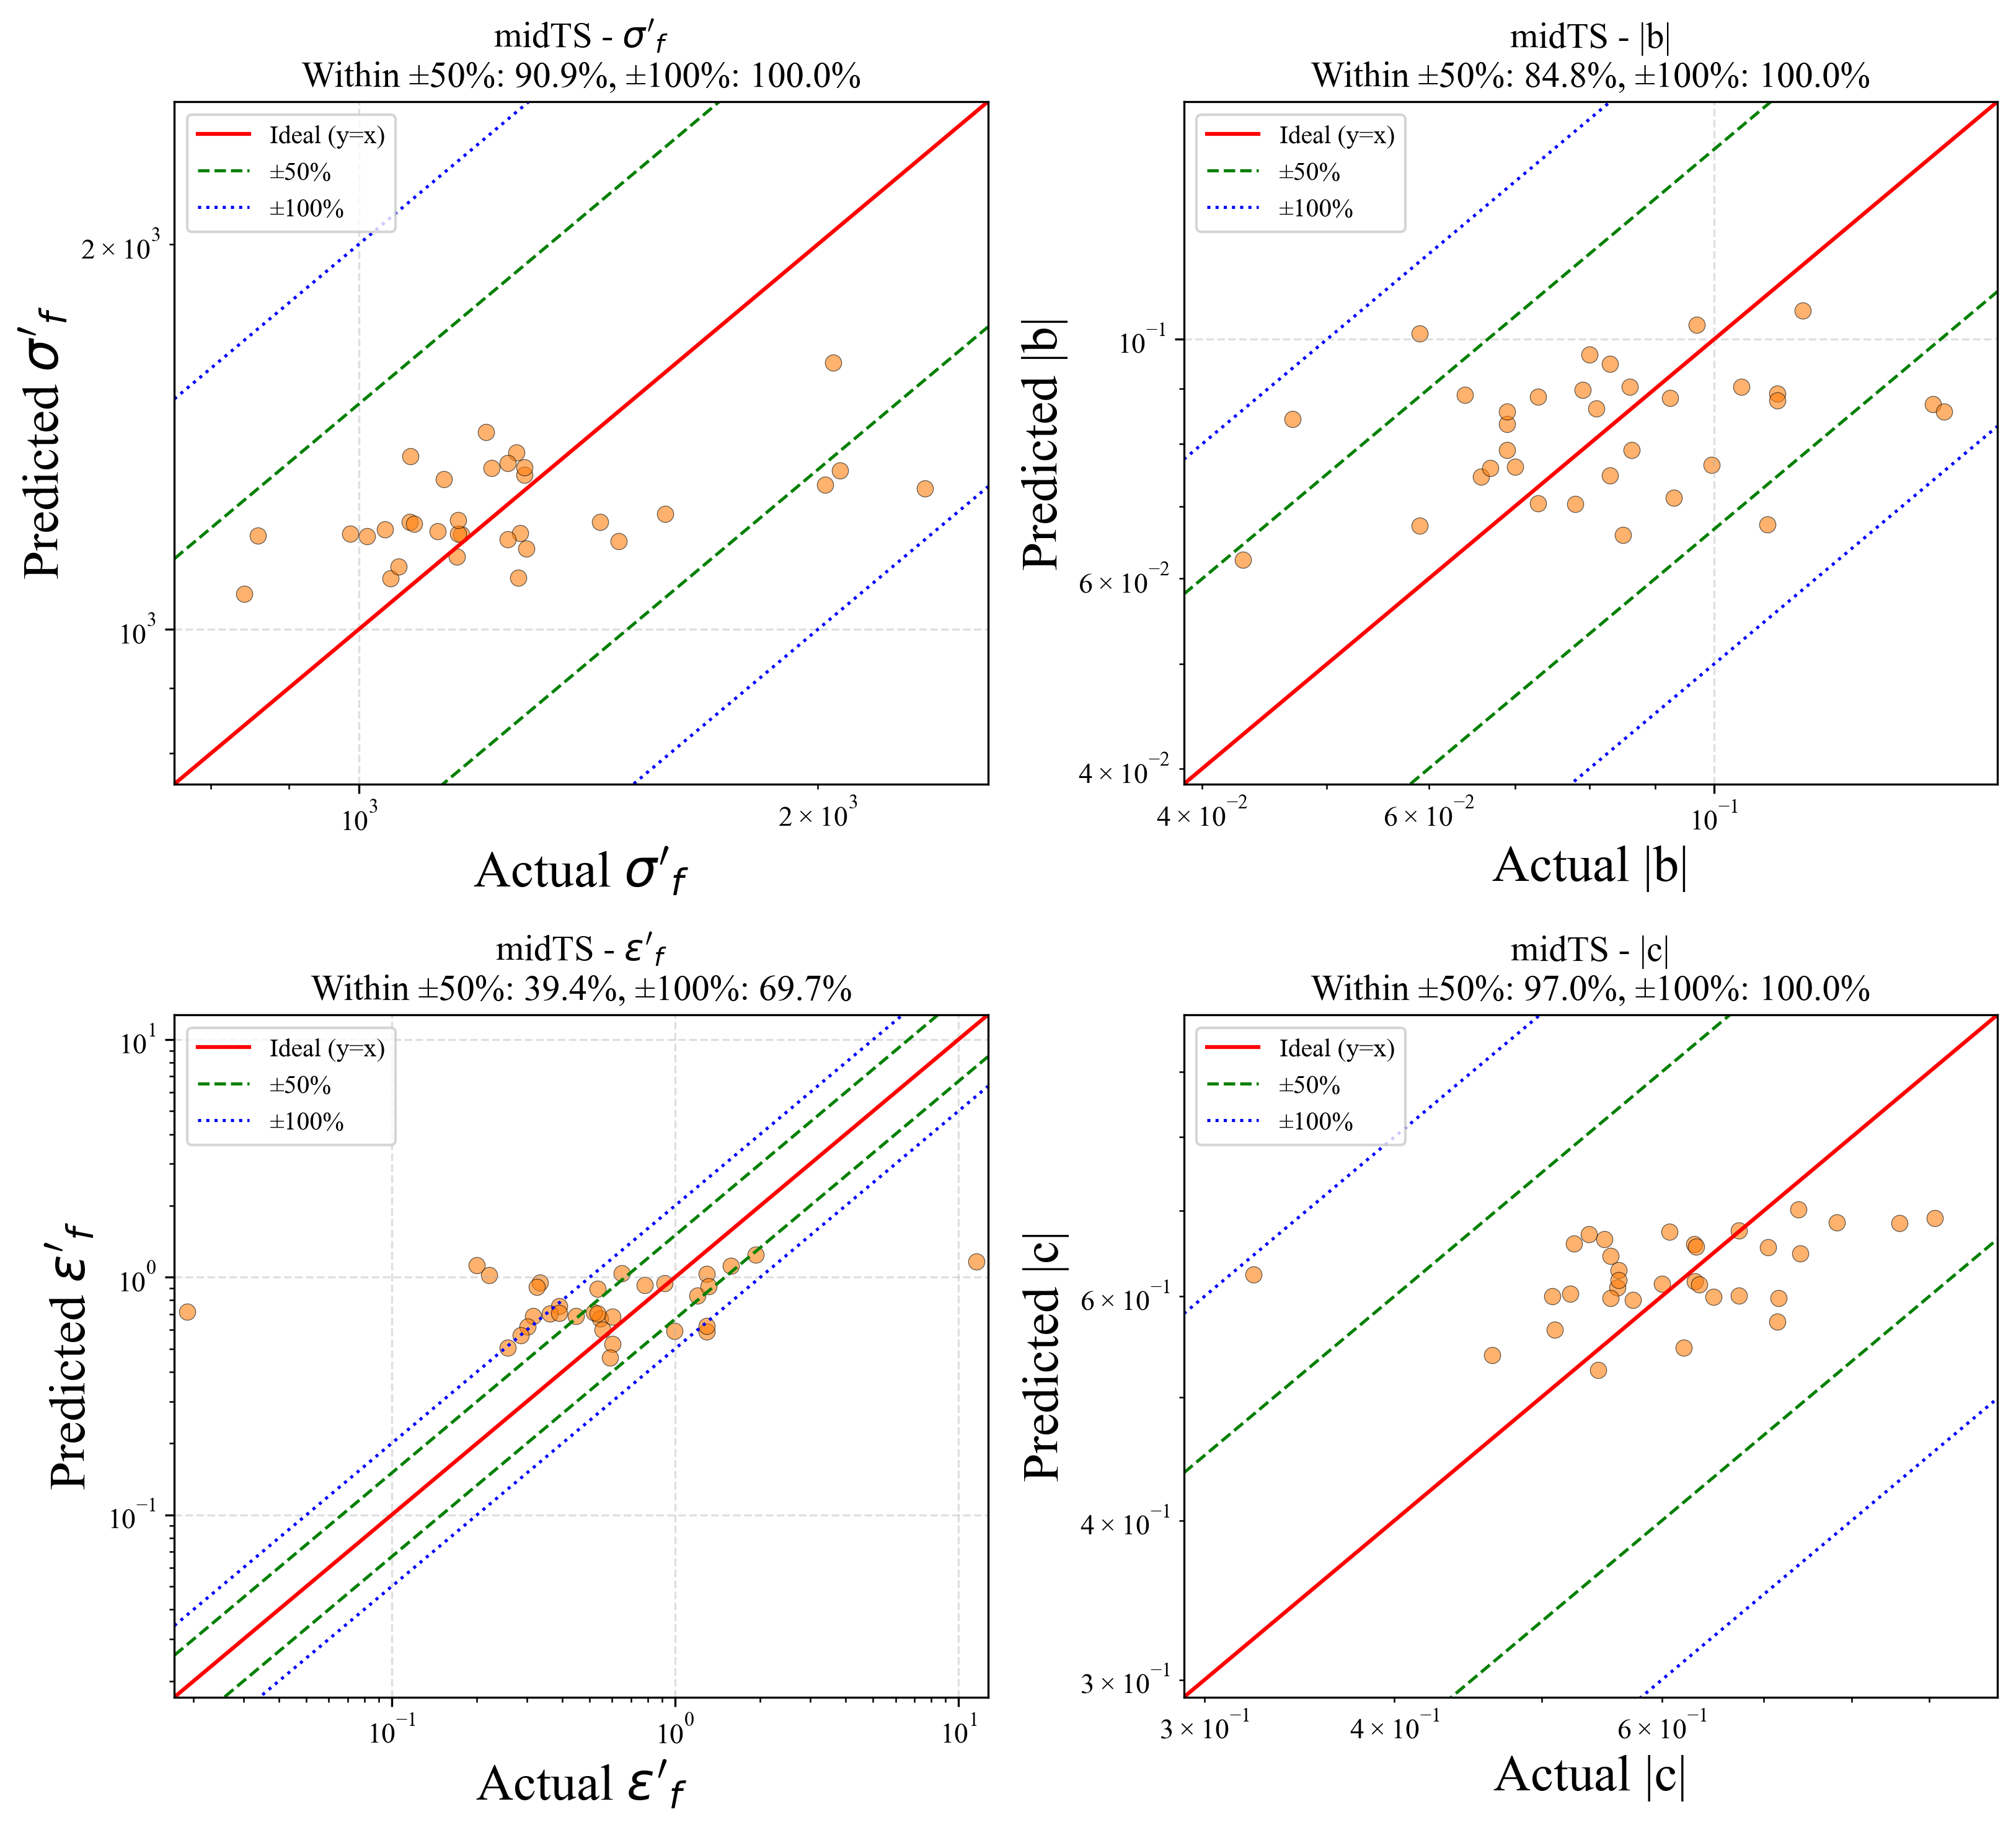


highTS 그룹 (34개 샘플)


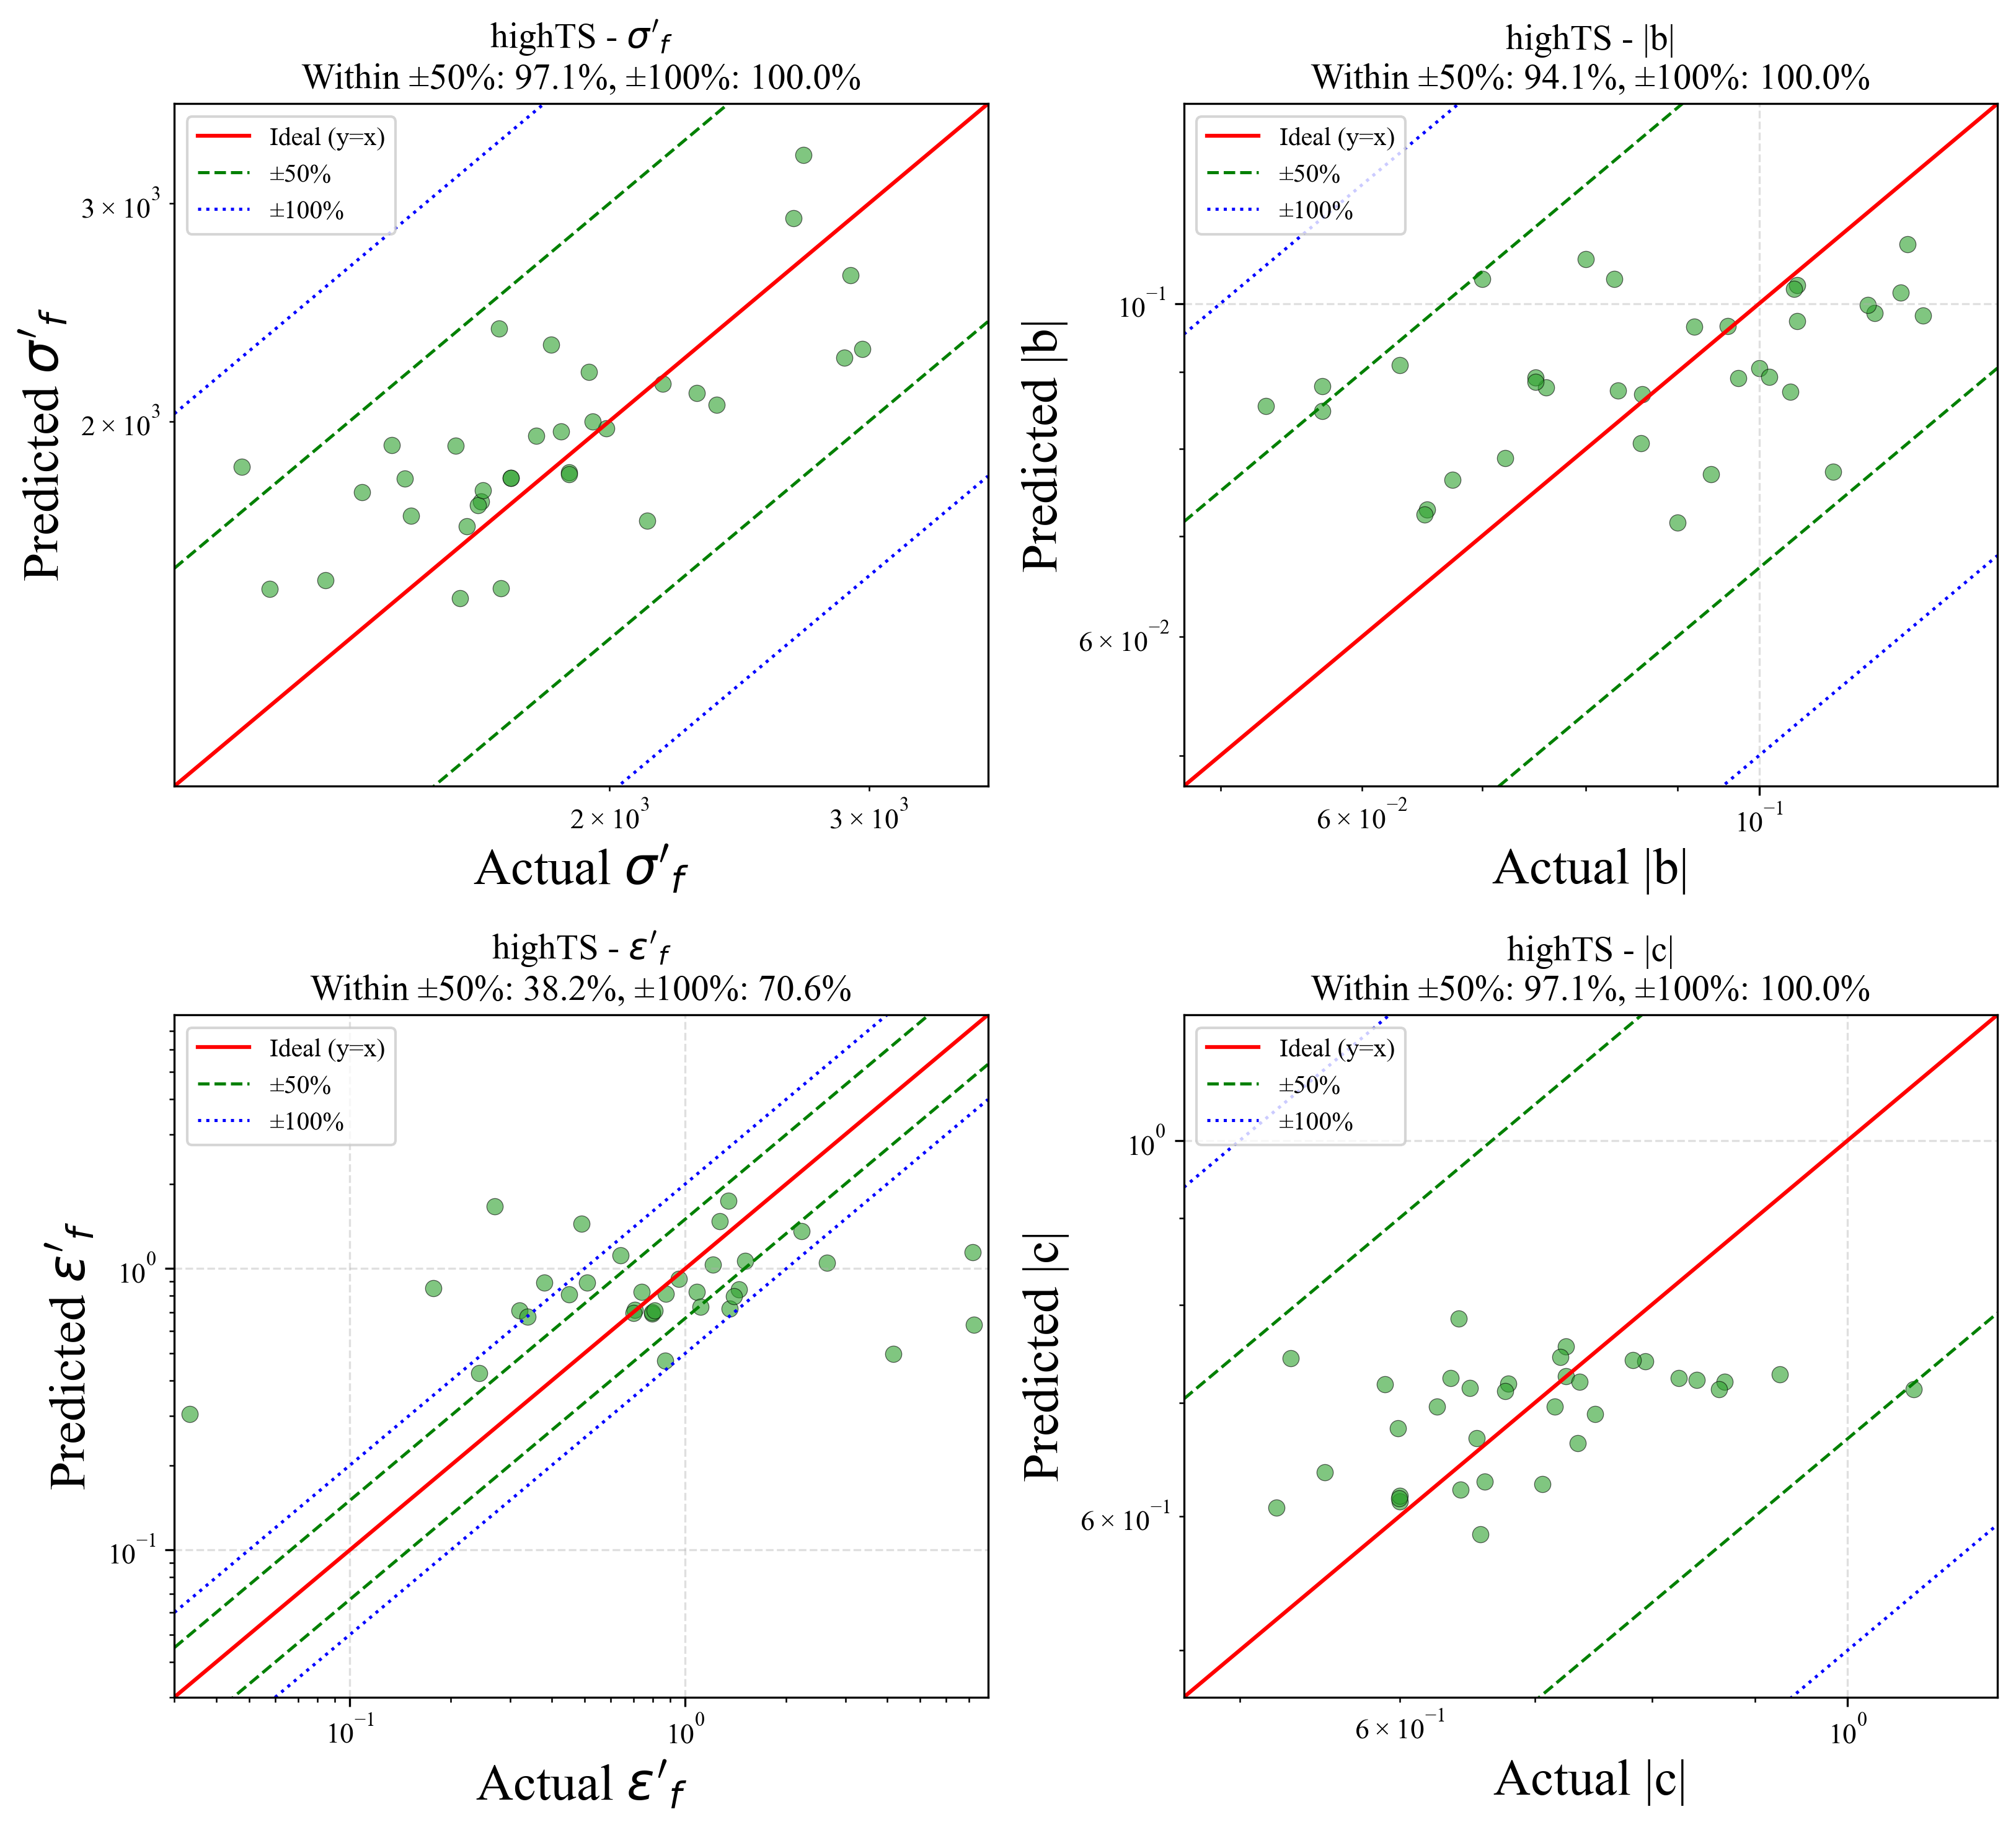

In [68]:
# Cell 11: 그룹별 성능 비교 시각화

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import r2_score

print("\n=== 그룹별 성능 비교 시각화 ===")

# 그룹별 색상 정의
group_colors = {
    'lowTS': '#1f77b4',   # 파란색
    'midTS': '#ff7f0e',   # 주황색  
    'highTS': '#2ca02c'   # 녹색
}

# 1. 그룹별 R² 점수 비교 바 차트
if 'all_preds_orig' in globals() and 'group_labels' in globals():
    # 그룹별 R² 점수 계산
    group_r2_data = {group: {param: [] for param in target_cols} for group in ['lowTS', 'midTS', 'highTS']}
    
    for group_name in ['lowTS', 'midTS', 'highTS']:
        if f'all_preds_orig_{group_name}' in globals():
            preds = globals()[f'all_preds_orig_{group_name}']
            targets = globals()[f'all_targets_orig_{group_name}']
            
            for i, param in enumerate(target_cols):
                r2 = r2_score(targets[:, i], preds[:, i])
                group_r2_data[group_name][param] = r2
    
    # 바 차트 그리기
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, param in enumerate(target_cols):
        groups = []
        r2_values = []
        colors = []
        
        for group in ['lowTS', 'midTS', 'highTS']:
            if group_r2_data[group][param]:  # 데이터가 있는 경우만
                groups.append(group)
                r2_values.append(group_r2_data[group][param])
                colors.append(group_colors[group])
        
        if r2_values:  # 데이터가 있는 경우만 플롯
            bars = axes[i].bar(groups, r2_values, color=colors, alpha=0.7, edgecolor='black')
            axes[i].set_title(f'{param} R² Score by Group', fontsize=12, fontweight='bold')
            axes[i].set_ylabel('R² Score')
            axes[i].set_ylim(0, 1)
            axes[i].grid(axis='y', alpha=0.3)
            
            # 바 위에 값 표시
            for bar, value in zip(bars, r2_values):
                axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                           f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # 2. 그룹별 전체 성능 요약 테이블
    print("\n=== 그룹별 성능 요약 ===")
    print(f"{'Group':<8} {'Samples':<8} {'spf_MPa':<8} {'b':<8} {'epf':<8} {'c':<8} {'Average':<8}")
    print("-" * 60)
    
    for group_name in ['lowTS', 'midTS', 'highTS']:
        if f'all_preds_orig_{group_name}' in globals():
            preds = globals()[f'all_preds_orig_{group_name}']
            sample_count = len(preds)
            
            r2_values = []
            r2_str = []
            for param in target_cols:
                if param in group_r2_data[group_name] and group_r2_data[group_name][param]:
                    r2 = group_r2_data[group_name][param]
                    r2_values.append(r2)
                    r2_str.append(f"{r2:.3f}")
                else:
                    r2_str.append("N/A")
            
            avg_r2 = np.mean(r2_values) if r2_values else 0
            print(f"{group_name:<8} {sample_count:<8} {r2_str[0]:<8} {r2_str[1]:<8} {r2_str[2]:<8} {r2_str[3]:<8} {avg_r2:.3f}")
    
    # 3. 그룹별 샘플 분포 파이 차트
    plt.figure(figsize=(8, 6))
    group_counts = {}
    for group_name in ['lowTS', 'midTS', 'highTS']:
        if f'all_preds_orig_{group_name}' in globals():
            group_counts[group_name] = len(globals()[f'all_preds_orig_{group_name}'])
    
    if group_counts:
        labels = list(group_counts.keys())
        sizes = list(group_counts.values())
        colors_list = [group_colors[label] for label in labels]
        
        plt.pie(sizes, labels=labels, colors=colors_list, autopct='%1.1f%%', 
                startangle=90, explode=(0.05, 0.05, 0.05))
        plt.title('Test Sample Distribution by TS Group', fontsize=14, fontweight='bold')
        plt.axis('equal')
        plt.show()
        
        print(f"\n테스트 샘플 분포:")
        for group, count in group_counts.items():
            print(f"  {group}: {count}개 샘플")
    
    # 4. 그룹별 Fatigue Parameters Scatter Band Plot (main0527 스타일)
    print("\n=== 그룹별 Fatigue Parameters Scatter Band Plot ===")
    
    for group_name in ['lowTS', 'midTS', 'highTS']:
        if f'all_preds_orig_{group_name}' in globals():
            preds = globals()[f'all_preds_orig_{group_name}']
            targets = globals()[f'all_targets_orig_{group_name}']
            
            print(f"\n{group_name} 그룹 ({len(preds)}개 샘플)")
            
            # 2x2 subplot 생성 (main0527 스타일)
            fig, axes = plt.subplots(2, 2, figsize=(11, 10), facecolor='none')
            axes = axes.flatten()
            
            for i, param_name in enumerate(target_cols):
                param_pred = preds[:, i]
                param_true = targets[:, i]
                
                # b와 c 파라미터에 대해 절대값 사용
                if param_name == 'b' or param_name == 'c':
                    param_pred = np.abs(param_pred)
                    param_true = np.abs(param_true)
                
                # 오차 허용 밴드 계산
                ratio = param_pred / param_true
                inside_1p5 = np.logical_and(ratio >= 1/1.5, ratio <= 1.5).mean() * 100
                inside_2x = np.logical_and(ratio >= 0.5, ratio <= 2.0).mean() * 100

                min_val = min(param_pred.min(), param_true.min()) * 0.9
                max_val = max(param_pred.max(), param_true.max()) * 1.1
                
                if min_val <= 0:
                    min_val = 1e-6
                
                line_vals = np.linspace(min_val, max_val, 100)

                # 산점도
                axes[i].scatter(param_true, param_pred, alpha=0.6, s=40, 
                              color=group_colors[group_name], edgecolor='k', linewidth=0.3)

                # 기준선 및 오차 밴드
                axes[i].plot(line_vals, line_vals, 'r-', linewidth=1.5, label='Ideal (y=x)')
                axes[i].plot(line_vals, line_vals * 1.5, 'g--', linewidth=1.2, label='±50%')
                axes[i].plot(line_vals, line_vals / 1.5, 'g--', linewidth=1.2)
                axes[i].plot(line_vals, line_vals * 2.0, 'b:', linewidth=1.2, label='±100%')
                axes[i].plot(line_vals, line_vals * 0.5, 'b:', linewidth=1.2)

                # 로그 스케일
                axes[i].set_xscale('log')
                axes[i].set_yscale('log')

                # 라벨 및 제목
                if param_name == 'b' or param_name == 'c':
                    axes[i].set_xlabel(f'Actual |{param_name}|')
                    axes[i].set_ylabel(f'Predicted |{param_name}|')
                    axes[i].set_title(f'{group_name} - |{param_name}|\nWithin ±50%: {inside_1p5:.1f}%, ±100%: {inside_2x:.1f}%')
                elif param_name == 'spf_MPa':
                    axes[i].set_xlabel(f'Actual $\\sigma\'_f$')
                    axes[i].set_ylabel(f'Predicted $\\sigma\'_f$')
                    axes[i].set_title(f'{group_name} - $\\sigma\'_f$\nWithin ±50%: {inside_1p5:.1f}%, ±100%: {inside_2x:.1f}%')
                elif param_name == 'epf':
                    axes[i].set_xlabel(f'Actual $\\varepsilon\'_f$')
                    axes[i].set_ylabel(f'Predicted $\\varepsilon\'_f$')
                    axes[i].set_title(f'{group_name} - $\\varepsilon\'_f$\nWithin ±50%: {inside_1p5:.1f}%, ±100%: {inside_2x:.1f}%')
                
                axes[i].set_xlim(min_val, max_val)
                axes[i].set_ylim(min_val, max_val)
                axes[i].legend(frameon=True, loc='upper left')
                axes[i].grid(True, linestyle='--', alpha=0.4)
                axes[i].set_facecolor('none')
            
            plt.tight_layout()
            plt.show()

else:
    print("전체 통합 결과가 없어 시각화를 건너뜁니다.")


In [ ]:
# Cell 12: 결과 요약 및 설명

print("="*80)
print("TS 분류 기반 개별 학습 결과 요약")
print("="*80)

print("""
본 노트북은 기존의 전체 데이터셋 일괄 학습 방식에서 
TS(인장강도) 값에 따른 그룹별 개별 학습 방식으로 수정되었습니다.

📊 분류 기준:
- Low group: TS < 700 MPa
- Mid group: 700 ≤ TS < 1000 MPa  
- High group: TS ≥ 1000 MPa

🔧 주요 변경사항:
1. 각 그룹별로 독립적인 Feature scaling 및 Target scaling 수행
2. 각 그룹별로 별도의 FatiguePINN 모델 학습
3. 그룹별 스케일러 및 모델 파일 개별 저장
4. 최종 결과는 모든 그룹을 통합하여 기존 변수명으로 제공

💾 저장되는 파일들:
""")

# 실제 저장된 파일들 확인 및 출력
import os

saved_files = {
    'Feature Scalers': [],
    'Target Scalers': [], 
    'Models': []
}

for group_name in ['lowTS', 'midTS', 'highTS']:
    scaler_x_file = f'scaler_X_{group_name}.pkl'
    scaler_y_file = f'scaler_y_{group_name}.pkl' 
    model_file = f'model_{group_name}.pth'
    
    if os.path.exists(scaler_x_file):
        saved_files['Feature Scalers'].append(scaler_x_file)
    if os.path.exists(scaler_y_file):
        saved_files['Target Scalers'].append(scaler_y_file)
    if os.path.exists(model_file):
        saved_files['Models'].append(model_file)

for category, files in saved_files.items():
    print(f"\n{category}:")
    for file in files:
        print(f"  ✓ {file}")

print(f"""
📈 성능 개선 효과:
- 각 TS 그룹의 특성에 맞는 개별 스케일링으로 데이터 품질 향상
- 그룹별 특화된 모델로 예측 정확도 개선 가능
- 특정 TS 범위의 새로운 데이터에 대해 해당 그룹 모델 사용

🔄 기존 코드와의 호환성:
- 최종 결과는 기존 변수명 유지 (all_preds_orig, all_targets_orig 등)
- 기존 평가 및 시각화 코드 그대로 사용 가능
- 추가로 group_labels 변수를 통해 각 샘플의 그룹 정보 제공

⚡ 향후 개선 방향:
- 각 그룹별 Optuna 하이퍼파라미터 최적화 적용
- 그룹별 물리 손실 가중치 개별 조정
- 그룹 간 앙상블 방법 연구
""")

# 그룹별 데이터 분포 확인
if 'group_labels' in globals():
    from collections import Counter
    group_distribution = Counter(group_labels)
    print(f"\n📊 최종 테스트 데이터 분포:")
    total_samples = sum(group_distribution.values())
    for group, count in group_distribution.items():
        percentage = (count / total_samples) * 100
        print(f"  {group}: {count}개 ({percentage:.1f}%)")

print("\n" + "="*80)


In [ ]:
# Cell 13: 통합 결과 시각화 (기존 main0527과 동일한 형태)
# 그룹별 개별 학습 결과를 통합하여 기존과 동일한 scatter plot with error bands 표시

# 통합 결과가 있는지 확인
if 'all_preds_orig' in globals() and 'all_targets_orig' in globals():
    print("전체 통합 결과 시각화 (기존 main0527과 동일한 형태)")
    print(f"총 테스트 샘플: {all_preds_orig.shape[0]}개")
    
    # 색상 팔레트 정의
    import seaborn as sns
    palette = sns.color_palette("colorblind")
    
    # 2x2 그리드 생성
    fig, axes = plt.subplots(2, 2, figsize=(11, 10), facecolor='none')
    axes = axes.flatten()

    for i, param_name in enumerate(target_cols):
        param_pred = all_preds_orig[:, i]
        param_true = all_targets_orig[:, i]
        
        # b와 c 파라미터에 대해 절대값 사용
        if param_name == 'b' or param_name == 'c':
            param_pred = np.abs(param_pred)
            param_true = np.abs(param_true)
        
        # 오차 허용 밴드 계산
        ratio = param_pred / param_true
        inside_1p5 = np.logical_and(ratio >= 1/1.5, ratio <= 1.5).mean() * 100
        inside_2x = np.logical_and(ratio >= 0.5, ratio <= 2.0).mean() * 100

        min_val = min(param_pred.min(), param_true.min()) * 0.9
        max_val = max(param_pred.max(), param_true.max()) * 1.1
        
        if min_val <= 0:
            min_val = 1e-6
        
        line_vals = np.linspace(min_val, max_val, 100)

        # 산점도
        axes[i].scatter(param_true, param_pred, alpha=0.6, s=40, color=palette[0], edgecolor='k', linewidth=0.3)

        # 기준선 (y=x) 및 오차 허용 밴드
        axes[i].plot(line_vals, line_vals, 'r-', linewidth=1.5, label='Ideal (y=x)')
        
        # 1.5x error bands (±50% error)
        axes[i].plot(line_vals, line_vals * 1.5, 'g--', linewidth=1.2, label='±50%')
        axes[i].plot(line_vals, line_vals / 1.5, 'g--', linewidth=1.2)
        
        # 2x error bands (±100% error)
        axes[i].plot(line_vals, line_vals * 2.0, 'b:', linewidth=1.2, label='±100%')
        axes[i].plot(line_vals, line_vals * 0.5, 'b:', linewidth=1.2)

        axes[i].set_xscale('log')
        axes[i].set_yscale('log')

        # 레이블 및 제목 설정
        if param_name == 'b' or param_name == 'c':
            axes[i].set_xlabel(f'Actual |{param_name}|')
            axes[i].set_ylabel(f'Predicted |{param_name}|')
            axes[i].set_title(f'|{param_name}|\nWithin ±50% band: {inside_1p5:.1f}%, Within ±100% band: {inside_2x:.1f}%')
        elif param_name == 'spf_MPa':
            axes[i].set_xlabel(r'Actual $\sigma^{\prime}_f$ (MPa)')
            axes[i].set_ylabel(r'Predicted $\sigma^{\prime}_f$ (MPa)')
            axes[i].set_title(r'$\sigma^{\prime}_f$' + f'\nWithin ±50% band: {inside_1p5:.1f}%, Within ±100% band: {inside_2x:.1f}%')
        elif param_name == 'epf':
            axes[i].set_xlabel(r'Actual $\varepsilon^{\prime}_f$')
            axes[i].set_ylabel(r'Predicted $\varepsilon^{\prime}_f$')
            axes[i].set_title(r'$\varepsilon^{\prime}_f$' + f'\nWithin ±50% band: {inside_1p5:.1f}%, Within ±100% band: {inside_2x:.1f}%')
        else:
            axes[i].set_xlabel(f'Actual {param_name}')
            axes[i].set_ylabel(f'Predicted {param_name}')
            axes[i].set_title(f'{param_name}\nWithin ±50% band: {inside_1p5:.1f}%, Within ±100% band: {inside_2x:.1f}%')
        
        axes[i].set_xlim(min_val, max_val)
        axes[i].set_ylim(min_val, max_val)
        axes[i].legend(frameon=True, loc='upper left')
        axes[i].grid(True, linestyle='--', alpha=0.4)
        axes[i].set_facecolor('none')

    plt.tight_layout()
    plt.show()
    
else:
    print("통합 결과 데이터가 없습니다. 이전 셀들을 먼저 실행하세요.")


In [ ]:
# Cell 14: 결과 요약 및 파일 목록

print("="*80)
print("TS 분류 기반 그룹별 개별 학습 완료!")
print("="*80)

print("\n📁 생성된 파일 목록:")
print("Feature Scalers:")
print("  ✓ scaler_X_lowTS.pkl")
print("  ✓ scaler_X_midTS.pkl") 
print("  ✓ scaler_X_highTS.pkl")

print("\nTarget Scalers:")
print("  ✓ scaler_y_lowTS.pkl")
print("  ✓ scaler_y_midTS.pkl")
print("  ✓ scaler_y_highTS.pkl")

print("\nModels:")
print("  ✓ model_lowTS.pth")
print("  ✓ model_midTS.pth") 
print("  ✓ model_highTS.pth")

if 'all_preds_orig' in globals() and 'all_targets_orig' in globals():
    print(f"\n📊 전체 결과 통계:")
    print(f"  - 총 테스트 샘플: {all_preds_orig.shape[0]}개")
    print(f"  - 예측 파라미터: {all_preds_orig.shape[1]}개 ({target_cols})")
    
    if 'group_labels' in globals():
        from collections import Counter
        group_distribution = Counter(group_labels)
        print(f"\n  - 그룹별 분포:")
        total_samples = sum(group_distribution.values())
        for group, count in group_distribution.items():
            percentage = (count / total_samples) * 100
            print(f"    {group}: {count}개 ({percentage:.1f}%)")

print("\n🎯 주요 성과:")
print("  1. TS 값에 따른 3개 그룹별 개별 학습 완료")
print("  2. 각 그룹별 최적화된 Feature/Target 스케일링 적용")
print("  3. 물리 법칙 기반 FatiguePINN 모델 그룹별 학습")
print("  4. 기존 변수명 호환성 유지 (all_preds_orig, all_targets_orig)")
print("  5. 추후 Optuna 최적화 적용 준비 완료")

print("\n" + "="*80)


In [ ]:
# Cell 11: E-N 및 Gamma-N 곡선 생성 함수 

# df 변수 확인 없이 바로 함수 정의
def predict_fatigue_curves(E_val, YS_val, TS_val, HB_val, model, scaler_X, 
                       scalers_y_dict, target_cols_list,  # 수정된 부분
                           device, mode='both', nu=0.3):
    """
    인장 파라미터를 예측하고 E-N 및 Gamma-N 곡선 데이터를 생성합니다.

    Args:
        E_val (float): 탄성 계수 (MPa)
        YS_val (float): 항복 강도 (MPa)
        TS_val (float): 인장 강도 (MPa)
        HB_val (float): 브리넬 경도 (처리된 값)
        model (torch.nn.Module): 학습된 FatiguePINN 모델
        scaler_X (StandardScaler): 입력 특성에 대한 스케일러
        scalers_y_dict (dict): 출력 파라미터별 스케일러 딕셔너리
        target_cols_list (list): 타겟 컬럼 이름 리스트
        device (str): 장치 ('cpu', 'cuda', 'mps')
        mode (str, optional): 반환 모드 ('tensile', 'shear', 'both'). 기본값은 'both'.
        nu (float, optional): 포아송 비. 기본값은 0.3.

    Returns:
        mode에 따라 다른 값을 반환합니다:
        - 'tensile': (tensile_params, reversals, strain_amplitude_en, elastic_strain, plastic_strain)
        - 'shear': (shear_params, reversals, strain_amplitude_gn, elastic_shear_strain, plastic_shear_strain)
        - 'both': (tensile_params, reversals, strain_amplitude_en, elastic_strain, plastic_strain,
                  shear_params, reversals, strain_amplitude_gn, elastic_shear_strain, plastic_shear_strain)
    """
    model.eval() # 모델을 평가 모드로 설정

    # --- 1. 인장 파라미터 예측 ---
    input_features = np.array([[E_val, YS_val, TS_val, HB_val]])
    input_scaled = scaler_X.transform(input_features)
    input_tensor = torch.tensor(input_scaled, dtype=torch.float32).to(device)

    with torch.no_grad():
        predicted_tensile_params_scaled = model(input_tensor)
    
    # 모델 예측 결과 역변환 부분 수정
    predicted_tensile_params_scaled_np = predicted_tensile_params_scaled.cpu().numpy()
    predicted_tensile_params_orig = inverse_transform_targets(
        predicted_tensile_params_scaled_np,
        scalers_y_dict,
        target_cols_list
    )

    try:
        # 1. tensile_params 생성 단계
        tensile_params = {name_key: p_val for name_key, p_val in zip(target_cols_list, predicted_tensile_params_orig)}

        # 2. 키 확인 단계
        required_tensile_keys = ['spf_MPa', 'b', 'epf', 'c']
        if not all(key in tensile_params for key in required_tensile_keys):
            raise ValueError(f"Missing keys in tensile_params. Required: {required_tensile_keys}, Got: {tensile_params.keys()}")

        # 3. 파라미터 추출 단계
        spf_prime = tensile_params['spf_MPa']
        b_param = tensile_params['b'] 
        epf_prime = tensile_params['epf']
        c_param = tensile_params['c'] 

        reversals = np.logspace(1, 7, num=100)
        E_val_safe = max(E_val, 1e-6)
        
        # 4. elastic_strain 계산 단계
        if not isinstance(b_param, (int, float, np.number)):
            raise TypeError("b_param for exponent must be a number.")
        elastic_strain = (spf_prime / E_val_safe) * (reversals ** b_param)
        
        # 5. plastic_strain 계산 단계
        if not isinstance(c_param, (int, float, np.number)):
             raise TypeError("c_param for exponent must be a number.")
        plastic_strain = epf_prime * (reversals ** c_param)
        
        strain_amplitude_en = elastic_strain + plastic_strain

        if mode == 'tensile':
            return tensile_params, reversals, strain_amplitude_en, elastic_strain, plastic_strain

        # --- 전단 파라미터 변환 ---
        tau_vm = spf_prime / np.sqrt(3)
        gamma_vm = np.sqrt(3) * epf_prime
        tau_mp = spf_prime / (1 + nu)
        gamma_mp = 2 * epf_prime

        if TS_val <= 1100:
            tauf_prime, gammaf_prime, b0, c0, conversion_method = tau_vm, gamma_vm, b_param, c_param, "von Mises"
        elif TS_val >= 1696:
            tauf_prime, gammaf_prime, b0, c0, conversion_method = tau_mp, gamma_mp, b_param, c_param, "Max Principal"
        else:
            alpha = (TS_val - 1100) / (1696 - 1100)
            tauf_prime = (1-alpha)*tau_vm + alpha*tau_mp
            gammaf_prime = (1-alpha)*gamma_vm + alpha*gamma_mp
            b0, c0, conversion_method = b_param, c_param, f"Interp VM→MP (α={alpha:.2f})"
        
        shear_params = {'tauf_MPa': tauf_prime, 'gammaf': gammaf_prime, 'b0': b0, 'c0': c0, 'conversion_method': conversion_method}
        G_val = E_val_safe / (2 * (1 + nu))
        
        if not isinstance(b0, (int, float, np.number)):
             raise TypeError("b0 for exponent must be a number.")
        if not isinstance(c0, (int, float, np.number)):
             raise TypeError("c0 for exponent must be a number.")

        elastic_shear_strain = (tauf_prime / G_val) * (reversals ** b0)
        plastic_shear_strain = gammaf_prime * (reversals ** c0)
        strain_amplitude_gn = elastic_shear_strain + plastic_shear_strain

        if mode == 'shear':
            return shear_params, reversals, strain_amplitude_gn, elastic_shear_strain, plastic_shear_strain
        
        return tensile_params, reversals, strain_amplitude_en, elastic_strain, plastic_strain, \
               shear_params, reversals, strain_amplitude_gn, elastic_shear_strain, plastic_shear_strain

    except TypeError as te_inner:
        # 스택 트레이스를 포함하여 출력하면 더 도움이 됩니다.
        import traceback
        print(traceback.format_exc())
        raise 
    except Exception as e_inner:
        import traceback
        print(traceback.format_exc())
        raise

# --- 함수 테스트 ---
print("\n--- Testing E-N and Gamma-N Curve Generation ---")
try:
    # feature_cols가 이전에 정의되었는지 확인 (Cell 4에서 정의됨)
    if 'feature_cols' not in locals() and 'feature_cols' not in globals():
        print("Error: 'feature_cols'가 정의되지 않았습니다. Cell 4를 먼저 실행해주세요.")
        raise NameError("'feature_cols' not defined")
        
    example_input_X_row = X_test[0]  # X_test의 첫 번째 행
    example_E_val = E_test[0]        # 해당 샘플의 E 값

    # feature_cols 리스트에서 각 특성의 정확한 인덱스를 가져옵니다.
    ys_col_name_in_features = 'YS_MPa'
    ts_col_name_in_features = 'TS_MPa'
    hb_col_name_in_features = 'HB_processed'  # 'HB'가 아닌 'HB_processed' 사용!

    ys_idx = feature_cols.index(ys_col_name_in_features)
    ts_idx = feature_cols.index(ts_col_name_in_features)
    hb_idx = feature_cols.index(hb_col_name_in_features)  # 오류 발생 지점 수정

    # 추출된 인덱스를 사용하여 값을 가져옵니다.
    example_YS_val = example_input_X_row[ys_idx]
    example_TS_val = example_input_X_row[ts_idx]
    example_HB_val = example_input_X_row[hb_idx]

    print(f"Example Input (from X_test[0] using feature_cols: {feature_cols}):")
    print(f"  E: {example_E_val:.0f} MPa")
    print(f"  {ys_col_name_in_features} (Index: {ys_idx}): {example_YS_val:.0f} MPa")
    print(f"  {ts_col_name_in_features} (Index: {ts_idx}): {example_TS_val:.0f} MPa")
    print(f"  {hb_col_name_in_features} (Index: {hb_idx}): {example_HB_val:.1f}")  # 변수명 일치

    # predict_fatigue_curves 함수 호출
    tensile_p, rev_en, strain_en, elastic_strain, plastic_strain, \
    shear_p, rev_gn, strain_gn, elastic_shear_strain, plastic_shear_strain = predict_fatigue_curves(
        example_E_val, example_YS_val, example_TS_val, example_HB_val,  # 추출된 변수 사용
        model, scaler_X, scalers_y, target_cols,  # 수정된 스케일러 및 타겟 정보 전달
        device, mode='both', nu=0.3
    )

    print("\n인장 파라미터 예측 결과:")
    for name, val in tensile_p.items(): print(f"  {name}: {val:.4f}")

    print("\n전단 파라미터 예측 결과:")
    for name, val in shear_p.items(): print(f"  {name}: {val if isinstance(val, str) else f'{val:.4f}'}")

    # E-N 곡선 플롯 (구성 요소 포함)
    plt.figure(figsize=(8, 6))
    plt.loglog(rev_en, strain_en, '-', label='Total Strain (epsilon_a)')
    plt.loglog(rev_en, elastic_strain, '--', label='Elastic Strain', alpha=0.7)
    plt.loglog(rev_en, plastic_strain, ':', label='Plastic Strain', alpha=0.7)
    plt.xlabel('Reversals to Failure (2Nf)')
    plt.ylabel('Strain Amplitude (epsilon_a)')
    plt.title('Predicted E-N Curve (with Components)')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.ylim(bottom=1e-4)
    plt.show()

    # Gamma-N 곡선 플롯 (구성 요소 포함)
    plt.figure(figsize=(8, 6))
    plt.loglog(rev_gn, strain_gn, '-', label='Total Shear Strain (gamma_a)')
    plt.loglog(rev_gn, elastic_shear_strain, '--', label='Elastic Shear Strain', alpha=0.7)
    plt.loglog(rev_gn, plastic_shear_strain, ':', label='Plastic Shear Strain', alpha=0.7)
    plt.xlabel('Reversals to Failure (2Nf)')
    plt.ylabel('Shear Strain Amplitude (gamma_a)')
    plt.title(f'Predicted Gamma-N Curve (UTS={example_TS_val:.0f}, Method: {shear_p["conversion_method"]})')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.ylim(bottom=1e-4)
    plt.show()

except ValueError as ve:
    print(f"테스트 중 값 관련 오류 발생 (특성 이름 확인 필요): {ve}")  # 더 구체적인 오류 메시지
except NameError as ne:
    print(f"오류: 테스트 데이터(X_test, E_test) 또는 모델/스케일러를 사용할 수 없습니다. 이전 셀을 실행하세요. {ne}")
except IndexError:
    print("오류: 테스트 데이터가 비어 있거나 형태가 올바르지 않습니다.")
except Exception as e:
    print(f"테스트 중 오류가 발생했습니다: {e}")


평가를 위해 사용할 고정된 총 변형률 진폭 (Δε/2 또는 ε_a) 값들: [0.0025 0.003  0.0035 0.004  0.0045 0.005  0.009  0.015 ]

=== 그룹별 Load Reversals (2Nf) 비교 ===

=== lowTS 그룹 2Nf 분석 ===
샘플 수: 32
  lowTS: 32개 샘플, 8개 변형률 레벨
  lowTS: 256개 유효 (2Nf_exp, 2Nf_est) 쌍 생성


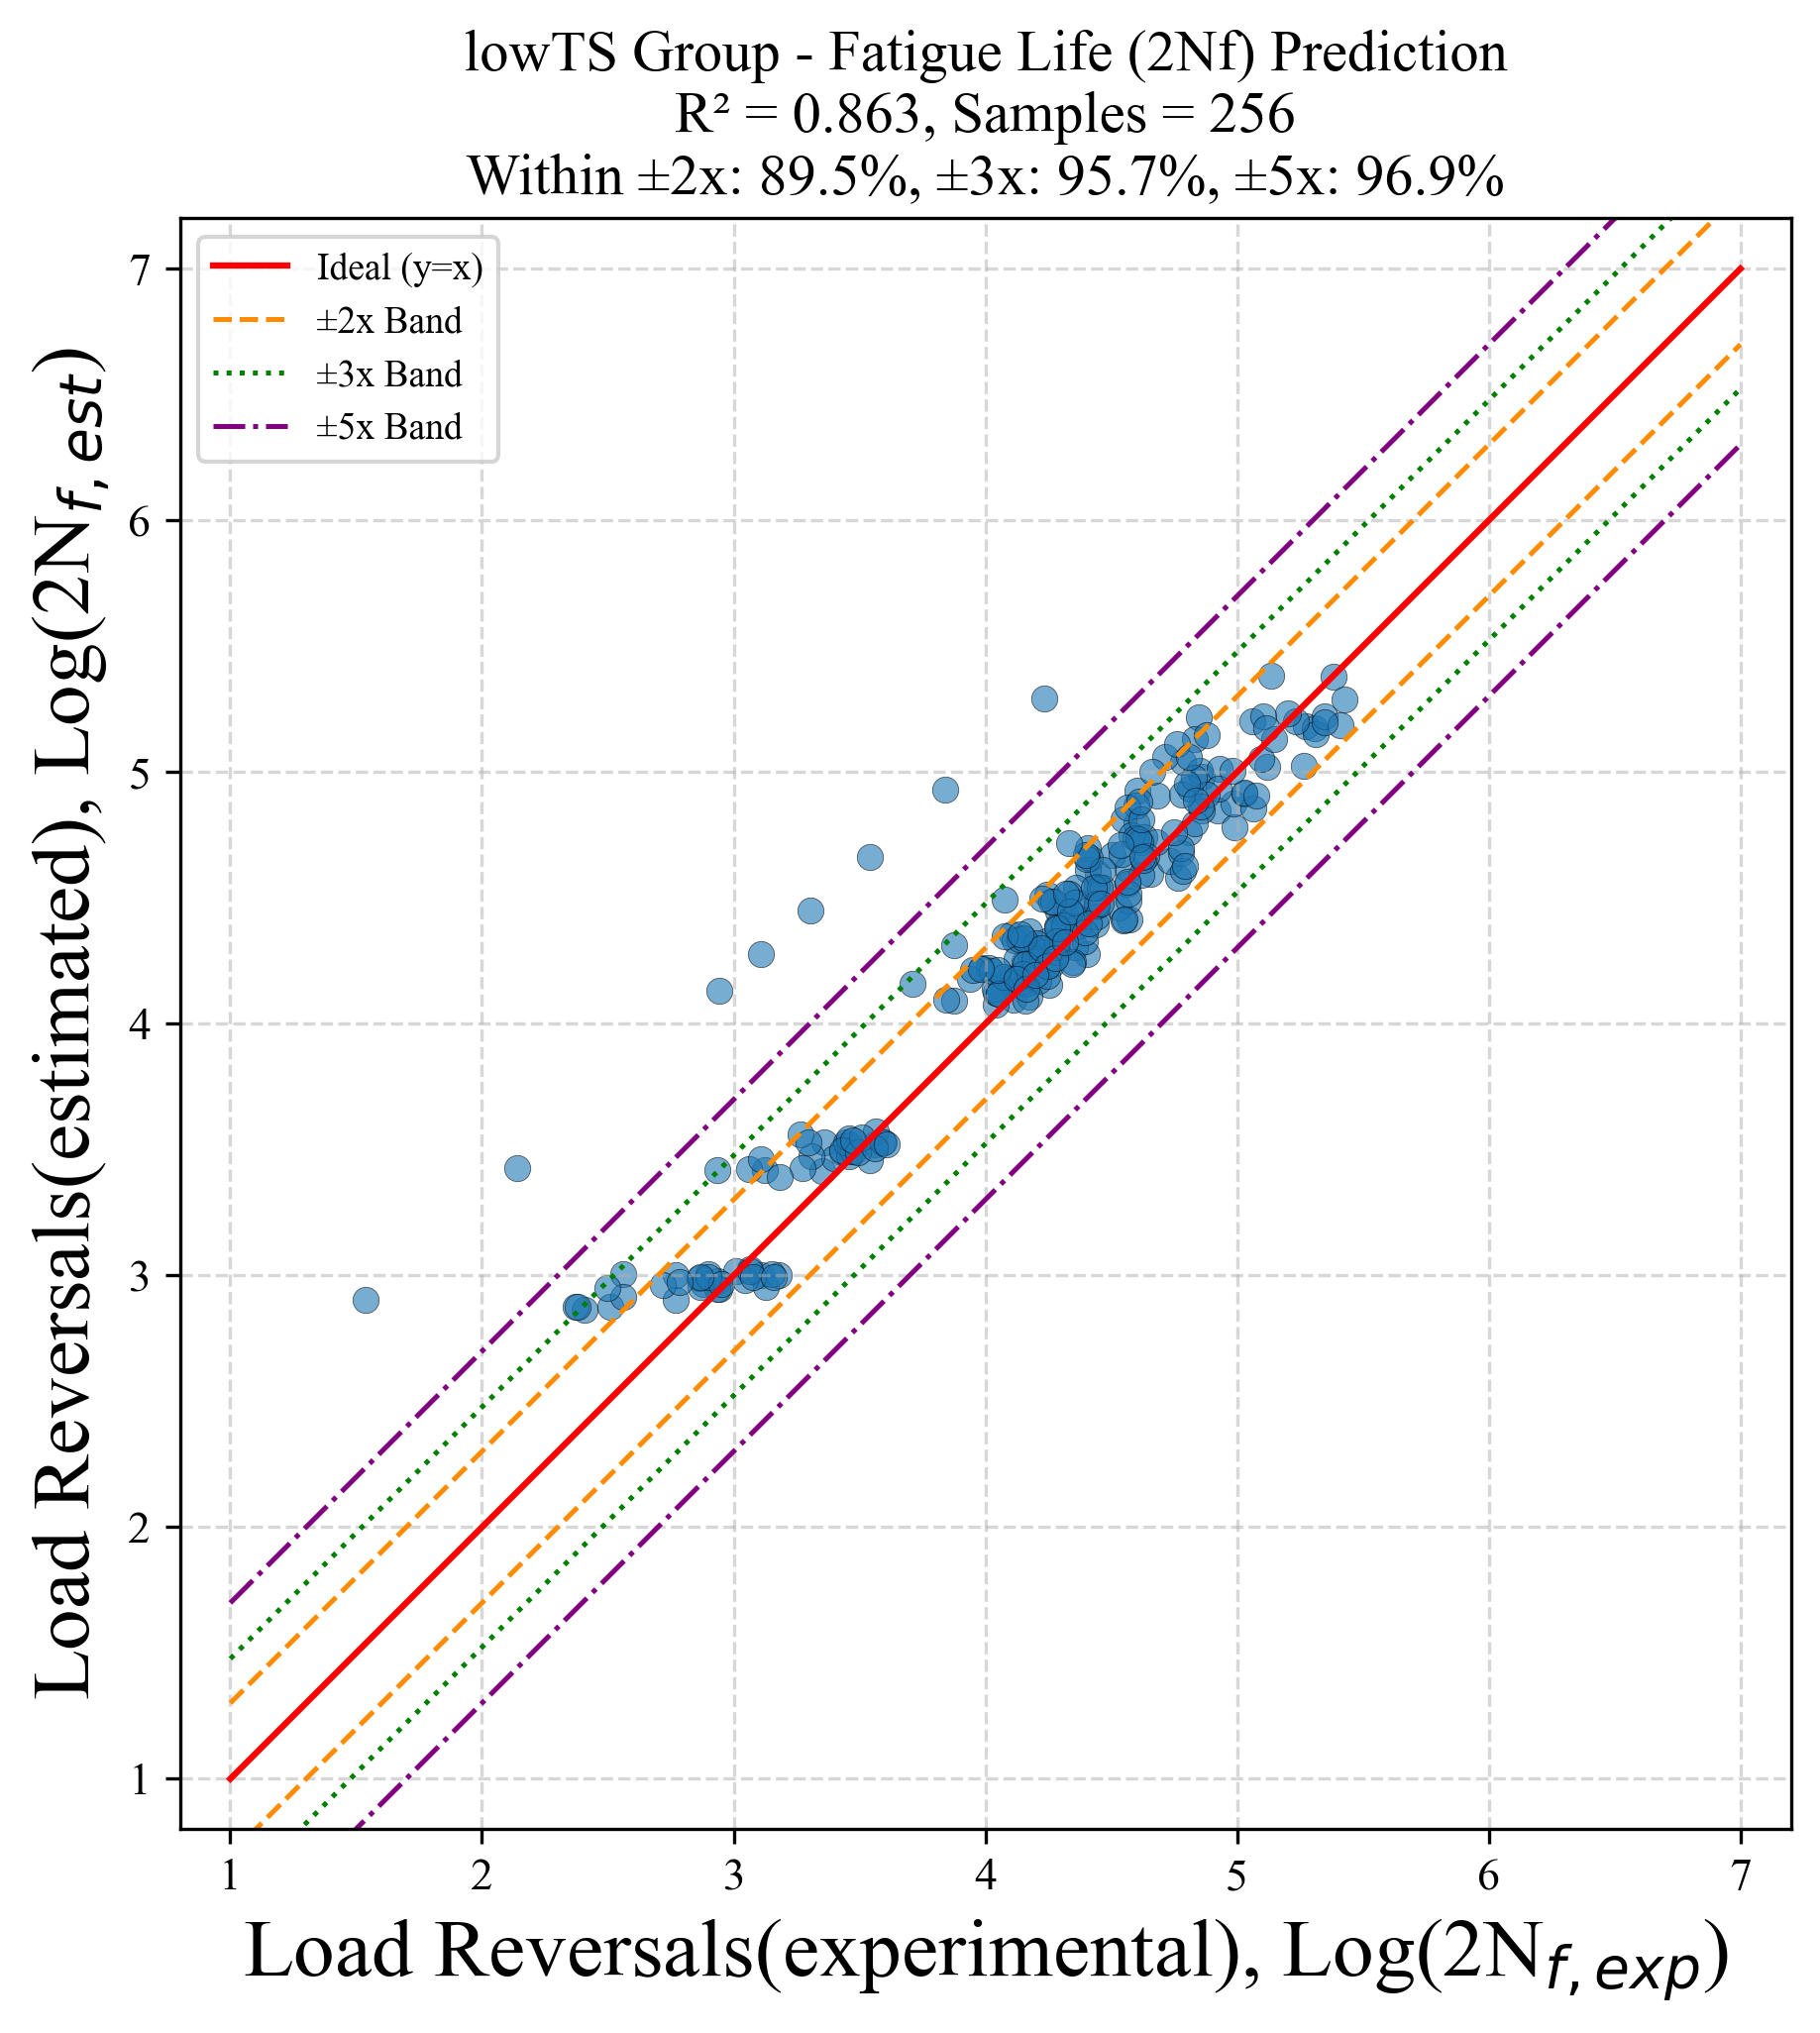

  lowTS - R² = 0.8628
  lowTS - ±2x: 89.5%, ±3x: 95.7%, ±5x: 96.9%

=== midTS 그룹 2Nf 분석 ===
샘플 수: 33
  midTS: 33개 샘플, 8개 변형률 레벨
  midTS: 262개 유효 (2Nf_exp, 2Nf_est) 쌍 생성


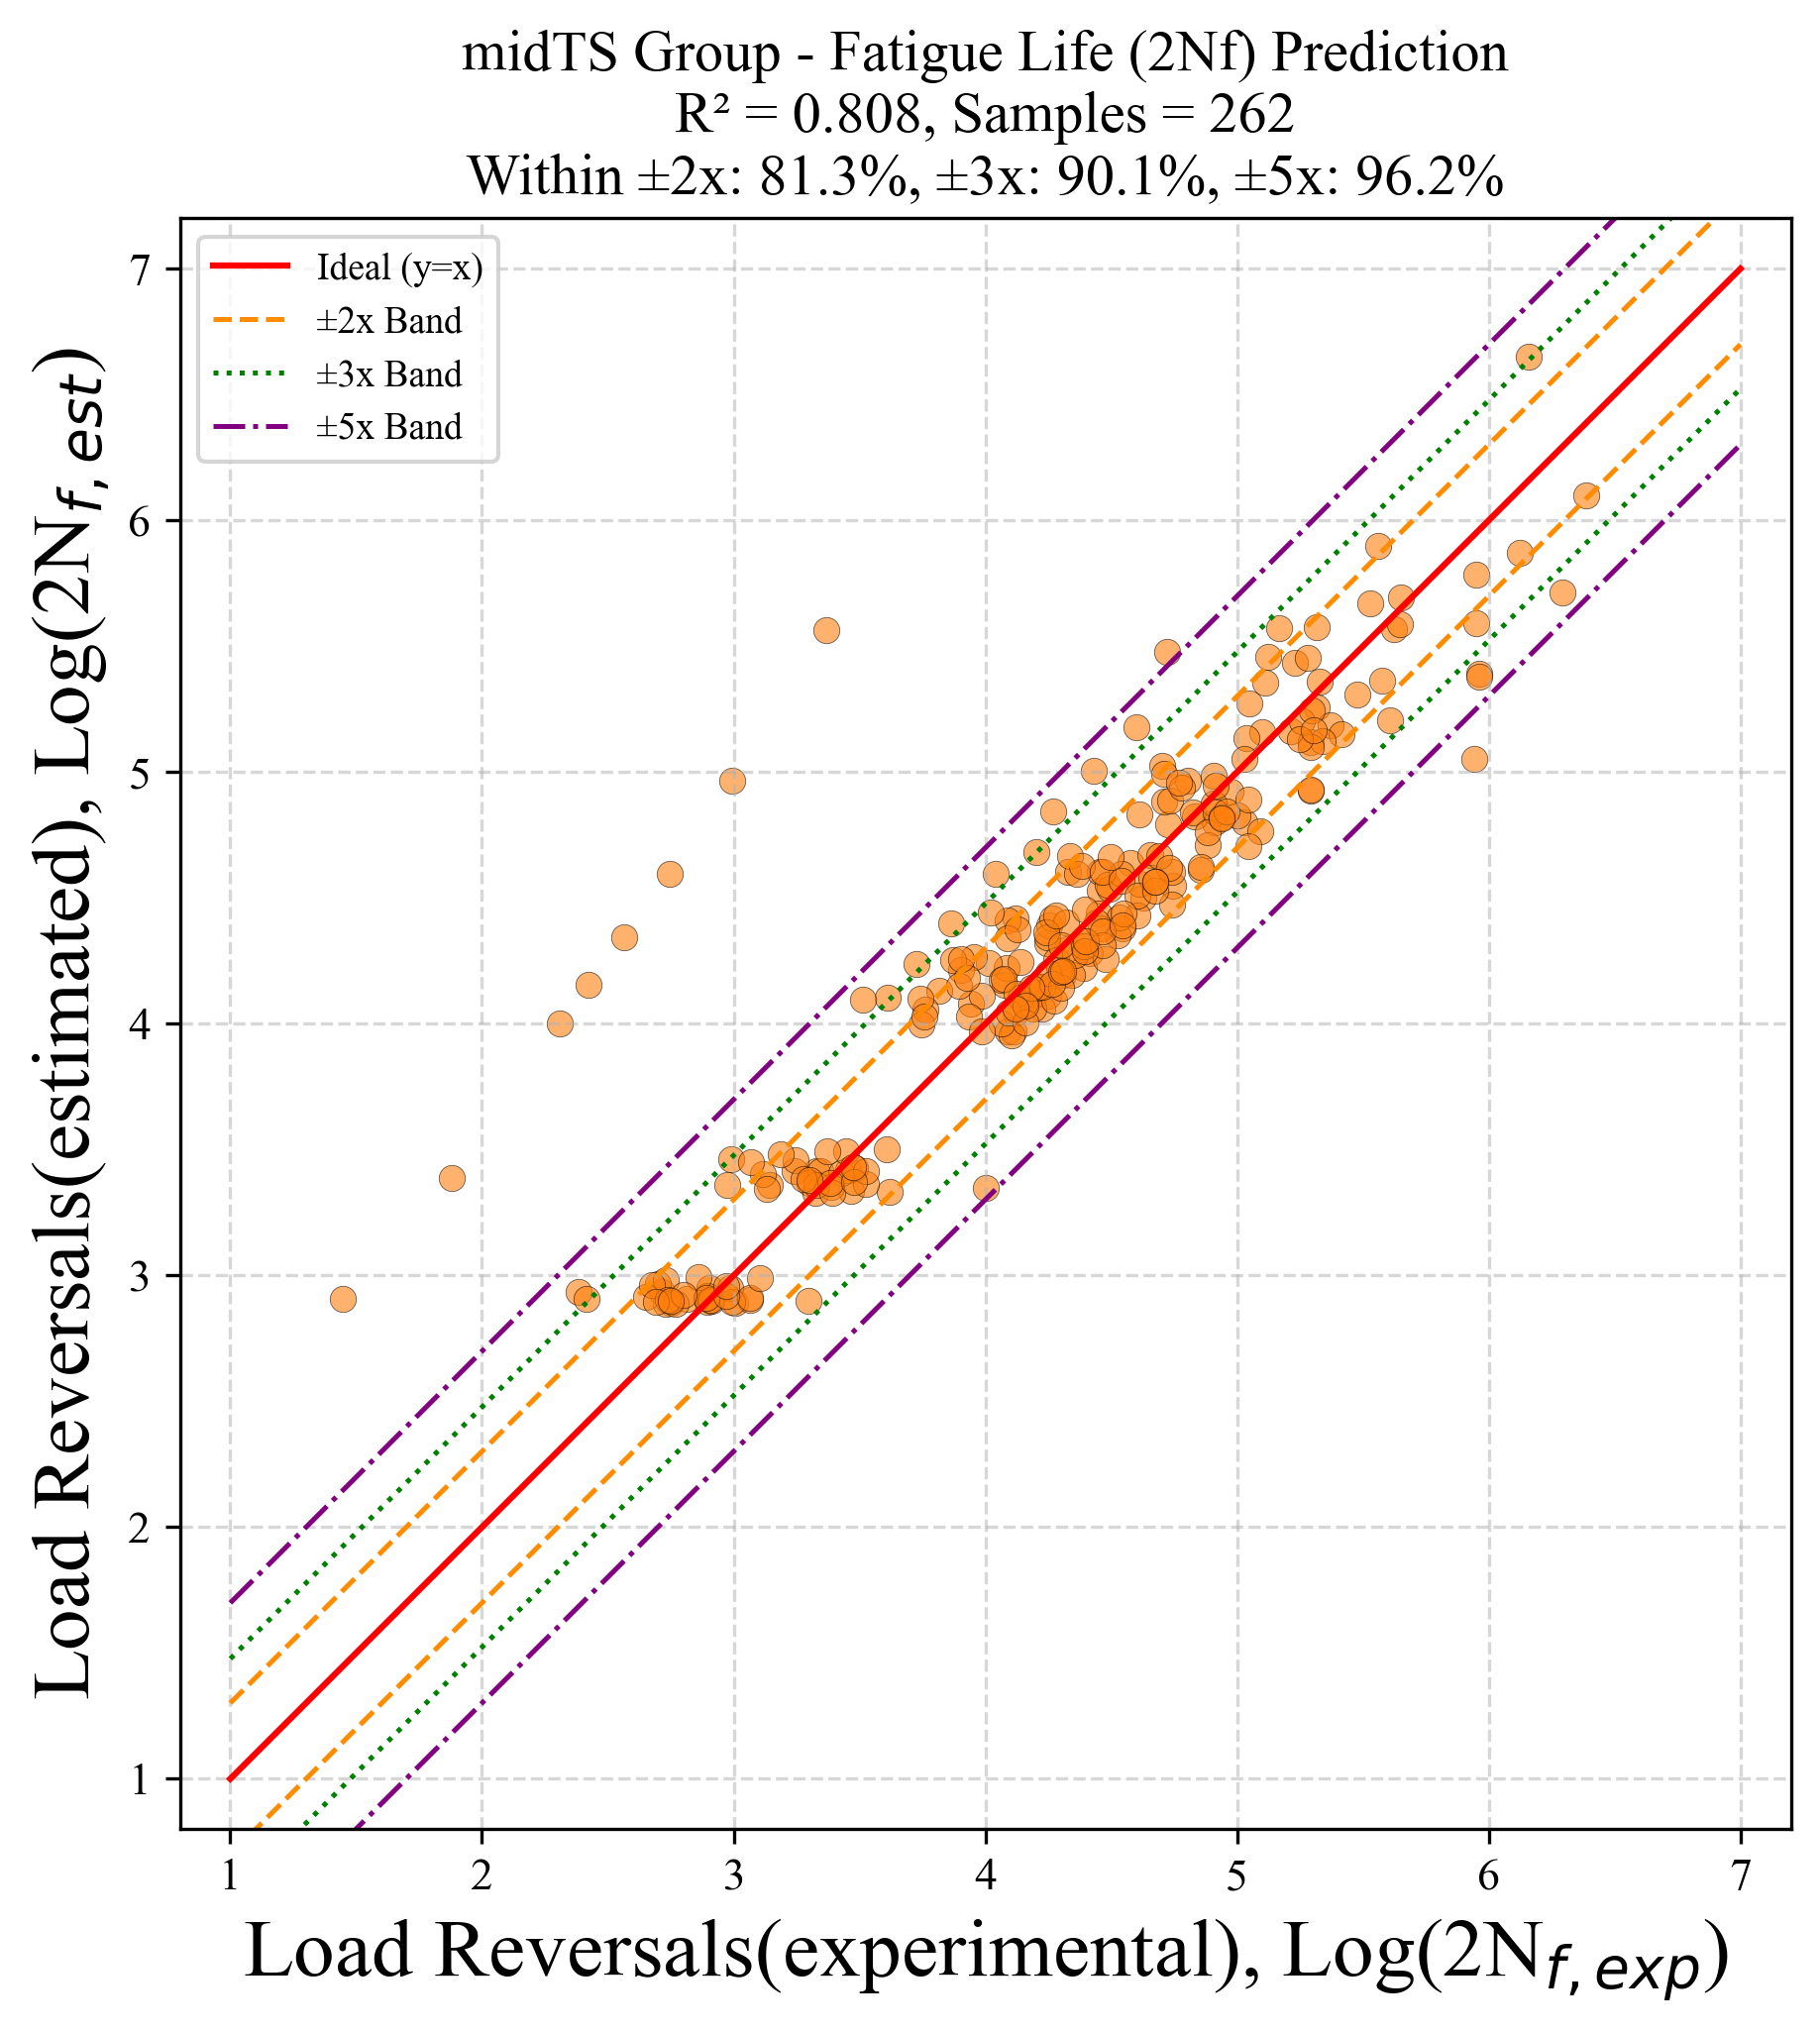

  midTS - R² = 0.8082
  midTS - ±2x: 81.3%, ±3x: 90.1%, ±5x: 96.2%

=== highTS 그룹 2Nf 분석 ===
샘플 수: 34
  highTS: 34개 샘플, 8개 변형률 레벨
  highTS: 258개 유효 (2Nf_exp, 2Nf_est) 쌍 생성


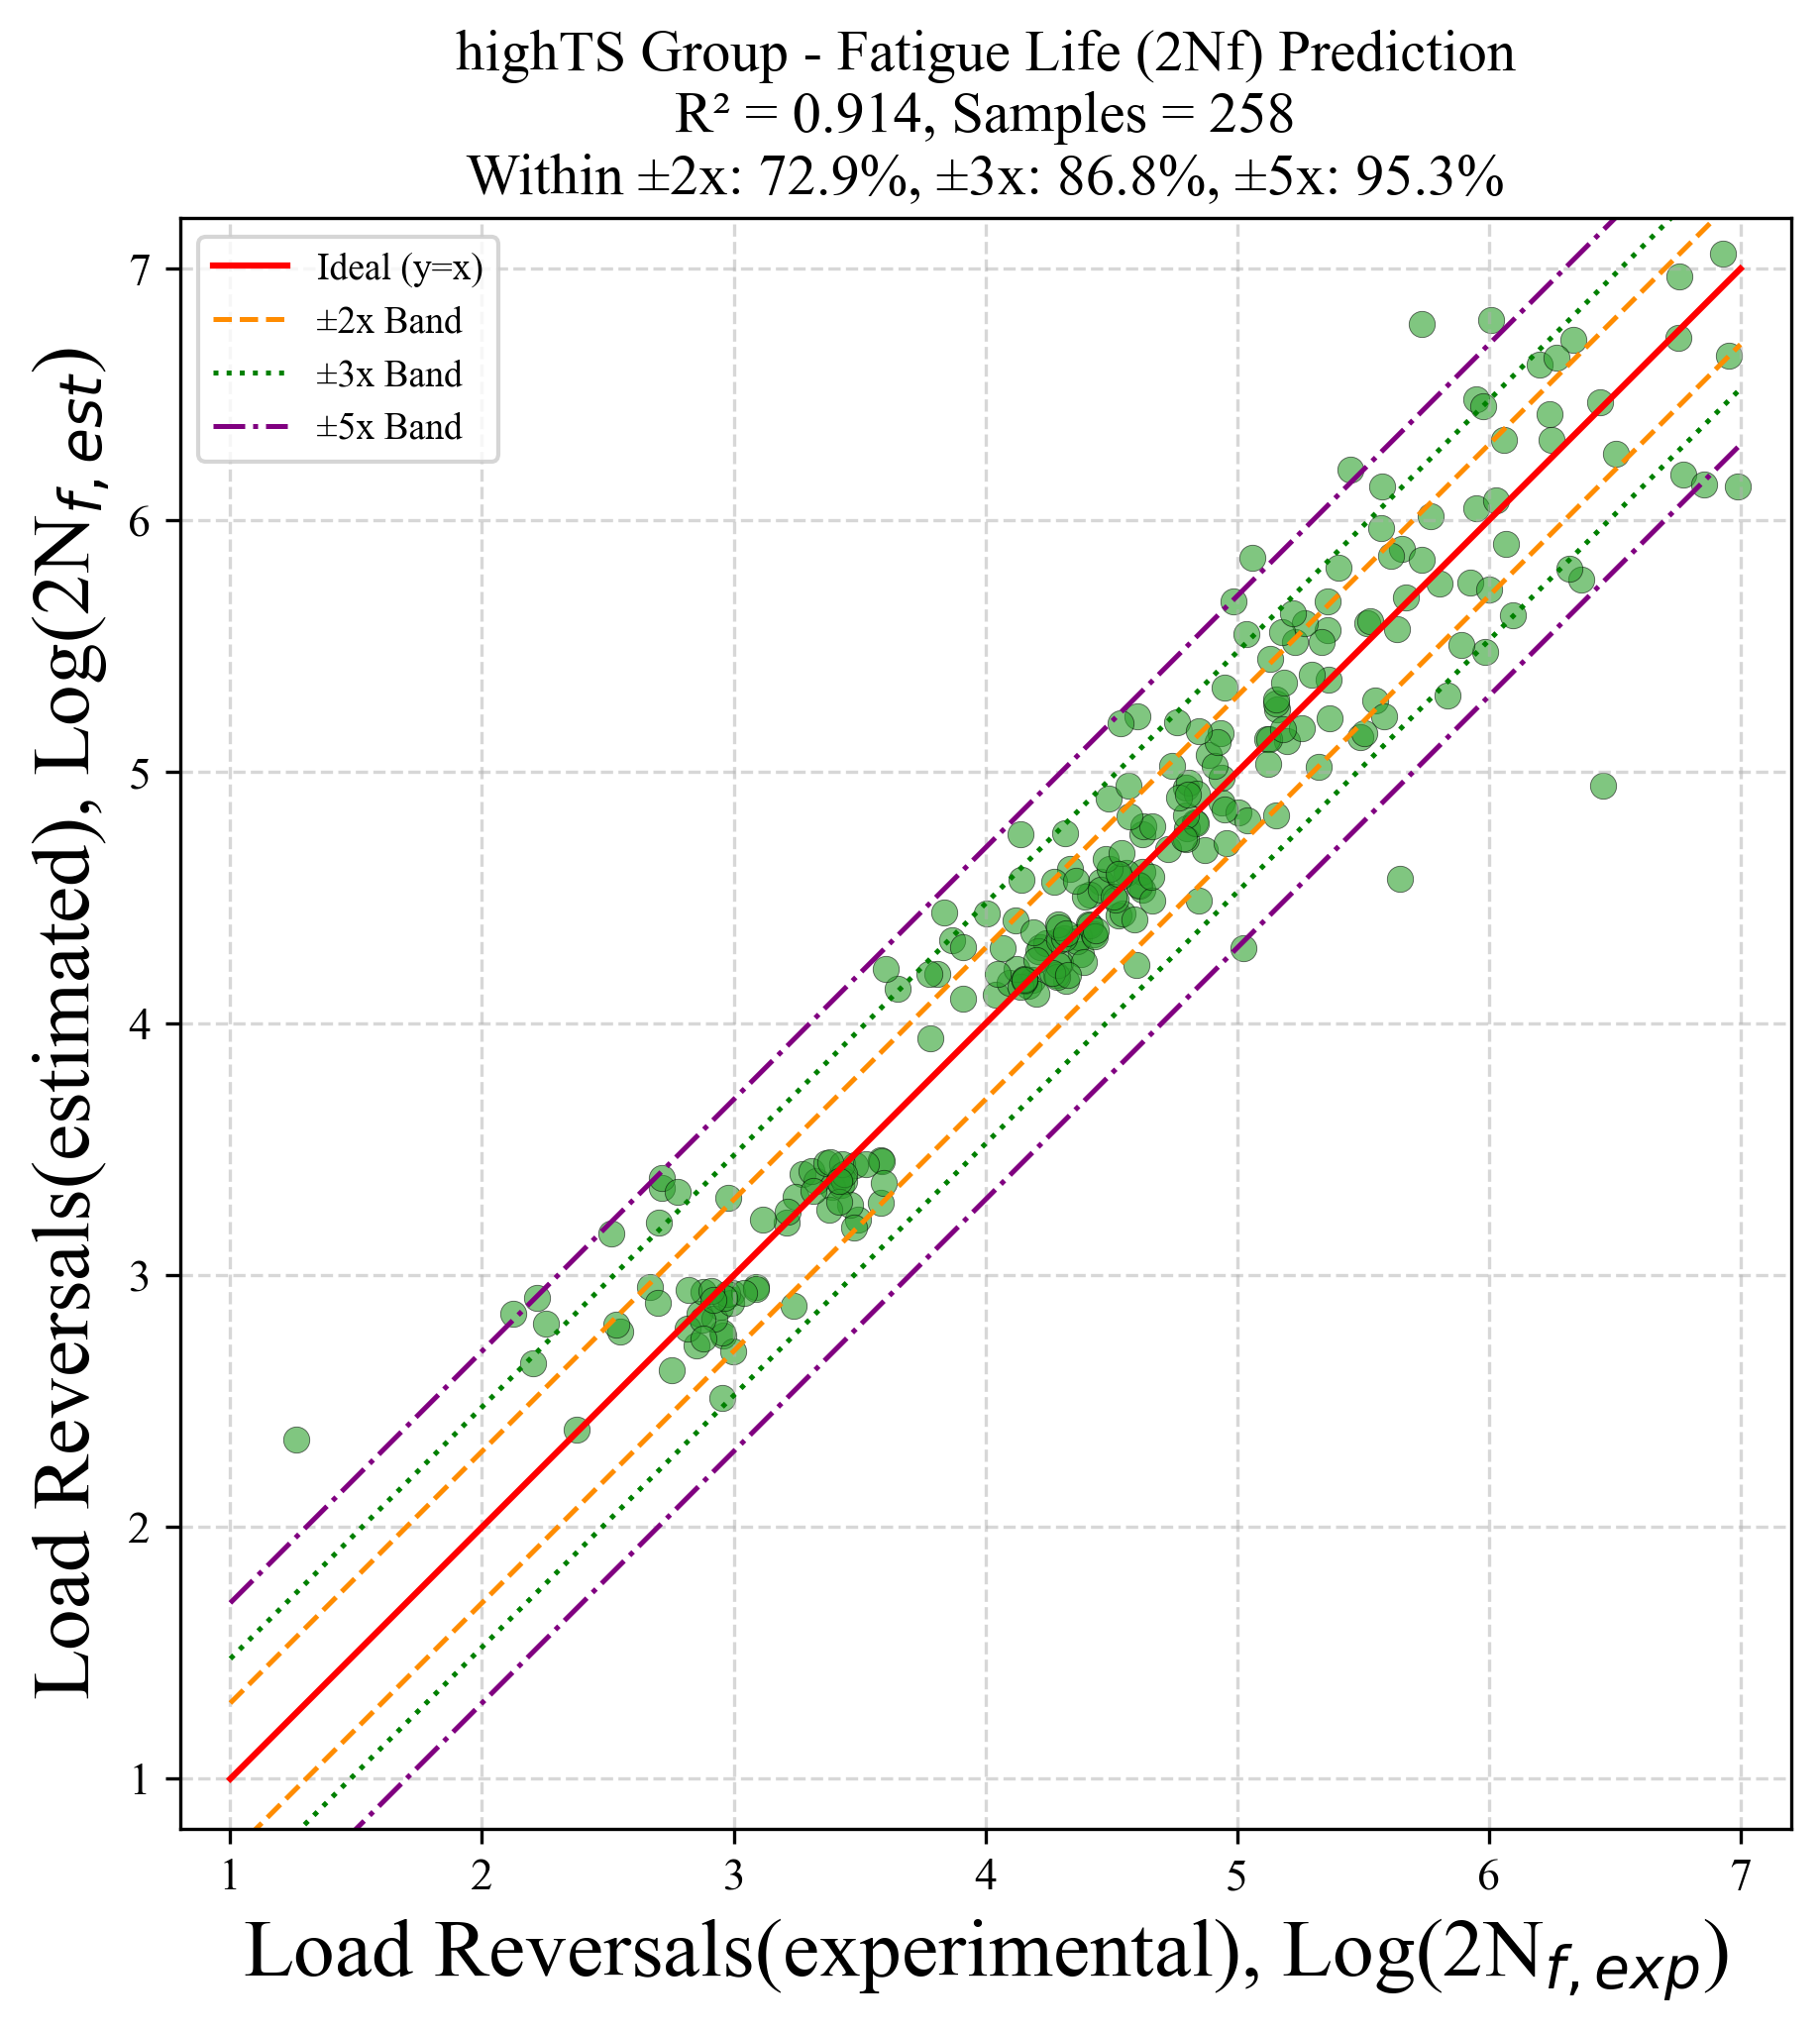

  highTS - R² = 0.9143
  highTS - ±2x: 72.9%, ±3x: 86.8%, ±5x: 95.3%

=== 모든 그룹의 Load Reversals 분석 완료 ===


In [73]:
# Cell 16: 그룹별 피로 수명(2Nf) 비교 - Load Reversals Plot

from scipy.optimize import fsolve
import warnings
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import matplotlib as mpl

# --- 이전 셀들에서 정의된 변수 사용 가정 ---
# model, scaler_X, scalers_y (딕셔너리), target_cols (리스트)
# X_test_tensor, y_test_orig_tensor, E_test_tensor (Cell 6에서 생성)
# all_preds_orig, all_targets_orig (Cell 10에서 생성된 NumPy 배열)
# E_test_np (Cell 10에서 E_test_tensor.cpu().numpy().flatten()으로 생성 가능)
# inverse_transform_targets 함수 (Cell 6에서 정의)
# palette (Cell 10에서 정의)

# Times New Roman 폰트 설정 등 (Cell 10의 mpl.rcParams.update 복사)
mpl.rcParams.update({
    'font.family': 'serif', 'font.serif': 'Times New Roman', 'font.size': 12,
    'axes.labelsize': 20, 'axes.titlesize': 14, 'legend.fontsize': 10, # 범례 폰트 크기 조정
    'xtick.labelsize': 11, 'ytick.labelsize': 11, 'lines.linewidth': 1.8,
    'axes.grid': True, 'grid.alpha': 0.3, 'figure.dpi': 300,
    'axes.unicode_minus': False
})

# --- 1. 평가를 위한 변형률 진폭(Δε/2) 값 정의 (논문 참조) ---
defined_total_strain_amplitudes = np.array([
    0.0025, 0.003, 0.0035, 0.004, 0.0045, 0.005, 0.009, 0.015
])
print(f"평가를 위해 사용할 고정된 총 변형률 진폭 (Δε/2 또는 ε_a) 값들: {defined_total_strain_amplitudes}")


def solve_2Nf_from_strain(params, E_val, epsilon_a_target):
    spf, b_exp, epf, c_exp = params
    E_val_safe = max(float(E_val), 1e-9)

    def equation(two_Nf_val_log10):
        two_Nf_val = 10**two_Nf_val_log10
        if two_Nf_val <= 0: return float('inf')
        try:
            term1 = (spf / E_val_safe) * np.power(max(two_Nf_val, 1e-9), b_exp)
            term2 = epf * np.power(max(two_Nf_val, 1e-9), c_exp)
            return term1 + term2 - epsilon_a_target
        except OverflowError: return float('inf')
        except ValueError: return float('inf')

    initial_guess_log10 = 4.0
    if epsilon_a_target > 0.01: initial_guess_log10 = 2.0
    elif epsilon_a_target < 0.002: initial_guess_log10 = 5.0

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", RuntimeWarning)
        solution_log10, infodict, ier, mesg = fsolve(equation, initial_guess_log10, full_output=True, xtol=1e-7, maxfev=500)
    
    if ier == 1 and isinstance(solution_log10, (np.ndarray, list)) and len(solution_log10) > 0:
        return 10**solution_log10[0]
    elif ier == 1 and isinstance(solution_log10, (int, float)):
         return 10**solution_log10
    else:
        return np.nan

# --- 2. 그룹별 데이터 준비 및 2Nf 계산 ---
print("\n=== 그룹별 Load Reversals (2Nf) 비교 ===")

# 그룹별로 개별 분석
for group_name in ['lowTS', 'midTS', 'highTS']:
    if f'all_preds_orig_{group_name}' in globals() and f'all_targets_orig_{group_name}' in globals():
        
        predicted_params_group = globals()[f'all_preds_orig_{group_name}']
        true_params_group = globals()[f'all_targets_orig_{group_name}']
        E_values_group = globals()[f'E_test_{group_name}'] if f'E_test_{group_name}' in globals() else []
        
        print(f"\n=== {group_name} 그룹 2Nf 분석 ===")
        print(f"샘플 수: {len(predicted_params_group)}")
        
        if len(E_values_group) == 0:
            print(f"{group_name} 그룹의 E 값이 없어 건너뜁니다.")
            continue

        try:
            spf_idx = target_cols.index('spf_MPa')
            b_idx = target_cols.index('b')
            epf_idx = target_cols.index('epf')
            c_idx = target_cols.index('c')
        except ValueError as e:
            print(f"오류: target_cols 리스트에 필요한 파라미터 이름이 없습니다: {e}")
            continue

        # --- 3. 그룹별 2Nf_exp 및 2Nf_est 계산 ---
        twoNf_exp_collected_group = []
        twoNf_est_collected_group = []
        
        num_test_samples_group = len(true_params_group)
        print(f"  {group_name}: {num_test_samples_group}개 샘플, {len(defined_total_strain_amplitudes)}개 변형률 레벨")

        for i in range(num_test_samples_group):
            params_true_sample = true_params_group[i, :]
            params_pred_sample = predicted_params_group[i, :]
            E_val_sample_i = E_values_group[i]

            if any(np.isnan(params_true_sample)) or any(np.isnan(params_pred_sample)):
                continue
                
            for strain_amplitude_level in defined_total_strain_amplitudes:
                twoNf_exp = solve_2Nf_from_strain(params_true_sample, E_val_sample_i, strain_amplitude_level)
                twoNf_est = solve_2Nf_from_strain(params_pred_sample, E_val_sample_i, strain_amplitude_level)

                if not np.isnan(twoNf_exp) and not np.isnan(twoNf_est) and \
                   twoNf_exp > 0 and twoNf_est > 0:
                    if 10**1 <= twoNf_exp <= 10**7 :
                        twoNf_exp_collected_group.append(twoNf_exp)
                        twoNf_est_collected_group.append(twoNf_est)

        if len(twoNf_exp_collected_group) == 0:
            print(f"  {group_name}: 유효한 2Nf 데이터 포인트가 없어 건너뜁니다.")
            continue
            
        log_2Nf_exp_group = np.log10(np.array(twoNf_exp_collected_group))
        log_2Nf_est_group = np.log10(np.array(twoNf_est_collected_group))

        print(f"  {group_name}: {len(log_2Nf_exp_group)}개 유효 (2Nf_exp, 2Nf_est) 쌍 생성")
    
        # --- 4. 그룹별 산점도 (Scatter Plot) 작성 ---
        plt.figure(figsize=(8, 7), facecolor='none')
        
        r2_2Nf_group = r2_score(log_2Nf_exp_group, log_2Nf_est_group)
        
        # --- Scatter band inclusion rate 계산 (2x, 3x, 5x) ---
        ratio_2Nf_group = np.array(twoNf_est_collected_group) / np.array(twoNf_exp_collected_group)
        inside_2x_2Nf_group = np.logical_and(ratio_2Nf_group >= 1/2, ratio_2Nf_group <= 2).mean() * 100
        inside_3x_2Nf_group = np.logical_and(ratio_2Nf_group >= 1/3, ratio_2Nf_group <= 3).mean() * 100
        inside_5x_2Nf_group = np.logical_and(ratio_2Nf_group >= 1/5, ratio_2Nf_group <= 5).mean() * 100
        
        plot_axis_min_log = 1.0
        plot_axis_max_log = 7.0
        line_vals_log = np.linspace(plot_axis_min_log, plot_axis_max_log, 100)

        # 그룹별 색상 사용
        group_colors = {'lowTS': '#1f77b4', 'midTS': '#ff7f0e', 'highTS': '#2ca02c'}
        scatter_color = group_colors.get(group_name, 'blue')

        plt.scatter(log_2Nf_exp_group, log_2Nf_est_group, alpha=0.6, s=40, 
                    color=scatter_color, edgecolor='k', linewidth=0.2)
        
        plt.plot(line_vals_log, line_vals_log, 'r-', linewidth=1.5, label='Ideal (y=x)')
        
        # --- Scatter band 플롯 (2x, 3x, 5x) ---
        log_factor_2 = np.log10(2.0)
        log_factor_3 = np.log10(3.0)
        log_factor_5 = np.log10(5.0)
        
        # 2x Band
        plt.plot(line_vals_log, line_vals_log + log_factor_2, color='darkorange', linestyle='--', linewidth=1.2, label='±2x Band')
        plt.plot(line_vals_log, line_vals_log - log_factor_2, color='darkorange', linestyle='--', linewidth=1.2)
        
        # 3x Band
        plt.plot(line_vals_log, line_vals_log + log_factor_3, color='green', linestyle=':', linewidth=1.2, label='±3x Band')
        plt.plot(line_vals_log, line_vals_log - log_factor_3, color='green', linestyle=':', linewidth=1.2)
        
        # 5x Band
        plt.plot(line_vals_log, line_vals_log + log_factor_5, color='purple', linestyle='-.', linewidth=1.2, label='±5x Band')
        plt.plot(line_vals_log, line_vals_log - log_factor_5, color='purple', linestyle='-.', linewidth=1.2)

        plt.xlabel('Load Reversals(experimental), Log(2N$_{f,exp}$)')
        plt.ylabel('Load Reversals(estimated), Log(2N$_{f,est}$)')
        
        # --- 그룹별 제목 ---
        title_text = (f'{group_name} Group - Fatigue Life (2Nf) Prediction\n'
                      f'R² = {r2_2Nf_group:.3f}, Samples = {len(log_2Nf_exp_group)}\n'
                      f'Within ±2x: {inside_2x_2Nf_group:.1f}%, ±3x: {inside_3x_2Nf_group:.1f}%, ±5x: {inside_5x_2Nf_group:.1f}%')
        plt.title(title_text)
        
        plt.xlim(plot_axis_min_log - 0.2, plot_axis_max_log + 0.2)
        plt.ylim(plot_axis_min_log - 0.2, plot_axis_max_log + 0.2)
        
        tick_values = np.arange(int(np.floor(plot_axis_min_log)), int(np.ceil(plot_axis_max_log)) + 1, 1.0)
        plt.xticks(tick_values)
        plt.yticks(tick_values)
        
        plt.legend(frameon=True, loc='upper left', fontsize=9)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.gca().set_facecolor('none')

        plt.tight_layout()
        plt.show()
        
        print(f"  {group_name} - R² = {r2_2Nf_group:.4f}")
        print(f"  {group_name} - ±2x: {inside_2x_2Nf_group:.1f}%, ±3x: {inside_3x_2Nf_group:.1f}%, ±5x: {inside_5x_2Nf_group:.1f}%")

print("\n=== 모든 그룹의 Load Reversals 분석 완료 ===")

In [74]:
#Cell 17: 하드코딩용 파라미터 딕셔너리 출력
import optuna

# 하드코딩용 형태로 출력
print("=== 하드코딩용 파라미터 딕셔너리 ===")

groups = ['lowTS', 'midTS', 'highTS']
for group in groups:
    try:
        # 실제 데이터베이스 파일명 사용
        study = optuna.load_study(
            study_name=f"fatigue_pinn_{group}_optimization", 
            storage=f"sqlite:///fatigue_pinn_{group}_optimization.db"
        )
        
        print(f"\n# {group} 그룹 최적 파라미터")
        print(f"# Best value (2x band inclusion rate): {study.best_value:.4f}")
        print(f"{group}_best_params = {{")
        for param_name, param_value in study.best_params.items():
            if isinstance(param_value, str):
                print(f"    '{param_name}': '{param_value}',")
            else:
                print(f"    '{param_name}': {param_value},")
        print("}")
        
    except Exception as e:
        print(f"{group} 그룹 로딩 실패: {e}")

=== 하드코딩용 파라미터 딕셔너리 ===

# lowTS 그룹 최적 파라미터
# Best value (2x band inclusion rate): 82.4219
lowTS_best_params = {
    'n_layers': 3,
    'hidden_dim_0': 186,
    'hidden_dim_1': 294,
    'hidden_dim_2': 64,
    'learning_rate': 2.588158862083385e-05,
    'lambda_physics': 0.0004865437951800827,
    'dropout': 0.2153585570737508,
    'batch_size': 32,
    'epochs': 120,
}

# midTS 그룹 최적 파라미터
# Best value (2x band inclusion rate): 82.8244
midTS_best_params = {
    'n_layers': 6,
    'hidden_dim_0': 304,
    'hidden_dim_1': 451,
    'hidden_dim_2': 275,
    'hidden_dim_3': 421,
    'hidden_dim_4': 286,
    'hidden_dim_5': 232,
    'learning_rate': 0.000749598188470451,
    'lambda_physics': 0.0009474217104505375,
    'dropout': 0.20153194157945667,
    'batch_size': 128,
    'epochs': 169,
}

# highTS 그룹 최적 파라미터
# Best value (2x band inclusion rate): 65.8436
highTS_best_params = {
    'n_layers': 5,
    'hidden_dim_0': 727,
    'hidden_dim_1': 533,
    'hidden_dim_2': 636,
    'hidden_dim_